# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [3]:
import logging
from multiprocessing import Pool

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import ZoningGameEnv, flatten_zg_obs, Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random

from nsai_experiments.zoning_game.notebook_utils import create_dataset_1_one_game

In [4]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [5]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

def create_dataset_1(policy_creator, n_games = 10_000):
    states = []
    values = []
    with Pool() as pool:
        # Due to a limitation in `multiprocessing` we had to define `create_dataset_1_one_game` in a separate file
        # (see https://stackoverflow.com/questions/41385708/)
        results = pool.starmap(create_dataset_1_one_game,
                               [(policy_creator, game_i+n_games, game_i) for game_i in range(n_games)])
    for my_states, my_values in results:
        states.extend(my_states)
        values.extend(my_values)
    return np.array(states), np.array(values)

states, values = create_dataset_1(create_policy_random)
print(states.shape)
print(values.shape)

states_tensor = torch.tensor(states, dtype=torch.long)
values_tensor = torch.tensor(values, dtype=torch.float32)

full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

(216143, 72)
(216143,)
Train size: 151301, validation size: 32421, test size: 32421


In [ ]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()

        input_length = grid_size*grid_size*2
        one_hot_length = input_length * len(Tile)  # 432

        # n_hidden_1 = one_hot_length*2
        # n_hidden_2 = one_hot_length
        # n_hidden_3 = input_length
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden_1),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_1, n_hidden_2),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_2, n_hidden_3),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_3, 1)
        # )

        # Best val loss: 2.4 after 50 epochs
        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # Best val loss 32: 2.7 after 50 epochs
        # Best val loss 54: 2.1 after 50 epochs
        # out_channels = 32
        # self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.ReLU(),
        #     nn.Linear(input_length*out_channels//2, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )
        # x = x[:, :36]
        # x = x.reshape(-1, 6, 6)
        # x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        # x = self.conv1(x)
        # x = torch.flatten(x, start_dim=1)
        # x = self.linear_relu_stack(x)
        # return x

        out_channels = 54
        self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        n_hidden = 432
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_length*out_channels//2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )


    def forward(self, x):
        x = x[:, :36]
        x = x.reshape(-1, 6, 6)
        x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        x = self.conv1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear_relu_stack(x)
        return x

In [62]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 148/148 [00:02<00:00, 63.08it/s]


Epoch 1/1000, Train Loss: 159.9878, Val Loss: 80.5085, Max Abs Diff: 50.3807, Min Abs Diff: 0.0005, Mean Abs Diff: 6.9751


100%|██████████| 148/148 [00:02<00:00, 61.36it/s]


Epoch 2/1000, Train Loss: 60.9676, Val Loss: 36.0297, Max Abs Diff: 36.1668, Min Abs Diff: 0.0005, Mean Abs Diff: 4.7077


100%|██████████| 148/148 [00:02<00:00, 64.74it/s]


Epoch 3/1000, Train Loss: 26.1373, Val Loss: 17.5887, Max Abs Diff: 28.7110, Min Abs Diff: 0.0000, Mean Abs Diff: 3.2855


100%|██████████| 148/148 [00:02<00:00, 66.48it/s]


Epoch 4/1000, Train Loss: 16.7626, Val Loss: 12.7279, Max Abs Diff: 26.1992, Min Abs Diff: 0.0002, Mean Abs Diff: 2.7924


100%|██████████| 148/148 [00:02<00:00, 61.27it/s]


Epoch 5/1000, Train Loss: 12.6843, Val Loss: 10.6264, Max Abs Diff: 24.0815, Min Abs Diff: 0.0002, Mean Abs Diff: 2.5625


100%|██████████| 148/148 [00:02<00:00, 64.33it/s]


Epoch 6/1000, Train Loss: 11.0631, Val Loss: 9.2267, Max Abs Diff: 24.2823, Min Abs Diff: 0.0001, Mean Abs Diff: 2.3829


100%|██████████| 148/148 [00:02<00:00, 64.23it/s]


Epoch 7/1000, Train Loss: 9.2982, Val Loss: 8.9487, Max Abs Diff: 24.3195, Min Abs Diff: 0.0004, Mean Abs Diff: 2.3472


100%|██████████| 148/148 [00:02<00:00, 64.94it/s]


Epoch 8/1000, Train Loss: 8.2703, Val Loss: 7.9071, Max Abs Diff: 22.9056, Min Abs Diff: 0.0000, Mean Abs Diff: 2.2068


100%|██████████| 148/148 [00:02<00:00, 61.85it/s]


Epoch 9/1000, Train Loss: 7.5902, Val Loss: 8.8713, Max Abs Diff: 20.0304, Min Abs Diff: 0.0001, Mean Abs Diff: 2.3618


100%|██████████| 148/148 [00:02<00:00, 61.86it/s]


Epoch 10/1000, Train Loss: 6.8207, Val Loss: 5.3388, Max Abs Diff: 20.7594, Min Abs Diff: 0.0001, Mean Abs Diff: 1.8148


100%|██████████| 148/148 [00:02<00:00, 63.05it/s]


Epoch 11/1000, Train Loss: 6.6889, Val Loss: 6.9244, Max Abs Diff: 20.7400, Min Abs Diff: 0.0001, Mean Abs Diff: 2.0680


100%|██████████| 148/148 [00:02<00:00, 66.62it/s]


Epoch 12/1000, Train Loss: 5.9737, Val Loss: 5.9159, Max Abs Diff: 18.7426, Min Abs Diff: 0.0001, Mean Abs Diff: 1.9185


100%|██████████| 148/148 [00:02<00:00, 64.44it/s]


Epoch 13/1000, Train Loss: 5.6684, Val Loss: 5.4888, Max Abs Diff: 19.7411, Min Abs Diff: 0.0001, Mean Abs Diff: 1.8357


100%|██████████| 148/148 [00:02<00:00, 65.48it/s]


Epoch 14/1000, Train Loss: 5.5310, Val Loss: 4.1356, Max Abs Diff: 18.6374, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5991


100%|██████████| 148/148 [00:02<00:00, 66.04it/s]


Epoch 15/1000, Train Loss: 4.8729, Val Loss: 4.3915, Max Abs Diff: 18.0152, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6453


100%|██████████| 148/148 [00:02<00:00, 63.20it/s]


Epoch 16/1000, Train Loss: 5.3760, Val Loss: 6.0367, Max Abs Diff: 15.7754, Min Abs Diff: 0.0000, Mean Abs Diff: 1.9622


100%|██████████| 148/148 [00:02<00:00, 66.00it/s]


Epoch 17/1000, Train Loss: 4.7680, Val Loss: 4.3847, Max Abs Diff: 16.5696, Min Abs Diff: 0.0002, Mean Abs Diff: 1.6438


100%|██████████| 148/148 [00:02<00:00, 64.65it/s]


Epoch 18/1000, Train Loss: 4.5258, Val Loss: 5.7892, Max Abs Diff: 15.8602, Min Abs Diff: 0.0001, Mean Abs Diff: 1.9251


100%|██████████| 148/148 [00:02<00:00, 65.51it/s]


Epoch 19/1000, Train Loss: 4.4736, Val Loss: 4.4745, Max Abs Diff: 18.2892, Min Abs Diff: 0.0004, Mean Abs Diff: 1.6693


100%|██████████| 148/148 [00:02<00:00, 62.49it/s]


Epoch 20/1000, Train Loss: 4.3099, Val Loss: 3.8013, Max Abs Diff: 17.4251, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5281


100%|██████████| 148/148 [00:02<00:00, 65.99it/s]


Epoch 21/1000, Train Loss: 4.1914, Val Loss: 3.9855, Max Abs Diff: 16.7082, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5734


100%|██████████| 148/148 [00:02<00:00, 64.51it/s]


Epoch 22/1000, Train Loss: 4.0347, Val Loss: 3.4271, Max Abs Diff: 18.3134, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4531


100%|██████████| 148/148 [00:02<00:00, 63.06it/s]


Epoch 23/1000, Train Loss: 4.2135, Val Loss: 3.1083, Max Abs Diff: 17.0657, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3808


100%|██████████| 148/148 [00:02<00:00, 63.92it/s]


Epoch 24/1000, Train Loss: 3.5330, Val Loss: 3.0707, Max Abs Diff: 18.4899, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3701


100%|██████████| 148/148 [00:02<00:00, 64.11it/s]


Epoch 25/1000, Train Loss: 4.0919, Val Loss: 3.3707, Max Abs Diff: 15.8838, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4423


100%|██████████| 148/148 [00:02<00:00, 64.97it/s]


Epoch 26/1000, Train Loss: 3.4547, Val Loss: 3.1109, Max Abs Diff: 17.9181, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3803


100%|██████████| 148/148 [00:02<00:00, 56.12it/s]


Epoch 27/1000, Train Loss: 3.5164, Val Loss: 3.2800, Max Abs Diff: 18.0603, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4176


100%|██████████| 148/148 [00:02<00:00, 67.71it/s]


Epoch 28/1000, Train Loss: 3.4543, Val Loss: 3.2051, Max Abs Diff: 17.4738, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4025


100%|██████████| 148/148 [00:02<00:00, 57.69it/s]


Epoch 29/1000, Train Loss: 3.4385, Val Loss: 2.7962, Max Abs Diff: 15.7032, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3124


100%|██████████| 148/148 [00:02<00:00, 59.16it/s]


Epoch 30/1000, Train Loss: 3.6574, Val Loss: 6.3373, Max Abs Diff: 16.0530, Min Abs Diff: 0.0000, Mean Abs Diff: 2.0570


100%|██████████| 148/148 [00:02<00:00, 55.93it/s]


Epoch 31/1000, Train Loss: 3.4174, Val Loss: 3.4952, Max Abs Diff: 17.2852, Min Abs Diff: 0.0004, Mean Abs Diff: 1.4651


100%|██████████| 148/148 [00:02<00:00, 62.90it/s]


Epoch 32/1000, Train Loss: 3.3777, Val Loss: 2.8460, Max Abs Diff: 12.8333, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3264


100%|██████████| 148/148 [00:02<00:00, 57.62it/s]


Epoch 33/1000, Train Loss: 3.0693, Val Loss: 5.2559, Max Abs Diff: 15.1769, Min Abs Diff: 0.0001, Mean Abs Diff: 1.8826


100%|██████████| 148/148 [00:02<00:00, 57.25it/s]


Epoch 34/1000, Train Loss: 3.5218, Val Loss: 2.7180, Max Abs Diff: 14.3885, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2967


100%|██████████| 148/148 [00:02<00:00, 53.60it/s]


Epoch 35/1000, Train Loss: 2.7378, Val Loss: 3.5116, Max Abs Diff: 16.2679, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4806


100%|██████████| 148/148 [00:02<00:00, 56.93it/s]


Epoch 36/1000, Train Loss: 3.2940, Val Loss: 2.4047, Max Abs Diff: 13.7020, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2147


100%|██████████| 148/148 [00:02<00:00, 58.35it/s]


Epoch 37/1000, Train Loss: 2.9869, Val Loss: 2.6081, Max Abs Diff: 11.4945, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2696


100%|██████████| 148/148 [00:02<00:00, 60.29it/s]


Epoch 38/1000, Train Loss: 3.1260, Val Loss: 2.2763, Max Abs Diff: 14.2496, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1816


100%|██████████| 148/148 [00:02<00:00, 58.62it/s]


Epoch 39/1000, Train Loss: 3.0156, Val Loss: 2.8813, Max Abs Diff: 13.7878, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3333


100%|██████████| 148/148 [00:02<00:00, 56.01it/s]


Epoch 40/1000, Train Loss: 2.9999, Val Loss: 2.6479, Max Abs Diff: 15.2541, Min Abs Diff: 0.0003, Mean Abs Diff: 1.2754


100%|██████████| 148/148 [00:02<00:00, 58.63it/s]


Epoch 41/1000, Train Loss: 2.7149, Val Loss: 2.5510, Max Abs Diff: 12.4718, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2543


100%|██████████| 148/148 [00:02<00:00, 57.25it/s]


Epoch 42/1000, Train Loss: 2.8712, Val Loss: 2.2863, Max Abs Diff: 14.3511, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1855


100%|██████████| 148/148 [00:02<00:00, 60.22it/s]


Epoch 43/1000, Train Loss: 3.7975, Val Loss: 2.2707, Max Abs Diff: 10.7032, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1778


100%|██████████| 148/148 [00:02<00:00, 56.04it/s]


Epoch 44/1000, Train Loss: 2.5210, Val Loss: 3.4590, Max Abs Diff: 14.7570, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4798


100%|██████████| 148/148 [00:02<00:00, 59.37it/s]


Epoch 45/1000, Train Loss: 2.5159, Val Loss: 2.3556, Max Abs Diff: 10.8041, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2016


100%|██████████| 148/148 [00:02<00:00, 57.56it/s]


Epoch 46/1000, Train Loss: 3.0083, Val Loss: 2.6836, Max Abs Diff: 13.7421, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2840


100%|██████████| 148/148 [00:02<00:00, 56.50it/s]


Epoch 47/1000, Train Loss: 2.7482, Val Loss: 2.5507, Max Abs Diff: 15.0895, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2544


100%|██████████| 148/148 [00:02<00:00, 55.18it/s]


Epoch 48/1000, Train Loss: 3.0644, Val Loss: 7.3672, Max Abs Diff: 14.9384, Min Abs Diff: 0.0003, Mean Abs Diff: 2.2833


100%|██████████| 148/148 [00:02<00:00, 60.73it/s]


Epoch 49/1000, Train Loss: 2.5229, Val Loss: 2.4026, Max Abs Diff: 10.2488, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2229


100%|██████████| 148/148 [00:02<00:00, 61.41it/s]


Epoch 50/1000, Train Loss: 2.6773, Val Loss: 2.6380, Max Abs Diff: 15.3573, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2802


100%|██████████| 148/148 [00:02<00:00, 58.07it/s]


Epoch 51/1000, Train Loss: 2.4014, Val Loss: 2.3112, Max Abs Diff: 13.3154, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1910


100%|██████████| 148/148 [00:02<00:00, 56.39it/s]


Epoch 52/1000, Train Loss: 2.5532, Val Loss: 1.9715, Max Abs Diff: 14.0970, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0986


100%|██████████| 148/148 [00:02<00:00, 52.29it/s]


Epoch 53/1000, Train Loss: 2.7117, Val Loss: 4.5709, Max Abs Diff: 12.1041, Min Abs Diff: 0.0001, Mean Abs Diff: 1.7579


100%|██████████| 148/148 [00:02<00:00, 56.17it/s]


Epoch 54/1000, Train Loss: 2.6190, Val Loss: 3.3028, Max Abs Diff: 13.6356, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4387


100%|██████████| 148/148 [00:02<00:00, 57.79it/s]


Epoch 55/1000, Train Loss: 2.6307, Val Loss: 2.9365, Max Abs Diff: 13.5794, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3616


100%|██████████| 148/148 [00:02<00:00, 58.44it/s]


Epoch 56/1000, Train Loss: 2.5085, Val Loss: 2.0473, Max Abs Diff: 10.1379, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1250


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 57/1000, Train Loss: 2.5097, Val Loss: 2.3798, Max Abs Diff: 14.7939, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2094


100%|██████████| 148/148 [00:02<00:00, 56.78it/s]


Epoch 58/1000, Train Loss: 2.2846, Val Loss: 2.1603, Max Abs Diff: 12.7792, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1514


100%|██████████| 148/148 [00:02<00:00, 56.20it/s]


Epoch 59/1000, Train Loss: 2.8224, Val Loss: 3.8054, Max Abs Diff: 11.7253, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5856


100%|██████████| 148/148 [00:02<00:00, 56.85it/s]


Epoch 60/1000, Train Loss: 2.6417, Val Loss: 2.3586, Max Abs Diff: 13.1945, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2036


100%|██████████| 148/148 [00:02<00:00, 56.66it/s]


Epoch 61/1000, Train Loss: 2.2360, Val Loss: 2.0970, Max Abs Diff: 9.8160, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1306


100%|██████████| 148/148 [00:02<00:00, 55.12it/s]


Epoch 62/1000, Train Loss: 2.5748, Val Loss: 1.8629, Max Abs Diff: 14.2146, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0650


100%|██████████| 148/148 [00:02<00:00, 55.41it/s]


Epoch 63/1000, Train Loss: 2.3703, Val Loss: 1.8839, Max Abs Diff: 14.1807, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0711


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 64/1000, Train Loss: 2.4180, Val Loss: 2.2178, Max Abs Diff: 11.5467, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1686


100%|██████████| 148/148 [00:02<00:00, 59.28it/s]


Epoch 65/1000, Train Loss: 2.4094, Val Loss: 2.5135, Max Abs Diff: 12.8935, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2548


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 66/1000, Train Loss: 2.3273, Val Loss: 9.1163, Max Abs Diff: 15.4411, Min Abs Diff: 0.0000, Mean Abs Diff: 2.6415


100%|██████████| 148/148 [00:02<00:00, 55.02it/s]


Epoch 67/1000, Train Loss: 2.4663, Val Loss: 2.6434, Max Abs Diff: 13.9930, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2847


100%|██████████| 148/148 [00:02<00:00, 56.12it/s]


Epoch 68/1000, Train Loss: 2.3820, Val Loss: 2.1365, Max Abs Diff: 13.5408, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1433


100%|██████████| 148/148 [00:02<00:00, 56.25it/s]


Epoch 69/1000, Train Loss: 2.3062, Val Loss: 2.9531, Max Abs Diff: 10.9268, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3642


100%|██████████| 148/148 [00:02<00:00, 56.37it/s]


Epoch 70/1000, Train Loss: 2.3448, Val Loss: 1.8527, Max Abs Diff: 12.0157, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0654


100%|██████████| 148/148 [00:02<00:00, 58.82it/s]


Epoch 71/1000, Train Loss: 2.1986, Val Loss: 1.9120, Max Abs Diff: 13.1126, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0871


100%|██████████| 148/148 [00:02<00:00, 55.52it/s]


Epoch 72/1000, Train Loss: 2.6032, Val Loss: 2.0820, Max Abs Diff: 9.8232, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1321


100%|██████████| 148/148 [00:02<00:00, 59.04it/s]


Epoch 73/1000, Train Loss: 2.3165, Val Loss: 1.9999, Max Abs Diff: 12.4974, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1120


100%|██████████| 148/148 [00:02<00:00, 59.83it/s]


Epoch 74/1000, Train Loss: 2.2291, Val Loss: 2.2634, Max Abs Diff: 9.4867, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1841


100%|██████████| 148/148 [00:02<00:00, 56.33it/s]


Epoch 75/1000, Train Loss: 2.4702, Val Loss: 1.7941, Max Abs Diff: 9.2752, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0465


100%|██████████| 148/148 [00:02<00:00, 61.53it/s]


Epoch 76/1000, Train Loss: 2.7586, Val Loss: 4.0113, Max Abs Diff: 15.6241, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5736


100%|██████████| 148/148 [00:02<00:00, 57.78it/s]


Epoch 77/1000, Train Loss: 2.1779, Val Loss: 1.6474, Max Abs Diff: 10.4108, Min Abs Diff: 0.0002, Mean Abs Diff: 1.0025


100%|██████████| 148/148 [00:02<00:00, 59.32it/s]


Epoch 78/1000, Train Loss: 2.1656, Val Loss: 1.6802, Max Abs Diff: 10.4491, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0130


100%|██████████| 148/148 [00:02<00:00, 57.15it/s]


Epoch 79/1000, Train Loss: 2.1876, Val Loss: 3.2997, Max Abs Diff: 10.5816, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4720


100%|██████████| 148/148 [00:02<00:00, 58.31it/s]


Epoch 80/1000, Train Loss: 2.8899, Val Loss: 2.5978, Max Abs Diff: 10.3831, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2731


100%|██████████| 148/148 [00:02<00:00, 58.82it/s]


Epoch 81/1000, Train Loss: 2.0693, Val Loss: 7.5256, Max Abs Diff: 15.4929, Min Abs Diff: 0.0000, Mean Abs Diff: 2.3287


100%|██████████| 148/148 [00:02<00:00, 56.35it/s]


Epoch 82/1000, Train Loss: 2.5253, Val Loss: 1.8114, Max Abs Diff: 11.2889, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0515


100%|██████████| 148/148 [00:02<00:00, 51.68it/s]


Epoch 83/1000, Train Loss: 1.8608, Val Loss: 2.2949, Max Abs Diff: 9.3887, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1982


100%|██████████| 148/148 [00:02<00:00, 59.37it/s]


Epoch 84/1000, Train Loss: 2.3919, Val Loss: 1.9085, Max Abs Diff: 10.1820, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0831


100%|██████████| 148/148 [00:02<00:00, 59.27it/s]


Epoch 85/1000, Train Loss: 2.2267, Val Loss: 2.8295, Max Abs Diff: 13.1885, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3436


100%|██████████| 148/148 [00:02<00:00, 56.74it/s]


Epoch 86/1000, Train Loss: 2.2046, Val Loss: 2.2627, Max Abs Diff: 11.6099, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1786


100%|██████████| 148/148 [00:02<00:00, 59.24it/s]


Epoch 87/1000, Train Loss: 2.1110, Val Loss: 3.0965, Max Abs Diff: 10.6135, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4232


100%|██████████| 148/148 [00:02<00:00, 56.52it/s]


Epoch 88/1000, Train Loss: 2.1035, Val Loss: 2.0511, Max Abs Diff: 10.8037, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1287


100%|██████████| 148/148 [00:02<00:00, 59.57it/s]


Epoch 89/1000, Train Loss: 2.4350, Val Loss: 1.6207, Max Abs Diff: 12.4988, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9908


100%|██████████| 148/148 [00:02<00:00, 61.06it/s]


Epoch 90/1000, Train Loss: 2.4917, Val Loss: 1.7379, Max Abs Diff: 11.3494, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0309


100%|██████████| 148/148 [00:02<00:00, 61.72it/s]


Epoch 91/1000, Train Loss: 2.1520, Val Loss: 2.8042, Max Abs Diff: 11.2812, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3378


100%|██████████| 148/148 [00:02<00:00, 58.31it/s]


Epoch 92/1000, Train Loss: 2.3728, Val Loss: 1.6422, Max Abs Diff: 9.4151, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0011


100%|██████████| 148/148 [00:02<00:00, 55.72it/s]


Epoch 93/1000, Train Loss: 2.0516, Val Loss: 2.8067, Max Abs Diff: 14.1936, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3196


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 94/1000, Train Loss: 1.9919, Val Loss: 1.5610, Max Abs Diff: 8.8688, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9754


100%|██████████| 148/148 [00:02<00:00, 57.22it/s]


Epoch 95/1000, Train Loss: 1.9932, Val Loss: 1.6146, Max Abs Diff: 14.0544, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9888


100%|██████████| 148/148 [00:02<00:00, 63.71it/s]


Epoch 96/1000, Train Loss: 2.3502, Val Loss: 2.4449, Max Abs Diff: 10.4295, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2409


100%|██████████| 148/148 [00:02<00:00, 57.46it/s]


Epoch 97/1000, Train Loss: 1.8528, Val Loss: 1.6281, Max Abs Diff: 11.0586, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9965


100%|██████████| 148/148 [00:02<00:00, 61.49it/s]


Epoch 98/1000, Train Loss: 2.2556, Val Loss: 1.6572, Max Abs Diff: 12.7275, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0049


100%|██████████| 148/148 [00:02<00:00, 57.77it/s]


Epoch 99/1000, Train Loss: 2.1449, Val Loss: 1.7672, Max Abs Diff: 11.2157, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0372


100%|██████████| 148/148 [00:02<00:00, 56.25it/s]


Epoch 100/1000, Train Loss: 2.9697, Val Loss: 2.2136, Max Abs Diff: 11.4349, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1612


100%|██████████| 148/148 [00:02<00:00, 56.60it/s]


Epoch 101/1000, Train Loss: 1.7066, Val Loss: 2.1458, Max Abs Diff: 11.0013, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1619


100%|██████████| 148/148 [00:02<00:00, 60.75it/s]


Epoch 102/1000, Train Loss: 3.0471, Val Loss: 2.3978, Max Abs Diff: 12.5766, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2151


100%|██████████| 148/148 [00:02<00:00, 59.39it/s]


Epoch 103/1000, Train Loss: 1.6694, Val Loss: 1.4389, Max Abs Diff: 9.4898, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9373


100%|██████████| 148/148 [00:02<00:00, 56.99it/s]


Epoch 104/1000, Train Loss: 1.9753, Val Loss: 2.4269, Max Abs Diff: 11.3544, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2332


100%|██████████| 148/148 [00:02<00:00, 58.46it/s]


Epoch 105/1000, Train Loss: 2.1145, Val Loss: 1.5194, Max Abs Diff: 9.7798, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9629


100%|██████████| 148/148 [00:02<00:00, 55.17it/s]


Epoch 106/1000, Train Loss: 1.8247, Val Loss: 1.5025, Max Abs Diff: 10.5033, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9586


100%|██████████| 148/148 [00:02<00:00, 54.91it/s]


Epoch 107/1000, Train Loss: 2.1689, Val Loss: 1.7080, Max Abs Diff: 10.4938, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0206


100%|██████████| 148/148 [00:02<00:00, 56.69it/s]


Epoch 108/1000, Train Loss: 1.9196, Val Loss: 1.6201, Max Abs Diff: 9.4868, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9978


100%|██████████| 148/148 [00:02<00:00, 58.18it/s]


Epoch 109/1000, Train Loss: 2.7393, Val Loss: 2.3660, Max Abs Diff: 11.1481, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2111


100%|██████████| 148/148 [00:02<00:00, 58.35it/s]


Epoch 110/1000, Train Loss: 1.8047, Val Loss: 3.9272, Max Abs Diff: 12.0796, Min Abs Diff: 0.0001, Mean Abs Diff: 1.6461


100%|██████████| 148/148 [00:02<00:00, 58.19it/s]


Epoch 111/1000, Train Loss: 1.7767, Val Loss: 1.3944, Max Abs Diff: 8.1559, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9236


100%|██████████| 148/148 [00:02<00:00, 55.00it/s]


Epoch 112/1000, Train Loss: 1.9385, Val Loss: 1.4826, Max Abs Diff: 7.7555, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9531


100%|██████████| 148/148 [00:02<00:00, 57.01it/s]


Epoch 113/1000, Train Loss: 1.9091, Val Loss: 2.4473, Max Abs Diff: 11.5557, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2532


100%|██████████| 148/148 [00:02<00:00, 56.52it/s]


Epoch 114/1000, Train Loss: 2.1996, Val Loss: 3.1400, Max Abs Diff: 11.7817, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4471


100%|██████████| 148/148 [00:02<00:00, 57.12it/s]


Epoch 115/1000, Train Loss: 2.0507, Val Loss: 3.2791, Max Abs Diff: 11.0703, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4902


100%|██████████| 148/148 [00:02<00:00, 61.47it/s]


Epoch 116/1000, Train Loss: 1.9706, Val Loss: 1.5349, Max Abs Diff: 11.5585, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9674


100%|██████████| 148/148 [00:02<00:00, 59.29it/s]


Epoch 117/1000, Train Loss: 2.6617, Val Loss: 1.7243, Max Abs Diff: 9.1704, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0284


100%|██████████| 148/148 [00:02<00:00, 58.54it/s]


Epoch 118/1000, Train Loss: 1.6562, Val Loss: 1.4169, Max Abs Diff: 10.2220, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9291


100%|██████████| 148/148 [00:02<00:00, 59.65it/s]


Epoch 119/1000, Train Loss: 2.6862, Val Loss: 1.5910, Max Abs Diff: 10.1328, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9848


100%|██████████| 148/148 [00:02<00:00, 58.13it/s]


Epoch 120/1000, Train Loss: 1.6515, Val Loss: 1.4164, Max Abs Diff: 11.4346, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9284


100%|██████████| 148/148 [00:02<00:00, 55.98it/s]


Epoch 121/1000, Train Loss: 1.8825, Val Loss: 1.5375, Max Abs Diff: 8.8018, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9710


100%|██████████| 148/148 [00:02<00:00, 59.15it/s]


Epoch 122/1000, Train Loss: 1.8549, Val Loss: 1.6440, Max Abs Diff: 11.9249, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0027


100%|██████████| 148/148 [00:02<00:00, 53.63it/s]


Epoch 123/1000, Train Loss: 2.2109, Val Loss: 1.4745, Max Abs Diff: 11.1551, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9494


100%|██████████| 148/148 [00:02<00:00, 58.34it/s]


Epoch 124/1000, Train Loss: 1.7054, Val Loss: 1.4289, Max Abs Diff: 10.2414, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9363


100%|██████████| 148/148 [00:02<00:00, 61.82it/s]


Epoch 125/1000, Train Loss: 2.0673, Val Loss: 1.5703, Max Abs Diff: 8.4887, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9776


100%|██████████| 148/148 [00:02<00:00, 57.02it/s]


Epoch 126/1000, Train Loss: 1.8866, Val Loss: 1.3988, Max Abs Diff: 11.6336, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9237


100%|██████████| 148/148 [00:02<00:00, 59.36it/s]


Epoch 127/1000, Train Loss: 1.8958, Val Loss: 1.4447, Max Abs Diff: 10.8348, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9398


100%|██████████| 148/148 [00:02<00:00, 58.46it/s]


Epoch 128/1000, Train Loss: 2.1402, Val Loss: 1.9087, Max Abs Diff: 14.0182, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0751


100%|██████████| 148/148 [00:02<00:00, 59.58it/s]


Epoch 129/1000, Train Loss: 1.8303, Val Loss: 1.4373, Max Abs Diff: 10.9647, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9353


100%|██████████| 148/148 [00:02<00:00, 57.78it/s]


Epoch 130/1000, Train Loss: 1.9195, Val Loss: 1.4797, Max Abs Diff: 11.3531, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9502


100%|██████████| 148/148 [00:02<00:00, 58.42it/s]


Epoch 131/1000, Train Loss: 1.9829, Val Loss: 1.6029, Max Abs Diff: 9.9412, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9891


100%|██████████| 148/148 [00:02<00:00, 58.09it/s]


Epoch 132/1000, Train Loss: 1.7228, Val Loss: 1.3542, Max Abs Diff: 10.0849, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9074


100%|██████████| 148/148 [00:02<00:00, 61.16it/s]


Epoch 133/1000, Train Loss: 2.0074, Val Loss: 1.8315, Max Abs Diff: 10.1201, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0675


100%|██████████| 148/148 [00:02<00:00, 55.10it/s]


Epoch 134/1000, Train Loss: 1.9688, Val Loss: 1.5096, Max Abs Diff: 9.6431, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9618


100%|██████████| 148/148 [00:02<00:00, 57.51it/s]


Epoch 135/1000, Train Loss: 2.2456, Val Loss: 1.7791, Max Abs Diff: 13.2175, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0419


100%|██████████| 148/148 [00:02<00:00, 53.98it/s]


Epoch 136/1000, Train Loss: 1.8536, Val Loss: 1.3444, Max Abs Diff: 10.0518, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9035


100%|██████████| 148/148 [00:02<00:00, 60.13it/s]


Epoch 137/1000, Train Loss: 1.9086, Val Loss: 1.6059, Max Abs Diff: 11.5542, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9946


100%|██████████| 148/148 [00:02<00:00, 61.35it/s]


Epoch 138/1000, Train Loss: 2.4356, Val Loss: 1.4220, Max Abs Diff: 11.0594, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9331


100%|██████████| 148/148 [00:02<00:00, 58.23it/s]


Epoch 139/1000, Train Loss: 1.6455, Val Loss: 2.7729, Max Abs Diff: 13.1977, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3508


100%|██████████| 148/148 [00:02<00:00, 57.39it/s]


Epoch 140/1000, Train Loss: 1.8189, Val Loss: 1.4966, Max Abs Diff: 12.1727, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9533


100%|██████████| 148/148 [00:02<00:00, 54.37it/s]


Epoch 141/1000, Train Loss: 1.8610, Val Loss: 1.6007, Max Abs Diff: 9.5933, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9965


100%|██████████| 148/148 [00:02<00:00, 54.76it/s]


Epoch 142/1000, Train Loss: 1.8490, Val Loss: 1.3474, Max Abs Diff: 11.7924, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9043


100%|██████████| 148/148 [00:02<00:00, 58.37it/s]


Epoch 143/1000, Train Loss: 1.7651, Val Loss: 1.7893, Max Abs Diff: 10.2388, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0615


100%|██████████| 148/148 [00:02<00:00, 56.71it/s]


Epoch 144/1000, Train Loss: 1.9132, Val Loss: 1.7939, Max Abs Diff: 9.5053, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0503


100%|██████████| 148/148 [00:02<00:00, 54.40it/s]


Epoch 145/1000, Train Loss: 2.0365, Val Loss: 1.3546, Max Abs Diff: 10.9247, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9077


100%|██████████| 148/148 [00:02<00:00, 57.54it/s]


Epoch 146/1000, Train Loss: 1.6571, Val Loss: 1.9506, Max Abs Diff: 12.7254, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1041


100%|██████████| 148/148 [00:02<00:00, 58.68it/s]


Epoch 147/1000, Train Loss: 2.0675, Val Loss: 1.3643, Max Abs Diff: 10.7002, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9114


100%|██████████| 148/148 [00:02<00:00, 55.25it/s]


Epoch 148/1000, Train Loss: 1.6654, Val Loss: 1.3358, Max Abs Diff: 8.4207, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9036


100%|██████████| 148/148 [00:02<00:00, 51.75it/s]


Epoch 149/1000, Train Loss: 1.9894, Val Loss: 1.8799, Max Abs Diff: 11.4290, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0843


100%|██████████| 148/148 [00:02<00:00, 58.84it/s]


Epoch 150/1000, Train Loss: 1.6675, Val Loss: 1.2887, Max Abs Diff: 10.9264, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8856


100%|██████████| 148/148 [00:02<00:00, 60.67it/s]


Epoch 151/1000, Train Loss: 2.1117, Val Loss: 1.5515, Max Abs Diff: 8.1096, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9798


100%|██████████| 148/148 [00:02<00:00, 60.10it/s]


Epoch 152/1000, Train Loss: 1.6525, Val Loss: 1.3858, Max Abs Diff: 9.6034, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9251


100%|██████████| 148/148 [00:02<00:00, 56.29it/s]


Epoch 153/1000, Train Loss: 2.1576, Val Loss: 1.6142, Max Abs Diff: 12.1989, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9854


100%|██████████| 148/148 [00:02<00:00, 57.31it/s]


Epoch 154/1000, Train Loss: 1.5546, Val Loss: 1.3062, Max Abs Diff: 11.3527, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8893


100%|██████████| 148/148 [00:02<00:00, 56.73it/s]


Epoch 155/1000, Train Loss: 1.9350, Val Loss: 1.6818, Max Abs Diff: 9.1591, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0208


100%|██████████| 148/148 [00:02<00:00, 57.36it/s]


Epoch 156/1000, Train Loss: 1.8511, Val Loss: 1.3510, Max Abs Diff: 11.9627, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9052


100%|██████████| 148/148 [00:02<00:00, 59.42it/s]


Epoch 157/1000, Train Loss: 1.8763, Val Loss: 1.2779, Max Abs Diff: 11.3701, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8799


100%|██████████| 148/148 [00:02<00:00, 58.52it/s]


Epoch 158/1000, Train Loss: 1.7200, Val Loss: 2.4720, Max Abs Diff: 11.6013, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2744


100%|██████████| 148/148 [00:02<00:00, 58.92it/s]


Epoch 159/1000, Train Loss: 1.7788, Val Loss: 1.2575, Max Abs Diff: 10.9552, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8744


100%|██████████| 148/148 [00:02<00:00, 54.75it/s]


Epoch 160/1000, Train Loss: 1.8867, Val Loss: 1.6214, Max Abs Diff: 11.2673, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0036


100%|██████████| 148/148 [00:02<00:00, 60.51it/s]


Epoch 161/1000, Train Loss: 1.6491, Val Loss: 1.5957, Max Abs Diff: 11.5856, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9905


100%|██████████| 148/148 [00:02<00:00, 57.02it/s]


Epoch 162/1000, Train Loss: 2.4077, Val Loss: 1.5858, Max Abs Diff: 10.2213, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9844


100%|██████████| 148/148 [00:02<00:00, 58.87it/s]


Epoch 163/1000, Train Loss: 1.5705, Val Loss: 1.7656, Max Abs Diff: 12.4258, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0466


100%|██████████| 148/148 [00:02<00:00, 58.00it/s]


Epoch 164/1000, Train Loss: 1.6191, Val Loss: 1.2426, Max Abs Diff: 10.7299, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8709


100%|██████████| 148/148 [00:02<00:00, 58.32it/s]


Epoch 165/1000, Train Loss: 1.8101, Val Loss: 1.7600, Max Abs Diff: 11.3063, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0403


100%|██████████| 148/148 [00:02<00:00, 58.40it/s]


Epoch 166/1000, Train Loss: 1.6600, Val Loss: 2.0178, Max Abs Diff: 12.1632, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1291


100%|██████████| 148/148 [00:02<00:00, 56.80it/s]


Epoch 167/1000, Train Loss: 1.8171, Val Loss: 1.5415, Max Abs Diff: 11.2145, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9752


100%|██████████| 148/148 [00:02<00:00, 58.66it/s]


Epoch 168/1000, Train Loss: 1.7266, Val Loss: 1.3724, Max Abs Diff: 9.4480, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9188


100%|██████████| 148/148 [00:02<00:00, 58.61it/s]


Epoch 169/1000, Train Loss: 1.6944, Val Loss: 1.3101, Max Abs Diff: 11.1268, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8926


100%|██████████| 148/148 [00:02<00:00, 57.05it/s]


Epoch 170/1000, Train Loss: 1.8089, Val Loss: 1.4109, Max Abs Diff: 9.4128, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9329


100%|██████████| 148/148 [00:02<00:00, 58.79it/s]


Epoch 171/1000, Train Loss: 1.7308, Val Loss: 1.2778, Max Abs Diff: 9.7637, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8830


100%|██████████| 148/148 [00:02<00:00, 56.90it/s]


Epoch 172/1000, Train Loss: 2.3963, Val Loss: 2.5094, Max Abs Diff: 11.5514, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2700


100%|██████████| 148/148 [00:02<00:00, 60.84it/s]


Epoch 173/1000, Train Loss: 1.5208, Val Loss: 1.2379, Max Abs Diff: 9.9198, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8693


100%|██████████| 148/148 [00:02<00:00, 55.84it/s]


Epoch 174/1000, Train Loss: 1.8234, Val Loss: 1.2331, Max Abs Diff: 8.9651, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8663


100%|██████████| 148/148 [00:02<00:00, 58.40it/s]


Epoch 175/1000, Train Loss: 1.4460, Val Loss: 2.2986, Max Abs Diff: 12.1369, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2256


100%|██████████| 148/148 [00:02<00:00, 58.97it/s]


Epoch 176/1000, Train Loss: 1.8064, Val Loss: 1.2603, Max Abs Diff: 8.9928, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8762


100%|██████████| 148/148 [00:02<00:00, 59.56it/s]


Epoch 177/1000, Train Loss: 1.9529, Val Loss: 1.4104, Max Abs Diff: 11.3724, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9236


100%|██████████| 148/148 [00:02<00:00, 62.37it/s]


Epoch 178/1000, Train Loss: 1.5676, Val Loss: 1.6240, Max Abs Diff: 11.3067, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9988


100%|██████████| 148/148 [00:02<00:00, 57.81it/s]


Epoch 179/1000, Train Loss: 1.7659, Val Loss: 1.4890, Max Abs Diff: 9.6350, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9579


100%|██████████| 148/148 [00:02<00:00, 60.16it/s]


Epoch 180/1000, Train Loss: 2.0173, Val Loss: 1.4689, Max Abs Diff: 10.2875, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9424


100%|██████████| 148/148 [00:02<00:00, 60.88it/s]


Epoch 181/1000, Train Loss: 1.6239, Val Loss: 1.5905, Max Abs Diff: 10.1397, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9901


100%|██████████| 148/148 [00:02<00:00, 56.87it/s]


Epoch 182/1000, Train Loss: 1.8147, Val Loss: 1.3535, Max Abs Diff: 9.5317, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9094


100%|██████████| 148/148 [00:02<00:00, 57.74it/s]


Epoch 183/1000, Train Loss: 1.8487, Val Loss: 4.6844, Max Abs Diff: 12.6135, Min Abs Diff: 0.0000, Mean Abs Diff: 1.8001


100%|██████████| 148/148 [00:02<00:00, 56.46it/s]


Epoch 184/1000, Train Loss: 1.5718, Val Loss: 1.7790, Max Abs Diff: 8.8546, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0627


100%|██████████| 148/148 [00:02<00:00, 57.08it/s]


Epoch 185/1000, Train Loss: 1.8030, Val Loss: 2.2196, Max Abs Diff: 10.7310, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1901


100%|██████████| 148/148 [00:02<00:00, 56.97it/s]


Epoch 186/1000, Train Loss: 2.0800, Val Loss: 1.3805, Max Abs Diff: 10.4609, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9214


100%|██████████| 148/148 [00:02<00:00, 53.66it/s]


Epoch 187/1000, Train Loss: 1.5325, Val Loss: 1.6809, Max Abs Diff: 11.8356, Min Abs Diff: 0.0002, Mean Abs Diff: 1.0187


100%|██████████| 148/148 [00:02<00:00, 57.35it/s]


Epoch 188/1000, Train Loss: 1.4718, Val Loss: 1.3378, Max Abs Diff: 9.6248, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9052


100%|██████████| 148/148 [00:02<00:00, 61.94it/s]


Epoch 189/1000, Train Loss: 1.7990, Val Loss: 1.1913, Max Abs Diff: 9.4359, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8518


100%|██████████| 148/148 [00:02<00:00, 55.28it/s]


Epoch 190/1000, Train Loss: 1.6016, Val Loss: 1.2874, Max Abs Diff: 11.3201, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8849


100%|██████████| 148/148 [00:02<00:00, 56.80it/s]


Epoch 191/1000, Train Loss: 1.7514, Val Loss: 1.2897, Max Abs Diff: 11.3045, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8819


100%|██████████| 148/148 [00:02<00:00, 59.40it/s]


Epoch 192/1000, Train Loss: 1.5594, Val Loss: 1.2357, Max Abs Diff: 9.8066, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8656


100%|██████████| 148/148 [00:02<00:00, 55.07it/s]


Epoch 193/1000, Train Loss: 1.9693, Val Loss: 1.2705, Max Abs Diff: 9.3227, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8816


100%|██████████| 148/148 [00:02<00:00, 59.61it/s]


Epoch 194/1000, Train Loss: 1.4952, Val Loss: 2.1642, Max Abs Diff: 11.6540, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1844


100%|██████████| 148/148 [00:02<00:00, 59.96it/s]


Epoch 195/1000, Train Loss: 1.6674, Val Loss: 1.2847, Max Abs Diff: 9.6448, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8838


100%|██████████| 148/148 [00:02<00:00, 58.02it/s]


Epoch 196/1000, Train Loss: 1.8783, Val Loss: 1.5160, Max Abs Diff: 10.2846, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9634


100%|██████████| 148/148 [00:02<00:00, 57.11it/s]


Epoch 197/1000, Train Loss: 1.5028, Val Loss: 1.3060, Max Abs Diff: 11.6203, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8912


100%|██████████| 148/148 [00:02<00:00, 56.89it/s]


Epoch 198/1000, Train Loss: 1.7555, Val Loss: 1.7944, Max Abs Diff: 10.5906, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0550


100%|██████████| 148/148 [00:02<00:00, 60.94it/s]


Epoch 199/1000, Train Loss: 1.5415, Val Loss: 1.3489, Max Abs Diff: 7.9079, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9135


100%|██████████| 148/148 [00:02<00:00, 57.65it/s]


Epoch 200/1000, Train Loss: 1.5992, Val Loss: 1.4242, Max Abs Diff: 11.2376, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9306


100%|██████████| 148/148 [00:02<00:00, 57.05it/s]


Epoch 201/1000, Train Loss: 1.6674, Val Loss: 1.2115, Max Abs Diff: 10.6099, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8589


100%|██████████| 148/148 [00:02<00:00, 54.64it/s]


Epoch 202/1000, Train Loss: 1.8519, Val Loss: 1.1904, Max Abs Diff: 9.5598, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8512


100%|██████████| 148/148 [00:02<00:00, 58.37it/s]


Epoch 203/1000, Train Loss: 1.9335, Val Loss: 1.3652, Max Abs Diff: 9.7548, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9103


100%|██████████| 148/148 [00:02<00:00, 55.05it/s]


Epoch 204/1000, Train Loss: 1.3863, Val Loss: 2.5441, Max Abs Diff: 10.7803, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2934


100%|██████████| 148/148 [00:02<00:00, 56.83it/s]


Epoch 205/1000, Train Loss: 1.5943, Val Loss: 1.5560, Max Abs Diff: 9.8223, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9818


100%|██████████| 148/148 [00:02<00:00, 58.22it/s]


Epoch 206/1000, Train Loss: 1.8413, Val Loss: 1.8470, Max Abs Diff: 10.6679, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0720


100%|██████████| 148/148 [00:02<00:00, 59.46it/s]


Epoch 207/1000, Train Loss: 1.6328, Val Loss: 1.2119, Max Abs Diff: 10.1541, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8619


100%|██████████| 148/148 [00:02<00:00, 54.84it/s]


Epoch 208/1000, Train Loss: 1.5817, Val Loss: 1.2574, Max Abs Diff: 11.7371, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8734


100%|██████████| 148/148 [00:02<00:00, 56.66it/s]


Epoch 209/1000, Train Loss: 1.6039, Val Loss: 1.6665, Max Abs Diff: 12.2583, Min Abs Diff: 0.0002, Mean Abs Diff: 1.0199


100%|██████████| 148/148 [00:02<00:00, 59.00it/s]


Epoch 210/1000, Train Loss: 1.5606, Val Loss: 2.5868, Max Abs Diff: 13.5070, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2999


100%|██████████| 148/148 [00:02<00:00, 57.98it/s]


Epoch 211/1000, Train Loss: 1.5925, Val Loss: 3.7110, Max Abs Diff: 11.5015, Min Abs Diff: 0.0001, Mean Abs Diff: 1.6199


100%|██████████| 148/148 [00:02<00:00, 56.93it/s]


Epoch 212/1000, Train Loss: 1.8656, Val Loss: 1.2579, Max Abs Diff: 11.5536, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8736


100%|██████████| 148/148 [00:02<00:00, 55.46it/s]


Epoch 213/1000, Train Loss: 1.4449, Val Loss: 1.4221, Max Abs Diff: 9.7568, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9290


100%|██████████| 148/148 [00:02<00:00, 57.71it/s]


Epoch 214/1000, Train Loss: 2.0956, Val Loss: 4.6115, Max Abs Diff: 12.0347, Min Abs Diff: 0.0002, Mean Abs Diff: 1.8001


100%|██████████| 148/148 [00:02<00:00, 55.77it/s]


Epoch 215/1000, Train Loss: 1.4518, Val Loss: 1.2072, Max Abs Diff: 10.8497, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8537


100%|██████████| 148/148 [00:02<00:00, 55.16it/s]


Epoch 216/1000, Train Loss: 1.6518, Val Loss: 1.3345, Max Abs Diff: 11.9569, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9000


100%|██████████| 148/148 [00:02<00:00, 59.37it/s]


Epoch 217/1000, Train Loss: 1.4954, Val Loss: 1.3195, Max Abs Diff: 11.7886, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8923


100%|██████████| 148/148 [00:02<00:00, 58.88it/s]


Epoch 218/1000, Train Loss: 1.7077, Val Loss: 2.6574, Max Abs Diff: 10.8873, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3239


100%|██████████| 148/148 [00:02<00:00, 54.60it/s]


Epoch 219/1000, Train Loss: 1.9428, Val Loss: 1.4184, Max Abs Diff: 11.2427, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9300


100%|██████████| 148/148 [00:02<00:00, 58.25it/s]


Epoch 220/1000, Train Loss: 1.4422, Val Loss: 1.6860, Max Abs Diff: 13.6774, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0233


100%|██████████| 148/148 [00:02<00:00, 57.83it/s]


Epoch 221/1000, Train Loss: 1.7251, Val Loss: 1.1240, Max Abs Diff: 12.0648, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8231


100%|██████████| 148/148 [00:02<00:00, 58.12it/s]


Epoch 222/1000, Train Loss: 1.5241, Val Loss: 1.3878, Max Abs Diff: 10.3638, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9254


100%|██████████| 148/148 [00:02<00:00, 58.41it/s]


Epoch 223/1000, Train Loss: 1.7422, Val Loss: 1.4425, Max Abs Diff: 9.8869, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9410


100%|██████████| 148/148 [00:02<00:00, 58.61it/s]


Epoch 224/1000, Train Loss: 1.4760, Val Loss: 1.1357, Max Abs Diff: 10.1622, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8288


100%|██████████| 148/148 [00:02<00:00, 59.49it/s]


Epoch 225/1000, Train Loss: 1.6915, Val Loss: 1.9894, Max Abs Diff: 11.7011, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1249


100%|██████████| 148/148 [00:02<00:00, 55.53it/s]


Epoch 226/1000, Train Loss: 1.6124, Val Loss: 1.4093, Max Abs Diff: 11.0815, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9268


100%|██████████| 148/148 [00:02<00:00, 58.26it/s]


Epoch 227/1000, Train Loss: 1.5079, Val Loss: 2.0817, Max Abs Diff: 10.0281, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1531


100%|██████████| 148/148 [00:02<00:00, 59.43it/s]


Epoch 228/1000, Train Loss: 1.6254, Val Loss: 1.4275, Max Abs Diff: 11.3711, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9320


100%|██████████| 148/148 [00:02<00:00, 54.97it/s]


Epoch 229/1000, Train Loss: 1.4204, Val Loss: 1.5500, Max Abs Diff: 11.9711, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9797


100%|██████████| 148/148 [00:02<00:00, 59.98it/s]


Epoch 230/1000, Train Loss: 1.9284, Val Loss: 1.1043, Max Abs Diff: 10.4397, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8168


100%|██████████| 148/148 [00:02<00:00, 57.51it/s]


Epoch 231/1000, Train Loss: 1.5321, Val Loss: 1.1415, Max Abs Diff: 9.1395, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8337


100%|██████████| 148/148 [00:02<00:00, 58.43it/s]


Epoch 232/1000, Train Loss: 1.4719, Val Loss: 1.1014, Max Abs Diff: 9.1817, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8182


100%|██████████| 148/148 [00:02<00:00, 54.98it/s]


Epoch 233/1000, Train Loss: 1.7841, Val Loss: 1.5500, Max Abs Diff: 9.0142, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9781


100%|██████████| 148/148 [00:02<00:00, 56.89it/s]


Epoch 234/1000, Train Loss: 1.3604, Val Loss: 1.1000, Max Abs Diff: 11.6640, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8152


100%|██████████| 148/148 [00:02<00:00, 55.45it/s]


Epoch 235/1000, Train Loss: 1.7003, Val Loss: 1.1362, Max Abs Diff: 10.0496, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8303


100%|██████████| 148/148 [00:02<00:00, 56.25it/s]


Epoch 236/1000, Train Loss: 1.4384, Val Loss: 1.4307, Max Abs Diff: 11.9596, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9412


100%|██████████| 148/148 [00:02<00:00, 59.84it/s]


Epoch 237/1000, Train Loss: 1.8327, Val Loss: 1.7345, Max Abs Diff: 9.7865, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0359


100%|██████████| 148/148 [00:02<00:00, 57.75it/s]


Epoch 238/1000, Train Loss: 1.4364, Val Loss: 2.9621, Max Abs Diff: 12.2802, Min Abs Diff: 0.0002, Mean Abs Diff: 1.4317


100%|██████████| 148/148 [00:02<00:00, 56.86it/s]


Epoch 239/1000, Train Loss: 1.5926, Val Loss: 1.9298, Max Abs Diff: 10.9376, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1067


100%|██████████| 148/148 [00:02<00:00, 56.14it/s]


Epoch 240/1000, Train Loss: 1.4379, Val Loss: 1.1884, Max Abs Diff: 10.6536, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8504


100%|██████████| 148/148 [00:02<00:00, 53.79it/s]


Epoch 241/1000, Train Loss: 1.5999, Val Loss: 1.6232, Max Abs Diff: 9.0212, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0060


100%|██████████| 148/148 [00:02<00:00, 59.04it/s]


Epoch 242/1000, Train Loss: 1.7240, Val Loss: 3.8927, Max Abs Diff: 11.0829, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6561


100%|██████████| 148/148 [00:02<00:00, 58.39it/s]


Epoch 243/1000, Train Loss: 1.5436, Val Loss: 2.4595, Max Abs Diff: 9.7653, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2796


100%|██████████| 148/148 [00:02<00:00, 61.50it/s]


Epoch 244/1000, Train Loss: 1.4192, Val Loss: 1.3266, Max Abs Diff: 11.5408, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8952


100%|██████████| 148/148 [00:02<00:00, 57.05it/s]


Epoch 245/1000, Train Loss: 1.4225, Val Loss: 1.0845, Max Abs Diff: 10.8342, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8105


100%|██████████| 148/148 [00:02<00:00, 59.54it/s]


Epoch 246/1000, Train Loss: 1.7206, Val Loss: 1.4540, Max Abs Diff: 10.5581, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9524


100%|██████████| 148/148 [00:02<00:00, 58.30it/s]


Epoch 247/1000, Train Loss: 1.5029, Val Loss: 1.4703, Max Abs Diff: 11.8133, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9472


100%|██████████| 148/148 [00:02<00:00, 56.78it/s]


Epoch 248/1000, Train Loss: 1.4937, Val Loss: 1.4337, Max Abs Diff: 10.4084, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9469


100%|██████████| 148/148 [00:02<00:00, 57.17it/s]


Epoch 249/1000, Train Loss: 1.6187, Val Loss: 1.7947, Max Abs Diff: 9.7621, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0591


100%|██████████| 148/148 [00:02<00:00, 53.66it/s]


Epoch 250/1000, Train Loss: 1.5583, Val Loss: 1.0895, Max Abs Diff: 9.9311, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8133


100%|██████████| 148/148 [00:02<00:00, 58.97it/s]


Epoch 251/1000, Train Loss: 1.5615, Val Loss: 2.5905, Max Abs Diff: 11.4631, Min Abs Diff: 0.0004, Mean Abs Diff: 1.3199


100%|██████████| 148/148 [00:02<00:00, 57.83it/s]


Epoch 252/1000, Train Loss: 1.4631, Val Loss: 1.4033, Max Abs Diff: 10.5050, Min Abs Diff: 0.0002, Mean Abs Diff: 0.9311


100%|██████████| 148/148 [00:02<00:00, 57.71it/s]


Epoch 253/1000, Train Loss: 1.5191, Val Loss: 1.6192, Max Abs Diff: 11.7364, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0081


100%|██████████| 148/148 [00:02<00:00, 55.44it/s]


Epoch 254/1000, Train Loss: 1.4860, Val Loss: 1.1353, Max Abs Diff: 10.4275, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8288


100%|██████████| 148/148 [00:02<00:00, 61.51it/s]


Epoch 255/1000, Train Loss: 1.6777, Val Loss: 1.4354, Max Abs Diff: 11.9751, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9369


100%|██████████| 148/148 [00:02<00:00, 58.74it/s]


Epoch 256/1000, Train Loss: 1.7622, Val Loss: 1.6134, Max Abs Diff: 8.3423, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0031


100%|██████████| 148/148 [00:02<00:00, 57.35it/s]


Epoch 257/1000, Train Loss: 1.5367, Val Loss: 1.1650, Max Abs Diff: 11.8468, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8397


100%|██████████| 148/148 [00:02<00:00, 60.39it/s]


Epoch 258/1000, Train Loss: 1.3361, Val Loss: 1.0636, Max Abs Diff: 10.5692, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8007


100%|██████████| 148/148 [00:02<00:00, 56.69it/s]


Epoch 259/1000, Train Loss: 1.4682, Val Loss: 1.0981, Max Abs Diff: 9.5428, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8178


100%|██████████| 148/148 [00:02<00:00, 56.78it/s]


Epoch 260/1000, Train Loss: 1.5016, Val Loss: 1.2758, Max Abs Diff: 11.4182, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8832


100%|██████████| 148/148 [00:02<00:00, 56.76it/s]


Epoch 261/1000, Train Loss: 1.6494, Val Loss: 1.7221, Max Abs Diff: 13.5672, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0201


100%|██████████| 148/148 [00:02<00:00, 59.84it/s]


Epoch 262/1000, Train Loss: 1.4979, Val Loss: 1.1845, Max Abs Diff: 11.8078, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8482


100%|██████████| 148/148 [00:02<00:00, 59.64it/s]


Epoch 263/1000, Train Loss: 1.3401, Val Loss: 1.2195, Max Abs Diff: 9.5853, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8627


100%|██████████| 148/148 [00:02<00:00, 56.66it/s]


Epoch 264/1000, Train Loss: 1.9530, Val Loss: 1.8139, Max Abs Diff: 10.8688, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0753


100%|██████████| 148/148 [00:02<00:00, 58.41it/s]


Epoch 265/1000, Train Loss: 1.3298, Val Loss: 1.1206, Max Abs Diff: 12.6940, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8198


100%|██████████| 148/148 [00:02<00:00, 58.63it/s]


Epoch 266/1000, Train Loss: 1.4694, Val Loss: 1.6594, Max Abs Diff: 10.3449, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0216


100%|██████████| 148/148 [00:02<00:00, 58.58it/s]


Epoch 267/1000, Train Loss: 1.5910, Val Loss: 1.3157, Max Abs Diff: 12.2611, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8928


100%|██████████| 148/148 [00:02<00:00, 60.12it/s]


Epoch 268/1000, Train Loss: 1.5980, Val Loss: 1.1014, Max Abs Diff: 9.6364, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8175


100%|██████████| 148/148 [00:02<00:00, 58.56it/s]


Epoch 269/1000, Train Loss: 1.4237, Val Loss: 1.2383, Max Abs Diff: 12.2595, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8667


100%|██████████| 148/148 [00:02<00:00, 57.37it/s]


Epoch 270/1000, Train Loss: 1.5551, Val Loss: 1.1389, Max Abs Diff: 13.0772, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8233


100%|██████████| 148/148 [00:02<00:00, 60.13it/s]


Epoch 271/1000, Train Loss: 1.3576, Val Loss: 1.2785, Max Abs Diff: 10.4610, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8759


100%|██████████| 148/148 [00:02<00:00, 59.76it/s]


Epoch 272/1000, Train Loss: 1.8207, Val Loss: 1.0940, Max Abs Diff: 10.2483, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8098


100%|██████████| 148/148 [00:02<00:00, 60.17it/s]


Epoch 273/1000, Train Loss: 1.4124, Val Loss: 1.0427, Max Abs Diff: 11.3014, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7942


100%|██████████| 148/148 [00:02<00:00, 57.24it/s]


Epoch 274/1000, Train Loss: 1.6320, Val Loss: 2.2182, Max Abs Diff: 12.7151, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1886


100%|██████████| 148/148 [00:02<00:00, 58.56it/s]


Epoch 275/1000, Train Loss: 1.4448, Val Loss: 1.2517, Max Abs Diff: 9.5370, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8742


100%|██████████| 148/148 [00:02<00:00, 53.37it/s]


Epoch 276/1000, Train Loss: 1.2964, Val Loss: 1.3396, Max Abs Diff: 11.2863, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9073


100%|██████████| 148/148 [00:02<00:00, 56.91it/s]


Epoch 277/1000, Train Loss: 1.8799, Val Loss: 1.0879, Max Abs Diff: 10.9871, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8099


100%|██████████| 148/148 [00:02<00:00, 60.75it/s]


Epoch 278/1000, Train Loss: 1.3220, Val Loss: 1.1389, Max Abs Diff: 9.6596, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8312


100%|██████████| 148/148 [00:02<00:00, 57.12it/s]


Epoch 279/1000, Train Loss: 1.4408, Val Loss: 1.1467, Max Abs Diff: 12.4516, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8303


100%|██████████| 148/148 [00:02<00:00, 57.21it/s]


Epoch 280/1000, Train Loss: 1.5513, Val Loss: 2.1252, Max Abs Diff: 10.8499, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1854


100%|██████████| 148/148 [00:02<00:00, 58.86it/s]


Epoch 281/1000, Train Loss: 1.4058, Val Loss: 1.4205, Max Abs Diff: 10.0349, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9267


100%|██████████| 148/148 [00:02<00:00, 55.27it/s]


Epoch 282/1000, Train Loss: 1.4038, Val Loss: 1.9310, Max Abs Diff: 11.1405, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1254


100%|██████████| 148/148 [00:02<00:00, 57.64it/s]


Epoch 283/1000, Train Loss: 1.5882, Val Loss: 1.8464, Max Abs Diff: 12.2003, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0761


100%|██████████| 148/148 [00:02<00:00, 60.25it/s]


Epoch 284/1000, Train Loss: 1.3660, Val Loss: 1.0268, Max Abs Diff: 9.8703, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7874


100%|██████████| 148/148 [00:02<00:00, 56.60it/s]


Epoch 285/1000, Train Loss: 1.8521, Val Loss: 1.8528, Max Abs Diff: 11.3250, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0800


100%|██████████| 148/148 [00:02<00:00, 60.87it/s]


Epoch 286/1000, Train Loss: 1.2898, Val Loss: 1.0914, Max Abs Diff: 9.4721, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8156


100%|██████████| 148/148 [00:02<00:00, 56.86it/s]


Epoch 287/1000, Train Loss: 1.3141, Val Loss: 1.0782, Max Abs Diff: 12.2443, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8105


100%|██████████| 148/148 [00:02<00:00, 60.16it/s]


Epoch 288/1000, Train Loss: 1.7117, Val Loss: 1.2291, Max Abs Diff: 16.1829, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8532


100%|██████████| 148/148 [00:02<00:00, 56.44it/s]


Epoch 289/1000, Train Loss: 1.3599, Val Loss: 1.4940, Max Abs Diff: 9.7004, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9603


100%|██████████| 148/148 [00:02<00:00, 60.19it/s]


Epoch 290/1000, Train Loss: 1.4036, Val Loss: 1.0382, Max Abs Diff: 11.0151, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7960


100%|██████████| 148/148 [00:02<00:00, 59.67it/s]


Epoch 291/1000, Train Loss: 1.4847, Val Loss: 1.1872, Max Abs Diff: 10.9264, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8500


100%|██████████| 148/148 [00:02<00:00, 59.70it/s]


Epoch 292/1000, Train Loss: 1.5025, Val Loss: 1.6910, Max Abs Diff: 8.2723, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0273


100%|██████████| 148/148 [00:02<00:00, 57.51it/s]


Epoch 293/1000, Train Loss: 1.4180, Val Loss: 1.7765, Max Abs Diff: 10.7403, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0682


100%|██████████| 148/148 [00:02<00:00, 55.72it/s]


Epoch 294/1000, Train Loss: 1.7849, Val Loss: 1.1677, Max Abs Diff: 10.5737, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8435


100%|██████████| 148/148 [00:02<00:00, 55.31it/s]


Epoch 295/1000, Train Loss: 1.2610, Val Loss: 0.9959, Max Abs Diff: 11.1718, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7756


100%|██████████| 148/148 [00:02<00:00, 55.56it/s]


Epoch 296/1000, Train Loss: 1.5295, Val Loss: 1.0456, Max Abs Diff: 10.8256, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7981


100%|██████████| 148/148 [00:02<00:00, 56.73it/s]


Epoch 297/1000, Train Loss: 1.4768, Val Loss: 1.1022, Max Abs Diff: 10.5136, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8175


100%|██████████| 148/148 [00:02<00:00, 56.61it/s]


Epoch 298/1000, Train Loss: 1.4653, Val Loss: 1.3435, Max Abs Diff: 13.4215, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9069


100%|██████████| 148/148 [00:02<00:00, 58.19it/s]


Epoch 299/1000, Train Loss: 1.3321, Val Loss: 1.1455, Max Abs Diff: 12.6855, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8349


100%|██████████| 148/148 [00:02<00:00, 60.58it/s]


Epoch 300/1000, Train Loss: 2.0435, Val Loss: 1.0594, Max Abs Diff: 9.3310, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8022


100%|██████████| 148/148 [00:02<00:00, 58.72it/s]


Epoch 301/1000, Train Loss: 1.1873, Val Loss: 1.4556, Max Abs Diff: 11.1390, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9502


100%|██████████| 148/148 [00:02<00:00, 55.77it/s]


Epoch 302/1000, Train Loss: 1.9139, Val Loss: 1.0712, Max Abs Diff: 10.8038, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8045


100%|██████████| 148/148 [00:02<00:00, 58.36it/s]


Epoch 303/1000, Train Loss: 1.2269, Val Loss: 1.0792, Max Abs Diff: 11.5741, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8058


100%|██████████| 148/148 [00:02<00:00, 55.32it/s]


Epoch 304/1000, Train Loss: 1.4271, Val Loss: 2.3609, Max Abs Diff: 13.7344, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2504


100%|██████████| 148/148 [00:02<00:00, 54.24it/s]


Epoch 305/1000, Train Loss: 1.4695, Val Loss: 1.4791, Max Abs Diff: 11.6875, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9639


100%|██████████| 148/148 [00:02<00:00, 61.37it/s]


Epoch 306/1000, Train Loss: 1.6318, Val Loss: 1.3950, Max Abs Diff: 11.2436, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9305


100%|██████████| 148/148 [00:02<00:00, 58.62it/s]


Epoch 307/1000, Train Loss: 1.3081, Val Loss: 1.0359, Max Abs Diff: 13.3431, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7892


100%|██████████| 148/148 [00:02<00:00, 57.11it/s]


Epoch 308/1000, Train Loss: 1.3924, Val Loss: 4.4166, Max Abs Diff: 13.7848, Min Abs Diff: 0.0005, Mean Abs Diff: 1.8380


100%|██████████| 148/148 [00:02<00:00, 57.00it/s]


Epoch 309/1000, Train Loss: 1.4770, Val Loss: 1.0046, Max Abs Diff: 12.6787, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7802


100%|██████████| 148/148 [00:02<00:00, 56.97it/s]


Epoch 310/1000, Train Loss: 1.3142, Val Loss: 1.0016, Max Abs Diff: 13.2350, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7759


100%|██████████| 148/148 [00:02<00:00, 55.68it/s]


Epoch 311/1000, Train Loss: 1.4242, Val Loss: 1.5607, Max Abs Diff: 11.6431, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9858


100%|██████████| 148/148 [00:02<00:00, 60.76it/s]


Epoch 312/1000, Train Loss: 1.4975, Val Loss: 1.0607, Max Abs Diff: 11.5216, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8005


100%|██████████| 148/148 [00:02<00:00, 58.27it/s]


Epoch 313/1000, Train Loss: 1.3579, Val Loss: 1.1763, Max Abs Diff: 12.2259, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8431


100%|██████████| 148/148 [00:02<00:00, 58.86it/s]


Epoch 314/1000, Train Loss: 1.3498, Val Loss: 1.2375, Max Abs Diff: 11.4114, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8681


100%|██████████| 148/148 [00:02<00:00, 57.05it/s]


Epoch 315/1000, Train Loss: 1.4798, Val Loss: 1.4637, Max Abs Diff: 13.0365, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9579


100%|██████████| 148/148 [00:02<00:00, 58.39it/s]


Epoch 316/1000, Train Loss: 1.4636, Val Loss: 1.0192, Max Abs Diff: 11.1372, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7876


100%|██████████| 148/148 [00:02<00:00, 57.34it/s]


Epoch 317/1000, Train Loss: 1.3452, Val Loss: 1.0506, Max Abs Diff: 11.1934, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7979


100%|██████████| 148/148 [00:02<00:00, 56.88it/s]


Epoch 318/1000, Train Loss: 1.4895, Val Loss: 1.1965, Max Abs Diff: 11.7080, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8581


100%|██████████| 148/148 [00:02<00:00, 59.50it/s]


Epoch 319/1000, Train Loss: 1.3999, Val Loss: 1.0831, Max Abs Diff: 9.1574, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8095


100%|██████████| 148/148 [00:02<00:00, 54.50it/s]


Epoch 320/1000, Train Loss: 1.6262, Val Loss: 1.4450, Max Abs Diff: 11.6691, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9520


100%|██████████| 148/148 [00:02<00:00, 59.26it/s]


Epoch 321/1000, Train Loss: 1.2116, Val Loss: 0.9698, Max Abs Diff: 11.7781, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7627


100%|██████████| 148/148 [00:02<00:00, 56.59it/s]


Epoch 322/1000, Train Loss: 2.2064, Val Loss: 1.1261, Max Abs Diff: 10.3055, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8269


100%|██████████| 148/148 [00:02<00:00, 56.51it/s]


Epoch 323/1000, Train Loss: 1.2318, Val Loss: 0.9455, Max Abs Diff: 10.0634, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7575


100%|██████████| 148/148 [00:02<00:00, 58.73it/s]


Epoch 324/1000, Train Loss: 1.3776, Val Loss: 0.9575, Max Abs Diff: 11.3564, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7613


100%|██████████| 148/148 [00:02<00:00, 58.69it/s]


Epoch 325/1000, Train Loss: 1.2566, Val Loss: 1.2210, Max Abs Diff: 12.2043, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8638


100%|██████████| 148/148 [00:02<00:00, 62.09it/s]


Epoch 326/1000, Train Loss: 1.2990, Val Loss: 1.0845, Max Abs Diff: 10.8700, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8086


100%|██████████| 148/148 [00:02<00:00, 54.56it/s]


Epoch 327/1000, Train Loss: 1.5324, Val Loss: 1.3005, Max Abs Diff: 11.8971, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8980


100%|██████████| 148/148 [00:02<00:00, 56.19it/s]


Epoch 328/1000, Train Loss: 1.4710, Val Loss: 1.0320, Max Abs Diff: 10.3518, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7900


100%|██████████| 148/148 [00:02<00:00, 59.36it/s]


Epoch 329/1000, Train Loss: 1.2292, Val Loss: 0.9589, Max Abs Diff: 10.3808, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7640


100%|██████████| 148/148 [00:02<00:00, 56.89it/s]


Epoch 330/1000, Train Loss: 1.5048, Val Loss: 1.5125, Max Abs Diff: 9.3748, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9781


100%|██████████| 148/148 [00:02<00:00, 58.35it/s]


Epoch 331/1000, Train Loss: 1.3955, Val Loss: 1.4246, Max Abs Diff: 10.9669, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9410


100%|██████████| 148/148 [00:02<00:00, 58.11it/s]


Epoch 332/1000, Train Loss: 1.2685, Val Loss: 1.0760, Max Abs Diff: 12.5583, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8064


100%|██████████| 148/148 [00:02<00:00, 58.15it/s]


Epoch 333/1000, Train Loss: 1.5750, Val Loss: 1.4328, Max Abs Diff: 10.3372, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9463


100%|██████████| 148/148 [00:02<00:00, 58.77it/s]


Epoch 334/1000, Train Loss: 1.2454, Val Loss: 2.2809, Max Abs Diff: 11.0506, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2347


100%|██████████| 148/148 [00:02<00:00, 58.33it/s]


Epoch 335/1000, Train Loss: 1.4455, Val Loss: 0.9831, Max Abs Diff: 11.5456, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7698


100%|██████████| 148/148 [00:02<00:00, 61.41it/s]


Epoch 336/1000, Train Loss: 1.3099, Val Loss: 1.0507, Max Abs Diff: 12.1575, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7959


100%|██████████| 148/148 [00:02<00:00, 57.08it/s]


Epoch 337/1000, Train Loss: 1.3978, Val Loss: 0.9632, Max Abs Diff: 11.0377, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7633


100%|██████████| 148/148 [00:02<00:00, 56.60it/s]


Epoch 338/1000, Train Loss: 1.3463, Val Loss: 1.2079, Max Abs Diff: 12.9442, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8613


100%|██████████| 148/148 [00:02<00:00, 58.45it/s]


Epoch 339/1000, Train Loss: 1.4124, Val Loss: 0.9880, Max Abs Diff: 10.1194, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7750


100%|██████████| 148/148 [00:02<00:00, 56.94it/s]


Epoch 340/1000, Train Loss: 1.3827, Val Loss: 0.9647, Max Abs Diff: 10.5705, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7647


100%|██████████| 148/148 [00:02<00:00, 56.67it/s]


Epoch 341/1000, Train Loss: 1.5006, Val Loss: 1.1303, Max Abs Diff: 11.4738, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8332


100%|██████████| 148/148 [00:02<00:00, 58.39it/s]


Epoch 342/1000, Train Loss: 1.2955, Val Loss: 1.1250, Max Abs Diff: 11.4705, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8275


100%|██████████| 148/148 [00:02<00:00, 59.47it/s]


Epoch 343/1000, Train Loss: 1.4539, Val Loss: 0.9795, Max Abs Diff: 13.3359, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7682


100%|██████████| 148/148 [00:02<00:00, 56.34it/s]


Epoch 344/1000, Train Loss: 1.4014, Val Loss: 1.1696, Max Abs Diff: 10.1421, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8501


100%|██████████| 148/148 [00:02<00:00, 57.49it/s]


Epoch 345/1000, Train Loss: 1.4178, Val Loss: 0.9482, Max Abs Diff: 10.8248, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7575


100%|██████████| 148/148 [00:02<00:00, 57.64it/s]


Epoch 346/1000, Train Loss: 1.3287, Val Loss: 3.3592, Max Abs Diff: 11.5493, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5690


100%|██████████| 148/148 [00:02<00:00, 58.11it/s]


Epoch 347/1000, Train Loss: 1.3615, Val Loss: 1.1236, Max Abs Diff: 12.0810, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8254


100%|██████████| 148/148 [00:02<00:00, 57.16it/s]


Epoch 348/1000, Train Loss: 1.5202, Val Loss: 1.3628, Max Abs Diff: 10.0446, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9201


100%|██████████| 148/148 [00:02<00:00, 57.51it/s]


Epoch 349/1000, Train Loss: 1.2654, Val Loss: 1.6876, Max Abs Diff: 11.5004, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0368


100%|██████████| 148/148 [00:02<00:00, 58.30it/s]


Epoch 350/1000, Train Loss: 1.3989, Val Loss: 1.4565, Max Abs Diff: 11.7563, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9555


100%|██████████| 148/148 [09:05<00:00,  3.69s/it]


Epoch 351/1000, Train Loss: 1.3808, Val Loss: 1.3069, Max Abs Diff: 10.4537, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8970


100%|██████████| 148/148 [00:02<00:00, 49.69it/s]


Epoch 352/1000, Train Loss: 1.2350, Val Loss: 2.7876, Max Abs Diff: 10.9364, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3953


100%|██████████| 148/148 [00:02<00:00, 53.92it/s]


Epoch 353/1000, Train Loss: 1.5055, Val Loss: 1.3537, Max Abs Diff: 11.2932, Min Abs Diff: 0.0002, Mean Abs Diff: 0.9173


100%|██████████| 148/148 [00:04<00:00, 32.05it/s]


Epoch 354/1000, Train Loss: 1.2788, Val Loss: 4.2642, Max Abs Diff: 10.8316, Min Abs Diff: 0.0004, Mean Abs Diff: 1.7919


100%|██████████| 148/148 [00:03<00:00, 47.41it/s]


Epoch 355/1000, Train Loss: 1.6416, Val Loss: 1.2816, Max Abs Diff: 9.7516, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8854


100%|██████████| 148/148 [00:02<00:00, 52.36it/s]


Epoch 356/1000, Train Loss: 1.1871, Val Loss: 1.4574, Max Abs Diff: 11.6359, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9600


100%|██████████| 148/148 [00:02<00:00, 53.48it/s]


Epoch 357/1000, Train Loss: 1.3186, Val Loss: 1.4725, Max Abs Diff: 11.6969, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9641


100%|██████████| 148/148 [00:02<00:00, 56.83it/s]


Epoch 358/1000, Train Loss: 1.3348, Val Loss: 1.3164, Max Abs Diff: 14.1976, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8899


100%|██████████| 148/148 [00:02<00:00, 51.98it/s]


Epoch 359/1000, Train Loss: 1.3755, Val Loss: 1.2038, Max Abs Diff: 13.1919, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8599


100%|██████████| 148/148 [00:02<00:00, 56.78it/s]


Epoch 360/1000, Train Loss: 2.3259, Val Loss: 1.1184, Max Abs Diff: 10.3355, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8226


100%|██████████| 148/148 [00:02<00:00, 57.30it/s]


Epoch 361/1000, Train Loss: 1.1860, Val Loss: 1.1549, Max Abs Diff: 11.1922, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8415


100%|██████████| 148/148 [00:02<00:00, 59.09it/s]


Epoch 362/1000, Train Loss: 1.1190, Val Loss: 1.0663, Max Abs Diff: 12.6777, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8068


100%|██████████| 148/148 [00:02<00:00, 59.30it/s]


Epoch 363/1000, Train Loss: 1.3400, Val Loss: 0.9394, Max Abs Diff: 11.8005, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7555


100%|██████████| 148/148 [00:02<00:00, 56.54it/s]


Epoch 364/1000, Train Loss: 1.3419, Val Loss: 1.6398, Max Abs Diff: 13.0884, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0173


100%|██████████| 148/148 [00:02<00:00, 58.35it/s]


Epoch 365/1000, Train Loss: 1.3147, Val Loss: 1.6473, Max Abs Diff: 13.0159, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0046


100%|██████████| 148/148 [00:02<00:00, 56.15it/s]


Epoch 366/1000, Train Loss: 1.3596, Val Loss: 1.4517, Max Abs Diff: 11.6120, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9597


100%|██████████| 148/148 [00:02<00:00, 54.64it/s]


Epoch 367/1000, Train Loss: 1.5865, Val Loss: 0.9503, Max Abs Diff: 10.1966, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7606


100%|██████████| 148/148 [00:02<00:00, 51.99it/s]


Epoch 368/1000, Train Loss: 1.2610, Val Loss: 1.2960, Max Abs Diff: 12.0664, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8960


100%|██████████| 148/148 [00:03<00:00, 44.34it/s]


Epoch 369/1000, Train Loss: 1.2482, Val Loss: 3.6994, Max Abs Diff: 12.7266, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6677


100%|██████████| 148/148 [00:03<00:00, 45.17it/s]


Epoch 370/1000, Train Loss: 1.3254, Val Loss: 1.1830, Max Abs Diff: 13.5062, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8481


100%|██████████| 148/148 [00:02<00:00, 51.98it/s]


Epoch 371/1000, Train Loss: 1.3784, Val Loss: 1.1279, Max Abs Diff: 12.6614, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8242


100%|██████████| 148/148 [00:02<00:00, 52.05it/s]


Epoch 372/1000, Train Loss: 1.4210, Val Loss: 2.4027, Max Abs Diff: 14.9374, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2266


100%|██████████| 148/148 [00:02<00:00, 52.36it/s]


Epoch 373/1000, Train Loss: 1.5053, Val Loss: 0.9016, Max Abs Diff: 10.2542, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7398


100%|██████████| 148/148 [00:02<00:00, 53.42it/s]


Epoch 374/1000, Train Loss: 1.2281, Val Loss: 1.0691, Max Abs Diff: 12.1020, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8059


100%|██████████| 148/148 [00:02<00:00, 55.67it/s]


Epoch 375/1000, Train Loss: 1.2726, Val Loss: 0.9407, Max Abs Diff: 12.5368, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7544


100%|██████████| 148/148 [00:02<00:00, 59.06it/s]


Epoch 376/1000, Train Loss: 1.2818, Val Loss: 1.6565, Max Abs Diff: 12.3166, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0255


100%|██████████| 148/148 [00:02<00:00, 53.05it/s]


Epoch 377/1000, Train Loss: 1.7174, Val Loss: 1.0161, Max Abs Diff: 11.0041, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7834


100%|██████████| 148/148 [00:02<00:00, 51.50it/s]


Epoch 378/1000, Train Loss: 1.3165, Val Loss: 1.0040, Max Abs Diff: 10.1325, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7815


100%|██████████| 148/148 [00:02<00:00, 51.48it/s]


Epoch 379/1000, Train Loss: 1.3057, Val Loss: 0.9500, Max Abs Diff: 11.4559, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7612


100%|██████████| 148/148 [00:02<00:00, 55.10it/s]


Epoch 380/1000, Train Loss: 1.4225, Val Loss: 1.3066, Max Abs Diff: 10.7348, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9010


100%|██████████| 148/148 [00:02<00:00, 53.46it/s]


Epoch 381/1000, Train Loss: 1.4394, Val Loss: 1.4134, Max Abs Diff: 12.5735, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9326


100%|██████████| 148/148 [00:02<00:00, 54.95it/s]


Epoch 382/1000, Train Loss: 1.1935, Val Loss: 1.8471, Max Abs Diff: 13.2092, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1007


100%|██████████| 148/148 [00:02<00:00, 55.00it/s]


Epoch 383/1000, Train Loss: 1.2642, Val Loss: 0.9665, Max Abs Diff: 12.4840, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7671


100%|██████████| 148/148 [00:02<00:00, 52.45it/s]


Epoch 384/1000, Train Loss: 1.3854, Val Loss: 0.8899, Max Abs Diff: 9.7658, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7368


100%|██████████| 148/148 [00:02<00:00, 56.26it/s]


Epoch 385/1000, Train Loss: 1.3516, Val Loss: 0.9341, Max Abs Diff: 12.5917, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7517


100%|██████████| 148/148 [00:02<00:00, 55.34it/s]


Epoch 386/1000, Train Loss: 1.2862, Val Loss: 1.1217, Max Abs Diff: 11.2681, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8242


100%|██████████| 148/148 [00:02<00:00, 58.89it/s]


Epoch 387/1000, Train Loss: 1.3220, Val Loss: 0.9991, Max Abs Diff: 10.5493, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7783


100%|██████████| 148/148 [00:02<00:00, 55.78it/s]


Epoch 388/1000, Train Loss: 1.1890, Val Loss: 1.4297, Max Abs Diff: 8.7330, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9480


100%|██████████| 148/148 [00:02<00:00, 58.56it/s]


Epoch 389/1000, Train Loss: 1.3863, Val Loss: 1.1689, Max Abs Diff: 9.0879, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8512


100%|██████████| 148/148 [00:02<00:00, 53.20it/s]


Epoch 390/1000, Train Loss: 1.2481, Val Loss: 1.2427, Max Abs Diff: 11.5369, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8750


100%|██████████| 148/148 [00:02<00:00, 56.46it/s]


Epoch 391/1000, Train Loss: 1.3355, Val Loss: 0.9589, Max Abs Diff: 11.4985, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7625


100%|██████████| 148/148 [00:02<00:00, 56.00it/s]


Epoch 392/1000, Train Loss: 1.3415, Val Loss: 1.3399, Max Abs Diff: 12.4206, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9045


100%|██████████| 148/148 [00:02<00:00, 56.27it/s]


Epoch 393/1000, Train Loss: 1.2410, Val Loss: 0.9327, Max Abs Diff: 10.3124, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7542


100%|██████████| 148/148 [00:02<00:00, 53.82it/s]


Epoch 394/1000, Train Loss: 1.6795, Val Loss: 1.7642, Max Abs Diff: 12.2518, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0516


100%|██████████| 148/148 [00:02<00:00, 55.85it/s]


Epoch 395/1000, Train Loss: 1.1219, Val Loss: 0.9633, Max Abs Diff: 12.1665, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7642


100%|██████████| 148/148 [00:02<00:00, 58.50it/s]


Epoch 396/1000, Train Loss: 1.2237, Val Loss: 1.0904, Max Abs Diff: 12.4420, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8099


100%|██████████| 148/148 [00:02<00:00, 58.36it/s]


Epoch 397/1000, Train Loss: 1.4746, Val Loss: 1.0847, Max Abs Diff: 8.2464, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8094


100%|██████████| 148/148 [00:02<00:00, 56.48it/s]


Epoch 398/1000, Train Loss: 1.5352, Val Loss: 0.9549, Max Abs Diff: 11.8647, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7573


100%|██████████| 148/148 [00:02<00:00, 58.74it/s]


Epoch 399/1000, Train Loss: 1.0952, Val Loss: 1.0250, Max Abs Diff: 11.2619, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7889


100%|██████████| 148/148 [00:02<00:00, 58.79it/s]


Epoch 400/1000, Train Loss: 1.3152, Val Loss: 0.8825, Max Abs Diff: 10.1442, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7331


100%|██████████| 148/148 [00:02<00:00, 57.16it/s]


Epoch 401/1000, Train Loss: 1.4374, Val Loss: 0.9170, Max Abs Diff: 11.0652, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7442


100%|██████████| 148/148 [00:02<00:00, 52.65it/s]


Epoch 402/1000, Train Loss: 1.2183, Val Loss: 0.9218, Max Abs Diff: 10.2416, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7461


100%|██████████| 148/148 [00:02<00:00, 52.53it/s]


Epoch 403/1000, Train Loss: 1.1789, Val Loss: 1.1586, Max Abs Diff: 12.0775, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8450


100%|██████████| 148/148 [00:02<00:00, 54.95it/s]


Epoch 404/1000, Train Loss: 1.3613, Val Loss: 1.0152, Max Abs Diff: 11.5740, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7840


100%|██████████| 148/148 [00:02<00:00, 59.61it/s]


Epoch 405/1000, Train Loss: 1.3502, Val Loss: 0.9666, Max Abs Diff: 12.3811, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7676


100%|██████████| 148/148 [00:02<00:00, 58.22it/s]


Epoch 406/1000, Train Loss: 1.2466, Val Loss: 0.8688, Max Abs Diff: 9.7291, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7273


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 407/1000, Train Loss: 1.2309, Val Loss: 0.8791, Max Abs Diff: 11.7611, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7299


100%|██████████| 148/148 [00:02<00:00, 49.72it/s]


Epoch 408/1000, Train Loss: 1.3471, Val Loss: 0.9397, Max Abs Diff: 12.4814, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7528


100%|██████████| 148/148 [00:03<00:00, 42.64it/s]


Epoch 409/1000, Train Loss: 1.2835, Val Loss: 0.9599, Max Abs Diff: 11.0699, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7632


100%|██████████| 148/148 [00:02<00:00, 55.97it/s]


Epoch 410/1000, Train Loss: 1.2388, Val Loss: 1.0415, Max Abs Diff: 10.1810, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7969


100%|██████████| 148/148 [00:02<00:00, 51.39it/s]


Epoch 411/1000, Train Loss: 1.4030, Val Loss: 1.3102, Max Abs Diff: 12.5956, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9015


100%|██████████| 148/148 [00:02<00:00, 51.96it/s]


Epoch 412/1000, Train Loss: 1.4220, Val Loss: 3.3501, Max Abs Diff: 13.5766, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5421


100%|██████████| 148/148 [00:02<00:00, 55.16it/s]


Epoch 413/1000, Train Loss: 1.3474, Val Loss: 1.3339, Max Abs Diff: 12.7912, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9132


100%|██████████| 148/148 [00:02<00:00, 49.42it/s]


Epoch 414/1000, Train Loss: 1.2149, Val Loss: 1.5930, Max Abs Diff: 13.1294, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0057


100%|██████████| 148/148 [00:02<00:00, 54.51it/s]


Epoch 415/1000, Train Loss: 1.2191, Val Loss: 0.8522, Max Abs Diff: 12.1157, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7178


100%|██████████| 148/148 [00:02<00:00, 53.10it/s]


Epoch 416/1000, Train Loss: 1.2680, Val Loss: 1.0626, Max Abs Diff: 13.8936, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7959


100%|██████████| 148/148 [00:02<00:00, 53.05it/s]


Epoch 417/1000, Train Loss: 1.3876, Val Loss: 1.6660, Max Abs Diff: 11.6139, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0202


100%|██████████| 148/148 [00:02<00:00, 53.77it/s]


Epoch 418/1000, Train Loss: 1.3270, Val Loss: 1.9520, Max Abs Diff: 9.6515, Min Abs Diff: 0.0003, Mean Abs Diff: 1.1468


100%|██████████| 148/148 [00:02<00:00, 55.99it/s]


Epoch 419/1000, Train Loss: 1.1606, Val Loss: 0.9271, Max Abs Diff: 11.7863, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7499


100%|██████████| 148/148 [00:02<00:00, 56.56it/s]


Epoch 420/1000, Train Loss: 1.2955, Val Loss: 0.9340, Max Abs Diff: 9.7064, Min Abs Diff: 0.0002, Mean Abs Diff: 0.7557


100%|██████████| 148/148 [00:02<00:00, 54.79it/s]


Epoch 421/1000, Train Loss: 1.3420, Val Loss: 1.2582, Max Abs Diff: 10.7307, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8867


100%|██████████| 148/148 [00:02<00:00, 57.98it/s]


Epoch 422/1000, Train Loss: 1.3673, Val Loss: 1.0307, Max Abs Diff: 9.7353, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7957


100%|██████████| 148/148 [00:02<00:00, 57.25it/s]


Epoch 423/1000, Train Loss: 1.2093, Val Loss: 0.9912, Max Abs Diff: 9.1240, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7778


100%|██████████| 148/148 [00:02<00:00, 58.28it/s]


Epoch 424/1000, Train Loss: 1.7000, Val Loss: 1.0166, Max Abs Diff: 10.0060, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7849


100%|██████████| 148/148 [00:02<00:00, 56.96it/s]


Epoch 425/1000, Train Loss: 1.0363, Val Loss: 1.0388, Max Abs Diff: 11.1442, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7954


100%|██████████| 148/148 [00:02<00:00, 58.41it/s]


Epoch 426/1000, Train Loss: 1.2844, Val Loss: 0.9678, Max Abs Diff: 11.3112, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7721


100%|██████████| 148/148 [00:02<00:00, 53.46it/s]


Epoch 427/1000, Train Loss: 1.3191, Val Loss: 0.9024, Max Abs Diff: 12.0464, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7398


100%|██████████| 148/148 [00:02<00:00, 54.55it/s]


Epoch 428/1000, Train Loss: 1.1764, Val Loss: 1.7221, Max Abs Diff: 12.2127, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0463


100%|██████████| 148/148 [00:02<00:00, 53.25it/s]


Epoch 429/1000, Train Loss: 1.4236, Val Loss: 0.8802, Max Abs Diff: 10.0484, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7306


100%|██████████| 148/148 [00:02<00:00, 58.75it/s]


Epoch 430/1000, Train Loss: 1.2003, Val Loss: 0.8967, Max Abs Diff: 12.3080, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7368


100%|██████████| 148/148 [00:02<00:00, 54.72it/s]


Epoch 431/1000, Train Loss: 1.2844, Val Loss: 4.0748, Max Abs Diff: 11.1067, Min Abs Diff: 0.0000, Mean Abs Diff: 1.7682


100%|██████████| 148/148 [00:02<00:00, 53.41it/s]


Epoch 432/1000, Train Loss: 1.3549, Val Loss: 0.8539, Max Abs Diff: 10.9184, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7168


100%|██████████| 148/148 [00:03<00:00, 45.11it/s]


Epoch 433/1000, Train Loss: 1.1722, Val Loss: 1.4069, Max Abs Diff: 12.2399, Min Abs Diff: 0.0004, Mean Abs Diff: 0.9487


100%|██████████| 148/148 [00:02<00:00, 52.72it/s]


Epoch 434/1000, Train Loss: 1.6045, Val Loss: 1.0242, Max Abs Diff: 10.5694, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7899


100%|██████████| 148/148 [00:02<00:00, 55.10it/s]


Epoch 435/1000, Train Loss: 1.2126, Val Loss: 0.9064, Max Abs Diff: 10.4160, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7410


100%|██████████| 148/148 [00:02<00:00, 56.16it/s]


Epoch 436/1000, Train Loss: 1.1503, Val Loss: 1.0996, Max Abs Diff: 10.7438, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8283


100%|██████████| 148/148 [00:03<00:00, 47.43it/s]


Epoch 437/1000, Train Loss: 1.1893, Val Loss: 0.9574, Max Abs Diff: 8.8627, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7689


100%|██████████| 148/148 [00:02<00:00, 54.61it/s]


Epoch 438/1000, Train Loss: 1.2743, Val Loss: 1.1637, Max Abs Diff: 11.5589, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8497


100%|██████████| 148/148 [00:02<00:00, 56.45it/s]


Epoch 439/1000, Train Loss: 1.2256, Val Loss: 3.2387, Max Abs Diff: 12.3038, Min Abs Diff: 0.0004, Mean Abs Diff: 1.5219


100%|██████████| 148/148 [00:02<00:00, 54.88it/s]


Epoch 440/1000, Train Loss: 1.5889, Val Loss: 1.1764, Max Abs Diff: 11.5086, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8527


100%|██████████| 148/148 [00:02<00:00, 55.82it/s]


Epoch 441/1000, Train Loss: 1.1019, Val Loss: 1.0453, Max Abs Diff: 12.4784, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7959


100%|██████████| 148/148 [00:02<00:00, 53.52it/s]


Epoch 442/1000, Train Loss: 1.6793, Val Loss: 1.1140, Max Abs Diff: 8.8083, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8224


100%|██████████| 148/148 [00:02<00:00, 53.74it/s]


Epoch 443/1000, Train Loss: 1.1587, Val Loss: 0.9254, Max Abs Diff: 11.7313, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7485


100%|██████████| 148/148 [00:02<00:00, 51.26it/s]


Epoch 444/1000, Train Loss: 1.3315, Val Loss: 1.0327, Max Abs Diff: 7.9699, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7954


100%|██████████| 148/148 [00:02<00:00, 59.32it/s]


Epoch 445/1000, Train Loss: 1.1466, Val Loss: 0.9915, Max Abs Diff: 11.5687, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7766


100%|██████████| 148/148 [00:02<00:00, 58.24it/s]


Epoch 446/1000, Train Loss: 1.3379, Val Loss: 0.9381, Max Abs Diff: 13.5516, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7549


100%|██████████| 148/148 [00:02<00:00, 57.98it/s]


Epoch 447/1000, Train Loss: 1.2016, Val Loss: 1.2314, Max Abs Diff: 11.2540, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8754


100%|██████████| 148/148 [00:02<00:00, 56.74it/s]


Epoch 448/1000, Train Loss: 1.2341, Val Loss: 1.1024, Max Abs Diff: 9.9963, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8251


100%|██████████| 148/148 [00:02<00:00, 56.82it/s]


Epoch 449/1000, Train Loss: 1.1266, Val Loss: 0.8663, Max Abs Diff: 11.0625, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7266


100%|██████████| 148/148 [00:02<00:00, 60.33it/s]


Epoch 450/1000, Train Loss: 1.4674, Val Loss: 0.8607, Max Abs Diff: 11.6818, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7229


100%|██████████| 148/148 [00:02<00:00, 52.49it/s]


Epoch 451/1000, Train Loss: 1.1897, Val Loss: 0.9208, Max Abs Diff: 9.1579, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7500


100%|██████████| 148/148 [00:02<00:00, 54.55it/s]


Epoch 452/1000, Train Loss: 1.4822, Val Loss: 4.1609, Max Abs Diff: 13.6899, Min Abs Diff: 0.0001, Mean Abs Diff: 1.6955


100%|██████████| 148/148 [00:02<00:00, 51.85it/s]


Epoch 453/1000, Train Loss: 1.5462, Val Loss: 0.8500, Max Abs Diff: 9.8267, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7191


100%|██████████| 148/148 [00:02<00:00, 53.99it/s]


Epoch 454/1000, Train Loss: 1.0114, Val Loss: 1.4530, Max Abs Diff: 11.3963, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9574


100%|██████████| 148/148 [00:02<00:00, 54.05it/s]


Epoch 455/1000, Train Loss: 1.1986, Val Loss: 1.1003, Max Abs Diff: 10.5123, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8236


100%|██████████| 148/148 [00:02<00:00, 53.52it/s]


Epoch 456/1000, Train Loss: 1.3920, Val Loss: 1.0893, Max Abs Diff: 13.3367, Min Abs Diff: 0.0002, Mean Abs Diff: 0.8197


100%|██████████| 148/148 [00:02<00:00, 58.47it/s]


Epoch 457/1000, Train Loss: 1.1983, Val Loss: 0.7999, Max Abs Diff: 9.7927, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6955


100%|██████████| 148/148 [00:02<00:00, 55.71it/s]


Epoch 458/1000, Train Loss: 1.0941, Val Loss: 1.6147, Max Abs Diff: 9.8718, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0235


100%|██████████| 148/148 [00:02<00:00, 56.59it/s]


Epoch 459/1000, Train Loss: 1.2162, Val Loss: 0.8982, Max Abs Diff: 10.1391, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7383


100%|██████████| 148/148 [00:02<00:00, 53.77it/s]


Epoch 460/1000, Train Loss: 1.2942, Val Loss: 0.8300, Max Abs Diff: 12.0280, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7096


100%|██████████| 148/148 [00:02<00:00, 53.85it/s]


Epoch 461/1000, Train Loss: 1.3599, Val Loss: 0.8488, Max Abs Diff: 9.8153, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7185


100%|██████████| 148/148 [00:02<00:00, 52.67it/s]


Epoch 462/1000, Train Loss: 1.3021, Val Loss: 0.8334, Max Abs Diff: 11.0292, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7100


100%|██████████| 148/148 [00:02<00:00, 54.67it/s]


Epoch 463/1000, Train Loss: 1.2661, Val Loss: 0.8731, Max Abs Diff: 12.4974, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7283


100%|██████████| 148/148 [00:02<00:00, 51.67it/s]


Epoch 464/1000, Train Loss: 1.2056, Val Loss: 1.8022, Max Abs Diff: 12.3317, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0830


100%|██████████| 148/148 [00:02<00:00, 53.87it/s]


Epoch 465/1000, Train Loss: 1.2205, Val Loss: 1.4467, Max Abs Diff: 11.5211, Min Abs Diff: 0.0002, Mean Abs Diff: 0.9533


100%|██████████| 148/148 [00:02<00:00, 55.67it/s]


Epoch 466/1000, Train Loss: 1.2508, Val Loss: 0.9379, Max Abs Diff: 10.4879, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7583


100%|██████████| 148/148 [00:02<00:00, 55.47it/s]


Epoch 467/1000, Train Loss: 1.1930, Val Loss: 1.7934, Max Abs Diff: 11.1249, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0879


100%|██████████| 148/148 [00:02<00:00, 55.61it/s]


Epoch 468/1000, Train Loss: 1.2125, Val Loss: 0.8764, Max Abs Diff: 11.0790, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7290


100%|██████████| 148/148 [00:02<00:00, 54.79it/s]


Epoch 469/1000, Train Loss: 1.3756, Val Loss: 0.8982, Max Abs Diff: 10.8247, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7372


100%|██████████| 148/148 [00:02<00:00, 58.77it/s]


Epoch 470/1000, Train Loss: 1.0340, Val Loss: 0.9182, Max Abs Diff: 11.0003, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7474


100%|██████████| 148/148 [00:02<00:00, 55.18it/s]


Epoch 471/1000, Train Loss: 1.2860, Val Loss: 3.1592, Max Abs Diff: 12.8289, Min Abs Diff: 0.0002, Mean Abs Diff: 1.4967


100%|██████████| 148/148 [00:02<00:00, 57.76it/s]


Epoch 472/1000, Train Loss: 1.2817, Val Loss: 0.9140, Max Abs Diff: 10.7626, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7457


100%|██████████| 148/148 [00:02<00:00, 56.58it/s]


Epoch 473/1000, Train Loss: 1.2049, Val Loss: 0.9451, Max Abs Diff: 11.4334, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7600


100%|██████████| 148/148 [00:02<00:00, 55.42it/s]


Epoch 474/1000, Train Loss: 1.2279, Val Loss: 1.3273, Max Abs Diff: 11.8624, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9002


100%|██████████| 148/148 [00:02<00:00, 58.92it/s]


Epoch 475/1000, Train Loss: 1.2114, Val Loss: 1.1651, Max Abs Diff: 11.5896, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8518


100%|██████████| 148/148 [00:02<00:00, 59.11it/s]


Epoch 476/1000, Train Loss: 1.1936, Val Loss: 1.0103, Max Abs Diff: 11.9569, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7853


100%|██████████| 148/148 [00:02<00:00, 57.79it/s]


Epoch 477/1000, Train Loss: 1.3999, Val Loss: 1.5985, Max Abs Diff: 13.5670, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0156


100%|██████████| 148/148 [00:02<00:00, 57.34it/s]


Epoch 478/1000, Train Loss: 1.0577, Val Loss: 1.2004, Max Abs Diff: 9.7547, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8663


100%|██████████| 148/148 [00:02<00:00, 59.27it/s]


Epoch 479/1000, Train Loss: 1.2510, Val Loss: 1.4577, Max Abs Diff: 11.6458, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9650


100%|██████████| 148/148 [00:02<00:00, 59.16it/s]


Epoch 480/1000, Train Loss: 1.2108, Val Loss: 1.2242, Max Abs Diff: 12.9749, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8762


100%|██████████| 148/148 [00:02<00:00, 59.28it/s]


Epoch 481/1000, Train Loss: 1.1575, Val Loss: 0.8132, Max Abs Diff: 11.4418, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7022


100%|██████████| 148/148 [00:02<00:00, 59.18it/s]


Epoch 482/1000, Train Loss: 1.2393, Val Loss: 1.0809, Max Abs Diff: 9.8882, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8221


100%|██████████| 148/148 [00:02<00:00, 54.39it/s]


Epoch 483/1000, Train Loss: 1.2703, Val Loss: 0.8073, Max Abs Diff: 11.2234, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6996


100%|██████████| 148/148 [00:03<00:00, 48.43it/s]


Epoch 484/1000, Train Loss: 1.1990, Val Loss: 0.8944, Max Abs Diff: 11.0210, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7371


100%|██████████| 148/148 [00:02<00:00, 52.78it/s]


Epoch 485/1000, Train Loss: 1.1601, Val Loss: 0.9242, Max Abs Diff: 11.3365, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7463


100%|██████████| 148/148 [00:02<00:00, 51.73it/s]


Epoch 486/1000, Train Loss: 1.2743, Val Loss: 1.4140, Max Abs Diff: 11.6690, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9405


100%|██████████| 148/148 [00:02<00:00, 51.01it/s]


Epoch 487/1000, Train Loss: 1.3375, Val Loss: 18.8144, Max Abs Diff: 13.3585, Min Abs Diff: 0.0256, Mean Abs Diff: 4.0823


100%|██████████| 148/148 [00:02<00:00, 53.08it/s]


Epoch 488/1000, Train Loss: 1.5945, Val Loss: 0.8849, Max Abs Diff: 11.6211, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7323


100%|██████████| 148/148 [00:02<00:00, 57.77it/s]


Epoch 489/1000, Train Loss: 1.0815, Val Loss: 0.8815, Max Abs Diff: 12.6349, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7279


100%|██████████| 148/148 [00:02<00:00, 50.83it/s]


Epoch 490/1000, Train Loss: 1.1018, Val Loss: 0.7964, Max Abs Diff: 12.0312, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6950


100%|██████████| 148/148 [00:02<00:00, 51.53it/s]


Epoch 491/1000, Train Loss: 1.2959, Val Loss: 0.8763, Max Abs Diff: 11.3436, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7295


100%|██████████| 148/148 [00:02<00:00, 54.38it/s]


Epoch 492/1000, Train Loss: 1.1671, Val Loss: 0.8746, Max Abs Diff: 11.3809, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7262


100%|██████████| 148/148 [00:02<00:00, 51.96it/s]


Epoch 493/1000, Train Loss: 1.2613, Val Loss: 0.7998, Max Abs Diff: 9.0766, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6969


100%|██████████| 148/148 [00:02<00:00, 55.31it/s]


Epoch 494/1000, Train Loss: 1.0846, Val Loss: 0.9746, Max Abs Diff: 11.6206, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7727


100%|██████████| 148/148 [00:02<00:00, 54.53it/s]


Epoch 495/1000, Train Loss: 1.3919, Val Loss: 1.6952, Max Abs Diff: 10.9692, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0496


100%|██████████| 148/148 [00:02<00:00, 57.04it/s]


Epoch 496/1000, Train Loss: 1.1030, Val Loss: 2.8442, Max Abs Diff: 11.0640, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4353


100%|██████████| 148/148 [00:02<00:00, 50.70it/s]


Epoch 497/1000, Train Loss: 1.4779, Val Loss: 1.0823, Max Abs Diff: 11.9912, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8121


100%|██████████| 148/148 [00:02<00:00, 51.19it/s]


Epoch 498/1000, Train Loss: 1.1380, Val Loss: 1.0321, Max Abs Diff: 12.7477, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7973


100%|██████████| 148/148 [00:02<00:00, 52.19it/s]


Epoch 499/1000, Train Loss: 1.0357, Val Loss: 0.8916, Max Abs Diff: 12.9381, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7394


100%|██████████| 148/148 [00:02<00:00, 57.06it/s]


Epoch 500/1000, Train Loss: 1.5850, Val Loss: 0.9135, Max Abs Diff: 11.2970, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7486


100%|██████████| 148/148 [00:02<00:00, 58.59it/s]


Epoch 501/1000, Train Loss: 1.0002, Val Loss: 0.8345, Max Abs Diff: 10.8561, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7100


100%|██████████| 148/148 [00:02<00:00, 56.17it/s]


Epoch 502/1000, Train Loss: 1.1853, Val Loss: 0.9384, Max Abs Diff: 11.9613, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7606


100%|██████████| 148/148 [00:02<00:00, 56.66it/s]


Epoch 503/1000, Train Loss: 1.1989, Val Loss: 0.8274, Max Abs Diff: 10.4743, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7055


100%|██████████| 148/148 [00:02<00:00, 56.53it/s]


Epoch 504/1000, Train Loss: 1.7827, Val Loss: 0.9185, Max Abs Diff: 10.2009, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7495


100%|██████████| 148/148 [00:02<00:00, 54.57it/s]


Epoch 505/1000, Train Loss: 1.0066, Val Loss: 0.8465, Max Abs Diff: 10.3335, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7162


100%|██████████| 148/148 [00:02<00:00, 55.90it/s]


Epoch 506/1000, Train Loss: 1.0253, Val Loss: 0.8310, Max Abs Diff: 12.3755, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7128


100%|██████████| 148/148 [00:02<00:00, 56.85it/s]


Epoch 507/1000, Train Loss: 1.6028, Val Loss: 2.6874, Max Abs Diff: 12.1967, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3623


100%|██████████| 148/148 [00:02<00:00, 51.53it/s]


Epoch 508/1000, Train Loss: 1.1019, Val Loss: 1.5285, Max Abs Diff: 11.4310, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0025


100%|██████████| 148/148 [00:02<00:00, 54.88it/s]


Epoch 509/1000, Train Loss: 1.1324, Val Loss: 0.7504, Max Abs Diff: 11.6283, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6749


100%|██████████| 148/148 [00:02<00:00, 57.32it/s]


Epoch 510/1000, Train Loss: 1.0660, Val Loss: 0.7717, Max Abs Diff: 10.5862, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6847


100%|██████████| 148/148 [00:02<00:00, 55.53it/s]


Epoch 511/1000, Train Loss: 1.1886, Val Loss: 0.9250, Max Abs Diff: 11.1201, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7516


100%|██████████| 148/148 [00:02<00:00, 57.76it/s]


Epoch 512/1000, Train Loss: 1.1358, Val Loss: 0.7761, Max Abs Diff: 10.4680, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6851


100%|██████████| 148/148 [00:02<00:00, 56.60it/s]


Epoch 513/1000, Train Loss: 1.1649, Val Loss: 1.0983, Max Abs Diff: 9.7866, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8265


100%|██████████| 148/148 [00:02<00:00, 57.12it/s]


Epoch 514/1000, Train Loss: 1.1042, Val Loss: 1.7938, Max Abs Diff: 12.0291, Min Abs Diff: 0.0002, Mean Abs Diff: 1.0975


100%|██████████| 148/148 [00:02<00:00, 56.78it/s]


Epoch 515/1000, Train Loss: 1.5875, Val Loss: 1.2136, Max Abs Diff: 11.3839, Min Abs Diff: 0.0002, Mean Abs Diff: 0.8645


100%|██████████| 148/148 [00:02<00:00, 60.55it/s]


Epoch 516/1000, Train Loss: 0.9889, Val Loss: 1.4458, Max Abs Diff: 11.8507, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9714


100%|██████████| 148/148 [00:02<00:00, 52.39it/s]


Epoch 517/1000, Train Loss: 1.2233, Val Loss: 1.8336, Max Abs Diff: 11.9572, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1047


100%|██████████| 148/148 [00:03<00:00, 48.98it/s]


Epoch 518/1000, Train Loss: 1.1210, Val Loss: 1.4080, Max Abs Diff: 12.8903, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9479


100%|██████████| 148/148 [00:02<00:00, 53.12it/s]


Epoch 519/1000, Train Loss: 1.0901, Val Loss: 1.0351, Max Abs Diff: 10.6202, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8002


100%|██████████| 148/148 [00:02<00:00, 54.36it/s]


Epoch 520/1000, Train Loss: 1.3458, Val Loss: 2.0413, Max Abs Diff: 12.1842, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1661


100%|██████████| 148/148 [00:02<00:00, 52.09it/s]


Epoch 521/1000, Train Loss: 1.2749, Val Loss: 0.8300, Max Abs Diff: 11.1929, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7102


100%|██████████| 148/148 [00:02<00:00, 54.67it/s]


Epoch 522/1000, Train Loss: 1.0746, Val Loss: 1.0620, Max Abs Diff: 10.0903, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8090


100%|██████████| 148/148 [00:02<00:00, 51.02it/s]


Epoch 523/1000, Train Loss: 1.0510, Val Loss: 0.8316, Max Abs Diff: 10.2991, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7136


100%|██████████| 148/148 [00:02<00:00, 50.87it/s]


Epoch 524/1000, Train Loss: 1.1564, Val Loss: 0.8233, Max Abs Diff: 11.3517, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7051


100%|██████████| 148/148 [00:02<00:00, 56.75it/s]


Epoch 525/1000, Train Loss: 1.5156, Val Loss: 1.0263, Max Abs Diff: 12.1676, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7885


100%|██████████| 148/148 [00:03<00:00, 46.80it/s]


Epoch 526/1000, Train Loss: 1.2290, Val Loss: 1.5751, Max Abs Diff: 10.2006, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0224


100%|██████████| 148/148 [00:02<00:00, 57.03it/s]


Epoch 527/1000, Train Loss: 1.0360, Val Loss: 1.0552, Max Abs Diff: 12.2235, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8071


100%|██████████| 148/148 [00:02<00:00, 50.62it/s]


Epoch 528/1000, Train Loss: 1.1153, Val Loss: 0.7572, Max Abs Diff: 10.7632, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6775


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 529/1000, Train Loss: 1.1363, Val Loss: 1.7365, Max Abs Diff: 12.6769, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0842


100%|██████████| 148/148 [00:02<00:00, 55.10it/s]


Epoch 530/1000, Train Loss: 1.1314, Val Loss: 0.7555, Max Abs Diff: 9.4188, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6799


100%|██████████| 148/148 [00:02<00:00, 55.13it/s]


Epoch 531/1000, Train Loss: 1.1755, Val Loss: 0.8497, Max Abs Diff: 9.9356, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7181


100%|██████████| 148/148 [00:02<00:00, 52.29it/s]


Epoch 532/1000, Train Loss: 1.5270, Val Loss: 1.8530, Max Abs Diff: 12.4211, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0852


100%|██████████| 148/148 [00:02<00:00, 57.63it/s]


Epoch 533/1000, Train Loss: 1.0960, Val Loss: 0.7591, Max Abs Diff: 11.5123, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6767


100%|██████████| 148/148 [00:02<00:00, 55.87it/s]


Epoch 534/1000, Train Loss: 1.1164, Val Loss: 0.7264, Max Abs Diff: 9.8068, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6626


100%|██████████| 148/148 [00:02<00:00, 55.33it/s]


Epoch 535/1000, Train Loss: 1.0839, Val Loss: 1.6140, Max Abs Diff: 12.0479, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0224


100%|██████████| 148/148 [00:02<00:00, 58.98it/s]


Epoch 536/1000, Train Loss: 1.1019, Val Loss: 0.8634, Max Abs Diff: 10.5189, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7237


100%|██████████| 148/148 [00:02<00:00, 57.37it/s]


Epoch 537/1000, Train Loss: 1.2120, Val Loss: 0.9162, Max Abs Diff: 11.7563, Min Abs Diff: 0.0002, Mean Abs Diff: 0.7441


100%|██████████| 148/148 [00:02<00:00, 57.09it/s]


Epoch 538/1000, Train Loss: 1.1479, Val Loss: 0.7524, Max Abs Diff: 10.6214, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6747


100%|██████████| 148/148 [00:02<00:00, 55.37it/s]


Epoch 539/1000, Train Loss: 1.0007, Val Loss: 0.7700, Max Abs Diff: 10.9007, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6826


100%|██████████| 148/148 [00:02<00:00, 55.38it/s]


Epoch 540/1000, Train Loss: 1.2469, Val Loss: 0.9670, Max Abs Diff: 10.9515, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7724


100%|██████████| 148/148 [00:02<00:00, 57.97it/s]


Epoch 541/1000, Train Loss: 1.1506, Val Loss: 0.9093, Max Abs Diff: 11.8775, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7442


100%|██████████| 148/148 [00:02<00:00, 57.78it/s]


Epoch 542/1000, Train Loss: 1.2823, Val Loss: 1.0087, Max Abs Diff: 12.2417, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7894


100%|██████████| 148/148 [00:02<00:00, 50.36it/s]


Epoch 543/1000, Train Loss: 1.0130, Val Loss: 2.3035, Max Abs Diff: 11.0519, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2765


100%|██████████| 148/148 [00:02<00:00, 59.58it/s]


Epoch 544/1000, Train Loss: 1.4371, Val Loss: 0.7516, Max Abs Diff: 11.7449, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6740


100%|██████████| 148/148 [00:02<00:00, 53.04it/s]


Epoch 545/1000, Train Loss: 0.9414, Val Loss: 2.1658, Max Abs Diff: 8.9338, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2430


100%|██████████| 148/148 [00:02<00:00, 55.43it/s]


Epoch 546/1000, Train Loss: 1.2069, Val Loss: 0.9125, Max Abs Diff: 12.0395, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7512


100%|██████████| 148/148 [00:02<00:00, 55.29it/s]


Epoch 547/1000, Train Loss: 1.1494, Val Loss: 0.8275, Max Abs Diff: 12.2476, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7049


100%|██████████| 148/148 [00:02<00:00, 53.61it/s]


Epoch 548/1000, Train Loss: 1.1136, Val Loss: 0.7444, Max Abs Diff: 10.6684, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6721


100%|██████████| 148/148 [00:02<00:00, 54.46it/s]


Epoch 549/1000, Train Loss: 1.1240, Val Loss: 0.9004, Max Abs Diff: 10.5204, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7443


100%|██████████| 148/148 [00:02<00:00, 57.07it/s]


Epoch 550/1000, Train Loss: 1.0300, Val Loss: 1.4780, Max Abs Diff: 10.1727, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9850


100%|██████████| 148/148 [00:02<00:00, 54.72it/s]


Epoch 551/1000, Train Loss: 1.1838, Val Loss: 0.9036, Max Abs Diff: 10.6165, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7451


100%|██████████| 148/148 [00:02<00:00, 55.67it/s]


Epoch 552/1000, Train Loss: 1.1331, Val Loss: 0.7350, Max Abs Diff: 11.3422, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6654


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 553/1000, Train Loss: 1.1199, Val Loss: 0.7196, Max Abs Diff: 11.1344, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6591


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 554/1000, Train Loss: 1.3289, Val Loss: 1.0218, Max Abs Diff: 11.2235, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7857


100%|██████████| 148/148 [00:02<00:00, 56.83it/s]


Epoch 555/1000, Train Loss: 1.1626, Val Loss: 3.0637, Max Abs Diff: 11.5523, Min Abs Diff: 0.0002, Mean Abs Diff: 1.5058


100%|██████████| 148/148 [00:02<00:00, 55.53it/s]


Epoch 556/1000, Train Loss: 1.1322, Val Loss: 0.8312, Max Abs Diff: 11.1962, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7117


100%|██████████| 148/148 [00:02<00:00, 59.13it/s]


Epoch 557/1000, Train Loss: 1.5329, Val Loss: 0.8152, Max Abs Diff: 11.9183, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7031


100%|██████████| 148/148 [00:02<00:00, 58.08it/s]


Epoch 558/1000, Train Loss: 0.9900, Val Loss: 1.1672, Max Abs Diff: 11.4745, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8488


100%|██████████| 148/148 [00:02<00:00, 56.20it/s]


Epoch 559/1000, Train Loss: 0.9381, Val Loss: 0.7865, Max Abs Diff: 11.6281, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6921


100%|██████████| 148/148 [00:02<00:00, 57.24it/s]


Epoch 560/1000, Train Loss: 1.1098, Val Loss: 0.7595, Max Abs Diff: 9.5293, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6769


100%|██████████| 148/148 [00:02<00:00, 56.32it/s]


Epoch 561/1000, Train Loss: 1.0726, Val Loss: 0.8409, Max Abs Diff: 12.8222, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7136


100%|██████████| 148/148 [00:02<00:00, 57.38it/s]


Epoch 562/1000, Train Loss: 1.2645, Val Loss: 0.8167, Max Abs Diff: 11.5597, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7023


100%|██████████| 148/148 [00:02<00:00, 53.92it/s]


Epoch 563/1000, Train Loss: 1.1046, Val Loss: 0.7213, Max Abs Diff: 12.1159, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6601


100%|██████████| 148/148 [00:02<00:00, 56.90it/s]


Epoch 564/1000, Train Loss: 1.0183, Val Loss: 0.7508, Max Abs Diff: 13.2729, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6708


100%|██████████| 148/148 [00:02<00:00, 55.59it/s]


Epoch 565/1000, Train Loss: 1.0355, Val Loss: 1.0175, Max Abs Diff: 11.1123, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7946


100%|██████████| 148/148 [00:02<00:00, 55.72it/s]


Epoch 566/1000, Train Loss: 1.2333, Val Loss: 1.3740, Max Abs Diff: 14.2757, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9322


100%|██████████| 148/148 [00:02<00:00, 54.09it/s]


Epoch 567/1000, Train Loss: 1.0997, Val Loss: 2.0858, Max Abs Diff: 10.8043, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2103


100%|██████████| 148/148 [00:02<00:00, 53.56it/s]


Epoch 568/1000, Train Loss: 1.4663, Val Loss: 0.7764, Max Abs Diff: 10.4384, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6889


100%|██████████| 148/148 [00:02<00:00, 52.29it/s]


Epoch 569/1000, Train Loss: 0.9137, Val Loss: 1.0233, Max Abs Diff: 11.0919, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7948


100%|██████████| 148/148 [00:02<00:00, 55.65it/s]


Epoch 570/1000, Train Loss: 1.1729, Val Loss: 1.9771, Max Abs Diff: 10.7543, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1831


100%|██████████| 148/148 [00:02<00:00, 57.40it/s]


Epoch 571/1000, Train Loss: 1.0627, Val Loss: 0.8455, Max Abs Diff: 11.5307, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7202


100%|██████████| 148/148 [00:02<00:00, 54.89it/s]


Epoch 572/1000, Train Loss: 1.1425, Val Loss: 0.7573, Max Abs Diff: 10.3621, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6766


100%|██████████| 148/148 [00:02<00:00, 51.26it/s]


Epoch 573/1000, Train Loss: 1.1080, Val Loss: 1.6064, Max Abs Diff: 11.0330, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0305


100%|██████████| 148/148 [00:02<00:00, 54.67it/s]


Epoch 574/1000, Train Loss: 1.0763, Val Loss: 0.6960, Max Abs Diff: 11.5699, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6489


100%|██████████| 148/148 [00:02<00:00, 59.41it/s]


Epoch 575/1000, Train Loss: 1.2320, Val Loss: 0.7378, Max Abs Diff: 10.3418, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6684


100%|██████████| 148/148 [00:02<00:00, 58.09it/s]


Epoch 576/1000, Train Loss: 0.9865, Val Loss: 0.7370, Max Abs Diff: 11.5917, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6657


100%|██████████| 148/148 [00:02<00:00, 56.23it/s]


Epoch 577/1000, Train Loss: 1.2128, Val Loss: 0.7459, Max Abs Diff: 11.7108, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6717


100%|██████████| 148/148 [00:02<00:00, 51.62it/s]


Epoch 578/1000, Train Loss: 1.0253, Val Loss: 0.9104, Max Abs Diff: 10.9932, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7397


100%|██████████| 148/148 [00:02<00:00, 54.96it/s]


Epoch 579/1000, Train Loss: 1.0812, Val Loss: 0.8003, Max Abs Diff: 10.5222, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6943


100%|██████████| 148/148 [00:02<00:00, 54.49it/s]


Epoch 580/1000, Train Loss: 1.1382, Val Loss: 1.2861, Max Abs Diff: 9.5894, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9096


100%|██████████| 148/148 [00:02<00:00, 55.45it/s]


Epoch 581/1000, Train Loss: 1.0781, Val Loss: 0.8908, Max Abs Diff: 11.0799, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7385


100%|██████████| 148/148 [00:02<00:00, 53.45it/s]


Epoch 582/1000, Train Loss: 1.3218, Val Loss: 0.7732, Max Abs Diff: 9.3176, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6875


100%|██████████| 148/148 [00:02<00:00, 56.96it/s]


Epoch 583/1000, Train Loss: 1.0280, Val Loss: 1.7387, Max Abs Diff: 12.1765, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0866


100%|██████████| 148/148 [00:02<00:00, 54.86it/s]


Epoch 584/1000, Train Loss: 1.0066, Val Loss: 0.6943, Max Abs Diff: 10.4158, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6481


100%|██████████| 148/148 [00:02<00:00, 55.81it/s]


Epoch 585/1000, Train Loss: 1.1470, Val Loss: 0.8687, Max Abs Diff: 13.0613, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7265


100%|██████████| 148/148 [00:02<00:00, 56.33it/s]


Epoch 586/1000, Train Loss: 1.1568, Val Loss: 1.1116, Max Abs Diff: 13.5400, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8303


100%|██████████| 148/148 [00:02<00:00, 55.01it/s]


Epoch 587/1000, Train Loss: 0.9732, Val Loss: 0.7590, Max Abs Diff: 10.5091, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6771


100%|██████████| 148/148 [00:02<00:00, 54.81it/s]


Epoch 588/1000, Train Loss: 1.4261, Val Loss: 0.8199, Max Abs Diff: 10.2346, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7066


100%|██████████| 148/148 [00:02<00:00, 54.27it/s]


Epoch 589/1000, Train Loss: 0.9853, Val Loss: 0.8230, Max Abs Diff: 11.6087, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7091


100%|██████████| 148/148 [00:02<00:00, 56.08it/s]


Epoch 590/1000, Train Loss: 1.0317, Val Loss: 0.6872, Max Abs Diff: 12.6097, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6408


100%|██████████| 148/148 [00:02<00:00, 54.95it/s]


Epoch 591/1000, Train Loss: 1.0955, Val Loss: 0.7523, Max Abs Diff: 12.7504, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6747


100%|██████████| 148/148 [00:02<00:00, 53.80it/s]


Epoch 592/1000, Train Loss: 1.0318, Val Loss: 1.0775, Max Abs Diff: 12.5093, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8248


100%|██████████| 148/148 [00:02<00:00, 55.87it/s]


Epoch 593/1000, Train Loss: 1.0971, Val Loss: 1.5967, Max Abs Diff: 11.5438, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0186


100%|██████████| 148/148 [00:02<00:00, 58.23it/s]


Epoch 594/1000, Train Loss: 1.1038, Val Loss: 0.9957, Max Abs Diff: 12.5175, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7837


100%|██████████| 148/148 [00:02<00:00, 55.06it/s]


Epoch 595/1000, Train Loss: 0.9539, Val Loss: 0.7080, Max Abs Diff: 12.5467, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6534


100%|██████████| 148/148 [00:02<00:00, 55.88it/s]


Epoch 596/1000, Train Loss: 1.4581, Val Loss: 0.7667, Max Abs Diff: 10.8101, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6821


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 597/1000, Train Loss: 0.9456, Val Loss: 0.8714, Max Abs Diff: 10.8211, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7271


100%|██████████| 148/148 [00:02<00:00, 53.71it/s]


Epoch 598/1000, Train Loss: 0.9633, Val Loss: 0.9307, Max Abs Diff: 9.7861, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7591


100%|██████████| 148/148 [00:02<00:00, 54.76it/s]


Epoch 599/1000, Train Loss: 1.2300, Val Loss: 0.7134, Max Abs Diff: 12.1598, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6564


100%|██████████| 148/148 [00:02<00:00, 55.65it/s]


Epoch 600/1000, Train Loss: 1.0317, Val Loss: 1.0301, Max Abs Diff: 10.6087, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8044


100%|██████████| 148/148 [00:02<00:00, 55.87it/s]


Epoch 601/1000, Train Loss: 1.2064, Val Loss: 1.6313, Max Abs Diff: 10.5992, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0451


100%|██████████| 148/148 [00:02<00:00, 56.30it/s]


Epoch 602/1000, Train Loss: 1.0379, Val Loss: 1.1326, Max Abs Diff: 10.2697, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8520


100%|██████████| 148/148 [00:02<00:00, 58.12it/s]


Epoch 603/1000, Train Loss: 1.0463, Val Loss: 0.9772, Max Abs Diff: 11.6058, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7794


100%|██████████| 148/148 [00:02<00:00, 56.84it/s]


Epoch 604/1000, Train Loss: 1.0462, Val Loss: 1.0327, Max Abs Diff: 11.8297, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8049


100%|██████████| 148/148 [00:02<00:00, 59.39it/s]


Epoch 605/1000, Train Loss: 1.1142, Val Loss: 1.3825, Max Abs Diff: 10.6951, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9508


100%|██████████| 148/148 [00:02<00:00, 59.17it/s]


Epoch 606/1000, Train Loss: 1.0508, Val Loss: 0.7784, Max Abs Diff: 11.2931, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6900


100%|██████████| 148/148 [00:02<00:00, 59.30it/s]


Epoch 607/1000, Train Loss: 1.1269, Val Loss: 1.3476, Max Abs Diff: 10.9989, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9372


100%|██████████| 148/148 [00:02<00:00, 55.84it/s]


Epoch 608/1000, Train Loss: 1.0179, Val Loss: 1.0325, Max Abs Diff: 10.8215, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8082


100%|██████████| 148/148 [00:02<00:00, 55.22it/s]


Epoch 609/1000, Train Loss: 1.0037, Val Loss: 1.6762, Max Abs Diff: 9.8823, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0640


100%|██████████| 148/148 [00:02<00:00, 58.05it/s]


Epoch 610/1000, Train Loss: 1.0791, Val Loss: 0.8833, Max Abs Diff: 8.9454, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7394


100%|██████████| 148/148 [00:02<00:00, 59.22it/s]


Epoch 611/1000, Train Loss: 1.0926, Val Loss: 2.5445, Max Abs Diff: 12.1507, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3535


100%|██████████| 148/148 [00:02<00:00, 57.11it/s]


Epoch 612/1000, Train Loss: 1.2632, Val Loss: 0.7557, Max Abs Diff: 11.3521, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6765


100%|██████████| 148/148 [00:02<00:00, 55.59it/s]


Epoch 613/1000, Train Loss: 0.9904, Val Loss: 0.7477, Max Abs Diff: 11.7631, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6716


100%|██████████| 148/148 [00:02<00:00, 57.57it/s]


Epoch 614/1000, Train Loss: 0.9936, Val Loss: 0.9537, Max Abs Diff: 10.6774, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7704


100%|██████████| 148/148 [00:02<00:00, 57.47it/s]


Epoch 615/1000, Train Loss: 1.0373, Val Loss: 0.7484, Max Abs Diff: 12.3281, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6706


100%|██████████| 148/148 [00:02<00:00, 60.98it/s]


Epoch 616/1000, Train Loss: 1.3587, Val Loss: 0.7127, Max Abs Diff: 11.5247, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6557


100%|██████████| 148/148 [00:02<00:00, 58.03it/s]


Epoch 617/1000, Train Loss: 0.9299, Val Loss: 1.4360, Max Abs Diff: 11.4723, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9753


100%|██████████| 148/148 [00:02<00:00, 57.15it/s]


Epoch 618/1000, Train Loss: 1.2178, Val Loss: 0.6651, Max Abs Diff: 11.9441, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6305


100%|██████████| 148/148 [00:02<00:00, 57.55it/s]


Epoch 619/1000, Train Loss: 1.2881, Val Loss: 0.7237, Max Abs Diff: 9.9464, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6642


100%|██████████| 148/148 [00:02<00:00, 56.14it/s]


Epoch 620/1000, Train Loss: 1.0419, Val Loss: 0.7793, Max Abs Diff: 12.5113, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6849


100%|██████████| 148/148 [00:02<00:00, 55.33it/s]


Epoch 621/1000, Train Loss: 0.9445, Val Loss: 0.6926, Max Abs Diff: 11.7164, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6467


100%|██████████| 148/148 [00:02<00:00, 55.63it/s]


Epoch 622/1000, Train Loss: 1.0056, Val Loss: 0.7272, Max Abs Diff: 10.7181, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6640


100%|██████████| 148/148 [00:02<00:00, 56.20it/s]


Epoch 623/1000, Train Loss: 1.0988, Val Loss: 1.4571, Max Abs Diff: 10.5257, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9766


100%|██████████| 148/148 [00:02<00:00, 55.67it/s]


Epoch 624/1000, Train Loss: 1.0150, Val Loss: 1.0171, Max Abs Diff: 11.8184, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7967


100%|██████████| 148/148 [00:02<00:00, 55.04it/s]


Epoch 625/1000, Train Loss: 1.1062, Val Loss: 2.2893, Max Abs Diff: 11.1132, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2858


100%|██████████| 148/148 [00:02<00:00, 53.71it/s]


Epoch 626/1000, Train Loss: 1.3344, Val Loss: 1.3146, Max Abs Diff: 11.1632, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9232


100%|██████████| 148/148 [00:02<00:00, 55.77it/s]


Epoch 627/1000, Train Loss: 0.9443, Val Loss: 0.8447, Max Abs Diff: 12.2759, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7174


100%|██████████| 148/148 [00:02<00:00, 54.45it/s]


Epoch 628/1000, Train Loss: 0.9863, Val Loss: 1.1821, Max Abs Diff: 12.0759, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8767


100%|██████████| 148/148 [00:02<00:00, 55.66it/s]


Epoch 629/1000, Train Loss: 1.1162, Val Loss: 1.1593, Max Abs Diff: 12.0101, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8575


100%|██████████| 148/148 [00:02<00:00, 59.56it/s]


Epoch 630/1000, Train Loss: 1.0043, Val Loss: 0.8878, Max Abs Diff: 11.0229, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7461


100%|██████████| 148/148 [00:02<00:00, 58.01it/s]


Epoch 631/1000, Train Loss: 1.1578, Val Loss: 0.6499, Max Abs Diff: 12.1668, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6240


100%|██████████| 148/148 [00:02<00:00, 57.33it/s]


Epoch 632/1000, Train Loss: 1.3884, Val Loss: 0.7480, Max Abs Diff: 11.4357, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6694


100%|██████████| 148/148 [00:02<00:00, 58.59it/s]


Epoch 633/1000, Train Loss: 0.9998, Val Loss: 0.9395, Max Abs Diff: 10.8236, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7691


100%|██████████| 148/148 [00:02<00:00, 58.40it/s]


Epoch 634/1000, Train Loss: 1.0300, Val Loss: 0.7171, Max Abs Diff: 12.1486, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6558


100%|██████████| 148/148 [00:02<00:00, 56.71it/s]


Epoch 635/1000, Train Loss: 0.9792, Val Loss: 0.7220, Max Abs Diff: 11.3801, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6597


100%|██████████| 148/148 [00:02<00:00, 59.34it/s]


Epoch 636/1000, Train Loss: 1.1622, Val Loss: 1.6210, Max Abs Diff: 11.9633, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0265


100%|██████████| 148/148 [00:02<00:00, 55.57it/s]


Epoch 637/1000, Train Loss: 0.9406, Val Loss: 0.7212, Max Abs Diff: 11.2665, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6628


100%|██████████| 148/148 [00:02<00:00, 56.75it/s]


Epoch 638/1000, Train Loss: 1.0600, Val Loss: 1.3074, Max Abs Diff: 11.6803, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9231


100%|██████████| 148/148 [00:02<00:00, 54.38it/s]


Epoch 639/1000, Train Loss: 0.9821, Val Loss: 0.8635, Max Abs Diff: 11.4432, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7288


100%|██████████| 148/148 [00:02<00:00, 56.95it/s]


Epoch 640/1000, Train Loss: 1.4079, Val Loss: 0.7395, Max Abs Diff: 11.0723, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6692


100%|██████████| 148/148 [00:02<00:00, 56.87it/s]


Epoch 641/1000, Train Loss: 0.9931, Val Loss: 1.6288, Max Abs Diff: 12.8444, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0451


100%|██████████| 148/148 [00:02<00:00, 57.81it/s]


Epoch 642/1000, Train Loss: 0.9584, Val Loss: 1.0994, Max Abs Diff: 10.3256, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8337


100%|██████████| 148/148 [00:02<00:00, 56.80it/s]


Epoch 643/1000, Train Loss: 0.9891, Val Loss: 0.7464, Max Abs Diff: 12.5872, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6709


100%|██████████| 148/148 [00:02<00:00, 57.79it/s]


Epoch 644/1000, Train Loss: 1.0929, Val Loss: 0.9735, Max Abs Diff: 11.5643, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7792


100%|██████████| 148/148 [00:02<00:00, 54.40it/s]


Epoch 645/1000, Train Loss: 1.0467, Val Loss: 0.8180, Max Abs Diff: 12.0267, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7039


100%|██████████| 148/148 [00:02<00:00, 58.86it/s]


Epoch 646/1000, Train Loss: 1.1036, Val Loss: 0.7188, Max Abs Diff: 11.4241, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6605


100%|██████████| 148/148 [00:02<00:00, 56.42it/s]


Epoch 647/1000, Train Loss: 0.9371, Val Loss: 0.7232, Max Abs Diff: 11.7833, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6593


100%|██████████| 148/148 [00:02<00:00, 49.82it/s]


Epoch 648/1000, Train Loss: 1.0089, Val Loss: 0.9552, Max Abs Diff: 10.8783, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7587


100%|██████████| 148/148 [00:02<00:00, 57.30it/s]


Epoch 649/1000, Train Loss: 1.2087, Val Loss: 2.5601, Max Abs Diff: 11.6270, Min Abs Diff: 0.0005, Mean Abs Diff: 1.3495


100%|██████████| 148/148 [00:02<00:00, 50.57it/s]


Epoch 650/1000, Train Loss: 1.0071, Val Loss: 0.6591, Max Abs Diff: 11.7552, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6278


100%|██████████| 148/148 [00:02<00:00, 58.04it/s]


Epoch 651/1000, Train Loss: 1.1061, Val Loss: 1.1486, Max Abs Diff: 11.5152, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8539


100%|██████████| 148/148 [00:02<00:00, 56.71it/s]


Epoch 652/1000, Train Loss: 1.0247, Val Loss: 0.7336, Max Abs Diff: 11.4093, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6655


100%|██████████| 148/148 [00:02<00:00, 51.08it/s]


Epoch 653/1000, Train Loss: 1.0703, Val Loss: 0.8255, Max Abs Diff: 11.6332, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7055


100%|██████████| 148/148 [00:02<00:00, 54.39it/s]


Epoch 654/1000, Train Loss: 1.3302, Val Loss: 0.6906, Max Abs Diff: 11.2639, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6486


100%|██████████| 148/148 [00:02<00:00, 57.46it/s]


Epoch 655/1000, Train Loss: 0.8534, Val Loss: 0.6899, Max Abs Diff: 10.8199, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6447


100%|██████████| 148/148 [00:02<00:00, 59.39it/s]


Epoch 656/1000, Train Loss: 1.0896, Val Loss: 0.7256, Max Abs Diff: 11.4132, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6651


100%|██████████| 148/148 [00:02<00:00, 57.79it/s]


Epoch 657/1000, Train Loss: 1.0039, Val Loss: 1.3527, Max Abs Diff: 12.0620, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9452


100%|██████████| 148/148 [00:02<00:00, 57.25it/s]


Epoch 658/1000, Train Loss: 0.9983, Val Loss: 0.9404, Max Abs Diff: 10.7662, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7656


100%|██████████| 148/148 [00:02<00:00, 57.21it/s]


Epoch 659/1000, Train Loss: 1.3018, Val Loss: 0.6473, Max Abs Diff: 10.1987, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6250


100%|██████████| 148/148 [00:02<00:00, 59.61it/s]


Epoch 660/1000, Train Loss: 0.9729, Val Loss: 0.7578, Max Abs Diff: 11.3199, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6781


100%|██████████| 148/148 [00:02<00:00, 55.65it/s]


Epoch 661/1000, Train Loss: 1.0442, Val Loss: 0.6353, Max Abs Diff: 11.4044, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6170


100%|██████████| 148/148 [00:02<00:00, 54.39it/s]


Epoch 662/1000, Train Loss: 1.2562, Val Loss: 1.1951, Max Abs Diff: 12.4601, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8633


100%|██████████| 148/148 [00:02<00:00, 60.08it/s]


Epoch 663/1000, Train Loss: 0.9960, Val Loss: 0.6621, Max Abs Diff: 12.8248, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6300


100%|██████████| 148/148 [00:02<00:00, 56.44it/s]


Epoch 664/1000, Train Loss: 0.9238, Val Loss: 1.2236, Max Abs Diff: 13.0638, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8795


100%|██████████| 148/148 [00:02<00:00, 56.35it/s]


Epoch 665/1000, Train Loss: 1.0877, Val Loss: 0.7672, Max Abs Diff: 11.9899, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6778


100%|██████████| 148/148 [00:02<00:00, 58.33it/s]


Epoch 666/1000, Train Loss: 0.9692, Val Loss: 1.6322, Max Abs Diff: 12.0662, Min Abs Diff: 0.0002, Mean Abs Diff: 1.0381


100%|██████████| 148/148 [00:02<00:00, 56.21it/s]


Epoch 667/1000, Train Loss: 1.0272, Val Loss: 1.0842, Max Abs Diff: 11.6342, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8179


100%|██████████| 148/148 [00:02<00:00, 61.23it/s]


Epoch 668/1000, Train Loss: 1.1253, Val Loss: 1.1272, Max Abs Diff: 11.5732, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8359


100%|██████████| 148/148 [00:02<00:00, 57.36it/s]


Epoch 669/1000, Train Loss: 0.9813, Val Loss: 0.7096, Max Abs Diff: 9.7684, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6569


100%|██████████| 148/148 [00:02<00:00, 52.28it/s]


Epoch 670/1000, Train Loss: 1.2364, Val Loss: 1.9164, Max Abs Diff: 12.3021, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1546


100%|██████████| 148/148 [00:02<00:00, 54.61it/s]


Epoch 671/1000, Train Loss: 1.0378, Val Loss: 0.6403, Max Abs Diff: 12.3664, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6219


100%|██████████| 148/148 [00:02<00:00, 53.59it/s]


Epoch 672/1000, Train Loss: 0.9453, Val Loss: 0.7115, Max Abs Diff: 11.6463, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6545


100%|██████████| 148/148 [00:02<00:00, 54.07it/s]


Epoch 673/1000, Train Loss: 1.0283, Val Loss: 0.7960, Max Abs Diff: 11.3528, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6976


100%|██████████| 148/148 [00:02<00:00, 52.40it/s]


Epoch 674/1000, Train Loss: 0.9736, Val Loss: 0.6276, Max Abs Diff: 10.7953, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6158


100%|██████████| 148/148 [00:02<00:00, 56.10it/s]


Epoch 675/1000, Train Loss: 1.0532, Val Loss: 1.0663, Max Abs Diff: 11.7790, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8170


100%|██████████| 148/148 [00:02<00:00, 56.16it/s]


Epoch 676/1000, Train Loss: 1.0647, Val Loss: 0.7890, Max Abs Diff: 11.7771, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6935


100%|██████████| 148/148 [00:02<00:00, 55.79it/s]


Epoch 677/1000, Train Loss: 1.1001, Val Loss: 0.6697, Max Abs Diff: 10.9526, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6345


100%|██████████| 148/148 [00:02<00:00, 54.70it/s]


Epoch 678/1000, Train Loss: 1.0209, Val Loss: 0.6625, Max Abs Diff: 10.6820, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6325


100%|██████████| 148/148 [00:02<00:00, 53.55it/s]


Epoch 679/1000, Train Loss: 0.9239, Val Loss: 0.8423, Max Abs Diff: 11.8153, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7210


100%|██████████| 148/148 [00:02<00:00, 57.02it/s]


Epoch 680/1000, Train Loss: 1.0469, Val Loss: 0.8543, Max Abs Diff: 12.1800, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7204


100%|██████████| 148/148 [00:02<00:00, 54.19it/s]


Epoch 681/1000, Train Loss: 1.0659, Val Loss: 2.9605, Max Abs Diff: 11.8345, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5060


100%|██████████| 148/148 [00:02<00:00, 56.03it/s]


Epoch 682/1000, Train Loss: 0.9936, Val Loss: 1.0491, Max Abs Diff: 11.8825, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8205


100%|██████████| 148/148 [00:02<00:00, 50.68it/s]


Epoch 683/1000, Train Loss: 1.0454, Val Loss: 0.8422, Max Abs Diff: 9.7746, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7198


100%|██████████| 148/148 [00:02<00:00, 55.11it/s]


Epoch 684/1000, Train Loss: 1.0005, Val Loss: 1.6320, Max Abs Diff: 9.6766, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0557


100%|██████████| 148/148 [00:02<00:00, 53.09it/s]


Epoch 685/1000, Train Loss: 1.0088, Val Loss: 1.5332, Max Abs Diff: 10.0471, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0205


100%|██████████| 148/148 [00:02<00:00, 53.42it/s]


Epoch 686/1000, Train Loss: 1.1304, Val Loss: 0.6540, Max Abs Diff: 10.5136, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6275


100%|██████████| 148/148 [00:02<00:00, 55.13it/s]


Epoch 687/1000, Train Loss: 0.9492, Val Loss: 1.4030, Max Abs Diff: 11.7240, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9624


100%|██████████| 148/148 [00:02<00:00, 53.79it/s]


Epoch 688/1000, Train Loss: 1.0962, Val Loss: 0.7354, Max Abs Diff: 11.8011, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6682


100%|██████████| 148/148 [00:02<00:00, 54.54it/s]


Epoch 689/1000, Train Loss: 0.9976, Val Loss: 0.7134, Max Abs Diff: 11.8974, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6594


100%|██████████| 148/148 [00:02<00:00, 58.60it/s]


Epoch 690/1000, Train Loss: 1.0010, Val Loss: 1.4446, Max Abs Diff: 10.9422, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9786


100%|██████████| 148/148 [00:02<00:00, 55.92it/s]


Epoch 691/1000, Train Loss: 1.0537, Val Loss: 0.6874, Max Abs Diff: 9.2834, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6439


100%|██████████| 148/148 [00:02<00:00, 58.40it/s]


Epoch 692/1000, Train Loss: 0.9640, Val Loss: 0.6747, Max Abs Diff: 11.7108, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6374


100%|██████████| 148/148 [00:02<00:00, 58.14it/s]


Epoch 693/1000, Train Loss: 1.0257, Val Loss: 0.7087, Max Abs Diff: 10.5390, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6577


100%|██████████| 148/148 [00:02<00:00, 50.64it/s]


Epoch 694/1000, Train Loss: 0.9869, Val Loss: 0.7617, Max Abs Diff: 9.5869, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6833


100%|██████████| 148/148 [00:02<00:00, 55.98it/s]


Epoch 695/1000, Train Loss: 0.9615, Val Loss: 0.6614, Max Abs Diff: 10.0474, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6316


100%|██████████| 148/148 [00:02<00:00, 54.00it/s]


Epoch 696/1000, Train Loss: 1.0631, Val Loss: 1.2252, Max Abs Diff: 12.1084, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8884


100%|██████████| 148/148 [00:02<00:00, 53.35it/s]


Epoch 697/1000, Train Loss: 1.0412, Val Loss: 0.9308, Max Abs Diff: 11.5234, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7617


100%|██████████| 148/148 [00:02<00:00, 54.01it/s]


Epoch 698/1000, Train Loss: 1.4908, Val Loss: 0.7175, Max Abs Diff: 9.4974, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6585


100%|██████████| 148/148 [00:02<00:00, 56.54it/s]


Epoch 699/1000, Train Loss: 0.9126, Val Loss: 0.7195, Max Abs Diff: 11.0707, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6577


100%|██████████| 148/148 [00:02<00:00, 53.74it/s]


Epoch 700/1000, Train Loss: 0.9141, Val Loss: 0.8276, Max Abs Diff: 12.6240, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7105


100%|██████████| 148/148 [00:02<00:00, 53.75it/s]


Epoch 701/1000, Train Loss: 0.9513, Val Loss: 1.1095, Max Abs Diff: 11.5992, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8361


100%|██████████| 148/148 [00:02<00:00, 55.58it/s]


Epoch 702/1000, Train Loss: 1.0423, Val Loss: 1.9254, Max Abs Diff: 12.0728, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1446


100%|██████████| 148/148 [00:02<00:00, 54.48it/s]


Epoch 703/1000, Train Loss: 1.1194, Val Loss: 0.6511, Max Abs Diff: 11.8469, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6246


100%|██████████| 148/148 [00:02<00:00, 56.98it/s]


Epoch 704/1000, Train Loss: 0.8801, Val Loss: 0.8253, Max Abs Diff: 10.3952, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7074


100%|██████████| 148/148 [00:02<00:00, 51.39it/s]


Epoch 705/1000, Train Loss: 0.9711, Val Loss: 0.8855, Max Abs Diff: 10.6931, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7353


100%|██████████| 148/148 [00:02<00:00, 54.90it/s]


Epoch 706/1000, Train Loss: 1.0701, Val Loss: 0.6492, Max Abs Diff: 12.0665, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6255


100%|██████████| 148/148 [00:02<00:00, 53.78it/s]


Epoch 707/1000, Train Loss: 0.9740, Val Loss: 0.9068, Max Abs Diff: 11.4455, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7471


100%|██████████| 148/148 [00:02<00:00, 52.88it/s]


Epoch 708/1000, Train Loss: 1.0958, Val Loss: 1.1120, Max Abs Diff: 10.2484, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8359


100%|██████████| 148/148 [00:02<00:00, 52.16it/s]


Epoch 709/1000, Train Loss: 1.0074, Val Loss: 0.6904, Max Abs Diff: 10.9597, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6435


100%|██████████| 148/148 [00:02<00:00, 54.56it/s]


Epoch 710/1000, Train Loss: 0.9727, Val Loss: 0.9285, Max Abs Diff: 11.3869, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7608


100%|██████████| 148/148 [00:02<00:00, 53.77it/s]


Epoch 711/1000, Train Loss: 1.0557, Val Loss: 1.5584, Max Abs Diff: 11.9166, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0022


100%|██████████| 148/148 [00:02<00:00, 56.32it/s]


Epoch 712/1000, Train Loss: 1.0869, Val Loss: 0.6680, Max Abs Diff: 11.0809, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6348


100%|██████████| 148/148 [00:02<00:00, 53.50it/s]


Epoch 713/1000, Train Loss: 0.9949, Val Loss: 2.5654, Max Abs Diff: 10.0723, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3575


100%|██████████| 148/148 [00:02<00:00, 59.81it/s]


Epoch 714/1000, Train Loss: 1.0229, Val Loss: 0.6183, Max Abs Diff: 11.6470, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6101


100%|██████████| 148/148 [00:02<00:00, 58.81it/s]


Epoch 715/1000, Train Loss: 1.2084, Val Loss: 1.7339, Max Abs Diff: 13.6170, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0776


100%|██████████| 148/148 [00:02<00:00, 56.84it/s]


Epoch 716/1000, Train Loss: 0.9281, Val Loss: 0.5955, Max Abs Diff: 11.4423, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5993


100%|██████████| 148/148 [00:02<00:00, 57.01it/s]


Epoch 717/1000, Train Loss: 0.9152, Val Loss: 0.6222, Max Abs Diff: 11.5770, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6108


100%|██████████| 148/148 [00:02<00:00, 54.16it/s]


Epoch 718/1000, Train Loss: 0.9301, Val Loss: 1.3879, Max Abs Diff: 11.4372, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9595


100%|██████████| 148/148 [00:02<00:00, 55.97it/s]


Epoch 719/1000, Train Loss: 1.0332, Val Loss: 0.7805, Max Abs Diff: 12.1001, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6937


100%|██████████| 148/148 [00:02<00:00, 57.89it/s]


Epoch 720/1000, Train Loss: 0.9532, Val Loss: 0.7021, Max Abs Diff: 11.5766, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6530


100%|██████████| 148/148 [00:02<00:00, 57.65it/s]


Epoch 721/1000, Train Loss: 1.1983, Val Loss: 1.3402, Max Abs Diff: 11.2544, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9330


100%|██████████| 148/148 [00:02<00:00, 55.83it/s]


Epoch 722/1000, Train Loss: 0.8985, Val Loss: 0.6016, Max Abs Diff: 12.3301, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5992


100%|██████████| 148/148 [00:02<00:00, 57.19it/s]


Epoch 723/1000, Train Loss: 1.0056, Val Loss: 0.6945, Max Abs Diff: 10.4445, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6461


100%|██████████| 148/148 [00:02<00:00, 57.43it/s]


Epoch 724/1000, Train Loss: 1.0653, Val Loss: 1.2427, Max Abs Diff: 11.9081, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8907


100%|██████████| 148/148 [00:02<00:00, 56.66it/s]


Epoch 725/1000, Train Loss: 0.9697, Val Loss: 1.0536, Max Abs Diff: 12.3665, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8182


100%|██████████| 148/148 [00:02<00:00, 55.08it/s]


Epoch 726/1000, Train Loss: 0.9500, Val Loss: 0.8255, Max Abs Diff: 11.6285, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7080


100%|██████████| 148/148 [00:02<00:00, 55.90it/s]


Epoch 727/1000, Train Loss: 1.0544, Val Loss: 0.6136, Max Abs Diff: 10.2487, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6076


100%|██████████| 148/148 [00:02<00:00, 57.39it/s]


Epoch 728/1000, Train Loss: 1.0396, Val Loss: 0.6296, Max Abs Diff: 11.2781, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6143


100%|██████████| 148/148 [00:02<00:00, 54.93it/s]


Epoch 729/1000, Train Loss: 0.9340, Val Loss: 0.8411, Max Abs Diff: 9.5546, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7273


100%|██████████| 148/148 [00:02<00:00, 57.69it/s]


Epoch 730/1000, Train Loss: 1.0510, Val Loss: 0.9097, Max Abs Diff: 12.5713, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7503


100%|██████████| 148/148 [00:02<00:00, 57.85it/s]


Epoch 731/1000, Train Loss: 0.9779, Val Loss: 0.7893, Max Abs Diff: 10.6618, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6975


100%|██████████| 148/148 [00:02<00:00, 60.06it/s]


Epoch 732/1000, Train Loss: 0.9572, Val Loss: 2.0887, Max Abs Diff: 12.4844, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2395


100%|██████████| 148/148 [00:02<00:00, 58.34it/s]


Epoch 733/1000, Train Loss: 1.2203, Val Loss: 0.5905, Max Abs Diff: 10.6976, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5967


100%|██████████| 148/148 [00:02<00:00, 57.31it/s]


Epoch 734/1000, Train Loss: 1.1233, Val Loss: 0.6934, Max Abs Diff: 10.9606, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6498


100%|██████████| 148/148 [00:02<00:00, 55.13it/s]


Epoch 735/1000, Train Loss: 0.8490, Val Loss: 0.7073, Max Abs Diff: 11.1870, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6542


100%|██████████| 148/148 [00:02<00:00, 53.55it/s]


Epoch 736/1000, Train Loss: 0.9768, Val Loss: 0.6267, Max Abs Diff: 10.8622, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6162


100%|██████████| 148/148 [00:02<00:00, 57.09it/s]


Epoch 737/1000, Train Loss: 0.9629, Val Loss: 0.6137, Max Abs Diff: 11.4615, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6088


100%|██████████| 148/148 [00:02<00:00, 58.29it/s]


Epoch 738/1000, Train Loss: 0.9031, Val Loss: 1.1950, Max Abs Diff: 12.0388, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8689


100%|██████████| 148/148 [00:02<00:00, 55.69it/s]


Epoch 739/1000, Train Loss: 1.2348, Val Loss: 0.8931, Max Abs Diff: 10.8273, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7466


100%|██████████| 148/148 [00:02<00:00, 52.79it/s]


Epoch 740/1000, Train Loss: 0.9474, Val Loss: 0.5965, Max Abs Diff: 10.6413, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5991


100%|██████████| 148/148 [00:02<00:00, 54.62it/s]


Epoch 741/1000, Train Loss: 1.1870, Val Loss: 0.8114, Max Abs Diff: 12.0960, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7000


100%|██████████| 148/148 [00:02<00:00, 56.45it/s]


Epoch 742/1000, Train Loss: 0.8786, Val Loss: 0.8889, Max Abs Diff: 11.7804, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7413


100%|██████████| 148/148 [00:02<00:00, 57.99it/s]


Epoch 743/1000, Train Loss: 1.3241, Val Loss: 1.4775, Max Abs Diff: 12.5073, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9691


100%|██████████| 148/148 [00:02<00:00, 55.88it/s]


Epoch 744/1000, Train Loss: 0.8725, Val Loss: 0.5811, Max Abs Diff: 11.4761, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5905


100%|██████████| 148/148 [00:02<00:00, 57.14it/s]


Epoch 745/1000, Train Loss: 0.8743, Val Loss: 0.6093, Max Abs Diff: 11.7519, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6058


100%|██████████| 148/148 [00:02<00:00, 56.31it/s]


Epoch 746/1000, Train Loss: 1.1199, Val Loss: 0.7087, Max Abs Diff: 12.7386, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6522


100%|██████████| 148/148 [00:02<00:00, 54.82it/s]


Epoch 747/1000, Train Loss: 0.9268, Val Loss: 0.6788, Max Abs Diff: 11.1547, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6398


100%|██████████| 148/148 [00:02<00:00, 56.84it/s]


Epoch 748/1000, Train Loss: 1.0472, Val Loss: 0.6640, Max Abs Diff: 11.1023, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6348


100%|██████████| 148/148 [00:02<00:00, 54.37it/s]


Epoch 749/1000, Train Loss: 0.8941, Val Loss: 1.2264, Max Abs Diff: 12.0829, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8944


100%|██████████| 148/148 [00:02<00:00, 59.95it/s]


Epoch 750/1000, Train Loss: 1.1994, Val Loss: 3.2372, Max Abs Diff: 14.5751, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5227


100%|██████████| 148/148 [00:02<00:00, 57.36it/s]


Epoch 751/1000, Train Loss: 0.9466, Val Loss: 0.6991, Max Abs Diff: 11.2142, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6487


100%|██████████| 148/148 [00:02<00:00, 59.00it/s]


Epoch 752/1000, Train Loss: 0.9170, Val Loss: 0.7707, Max Abs Diff: 10.5240, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6913


100%|██████████| 148/148 [00:02<00:00, 54.00it/s]


Epoch 753/1000, Train Loss: 1.0051, Val Loss: 0.7533, Max Abs Diff: 9.3013, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6777


100%|██████████| 148/148 [00:02<00:00, 56.28it/s]


Epoch 754/1000, Train Loss: 0.9101, Val Loss: 0.6755, Max Abs Diff: 11.5244, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6325


100%|██████████| 148/148 [00:02<00:00, 56.41it/s]


Epoch 755/1000, Train Loss: 1.0777, Val Loss: 0.8532, Max Abs Diff: 11.0236, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7296


100%|██████████| 148/148 [00:02<00:00, 55.14it/s]


Epoch 756/1000, Train Loss: 0.9163, Val Loss: 0.8230, Max Abs Diff: 10.5705, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7136


100%|██████████| 148/148 [00:02<00:00, 59.29it/s]


Epoch 757/1000, Train Loss: 1.3596, Val Loss: 0.6139, Max Abs Diff: 10.9439, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6082


100%|██████████| 148/148 [00:02<00:00, 57.17it/s]


Epoch 758/1000, Train Loss: 0.8110, Val Loss: 1.2691, Max Abs Diff: 12.5790, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9174


100%|██████████| 148/148 [00:02<00:00, 55.98it/s]


Epoch 759/1000, Train Loss: 0.9142, Val Loss: 0.6834, Max Abs Diff: 11.9105, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6425


100%|██████████| 148/148 [00:02<00:00, 58.70it/s]


Epoch 760/1000, Train Loss: 1.0044, Val Loss: 0.6822, Max Abs Diff: 11.3102, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6423


100%|██████████| 148/148 [00:02<00:00, 57.57it/s]


Epoch 761/1000, Train Loss: 0.9453, Val Loss: 0.6200, Max Abs Diff: 11.3608, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6098


100%|██████████| 148/148 [00:02<00:00, 54.45it/s]


Epoch 762/1000, Train Loss: 1.0560, Val Loss: 0.6490, Max Abs Diff: 10.4569, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6279


100%|██████████| 148/148 [00:02<00:00, 55.69it/s]


Epoch 763/1000, Train Loss: 1.0503, Val Loss: 0.6306, Max Abs Diff: 9.6752, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6172


100%|██████████| 148/148 [00:02<00:00, 55.08it/s]


Epoch 764/1000, Train Loss: 0.9895, Val Loss: 0.7401, Max Abs Diff: 10.4853, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6718


100%|██████████| 148/148 [00:02<00:00, 58.43it/s]


Epoch 765/1000, Train Loss: 0.9437, Val Loss: 0.6246, Max Abs Diff: 11.7436, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6133


100%|██████████| 148/148 [00:02<00:00, 55.91it/s]


Epoch 766/1000, Train Loss: 1.0502, Val Loss: 1.2433, Max Abs Diff: 11.7962, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9072


100%|██████████| 148/148 [00:02<00:00, 60.21it/s]


Epoch 767/1000, Train Loss: 0.8762, Val Loss: 0.8226, Max Abs Diff: 10.7027, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7137


100%|██████████| 148/148 [00:02<00:00, 55.85it/s]


Epoch 768/1000, Train Loss: 0.9702, Val Loss: 0.6526, Max Abs Diff: 11.2546, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6268


100%|██████████| 148/148 [00:02<00:00, 56.62it/s]


Epoch 769/1000, Train Loss: 0.9655, Val Loss: 0.5898, Max Abs Diff: 11.2313, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5948


100%|██████████| 148/148 [00:02<00:00, 57.28it/s]


Epoch 770/1000, Train Loss: 0.9223, Val Loss: 0.7009, Max Abs Diff: 12.0858, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6480


100%|██████████| 148/148 [00:02<00:00, 58.72it/s]


Epoch 771/1000, Train Loss: 1.0546, Val Loss: 0.7195, Max Abs Diff: 10.8676, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6648


100%|██████████| 148/148 [00:02<00:00, 58.39it/s]


Epoch 772/1000, Train Loss: 0.9128, Val Loss: 0.6388, Max Abs Diff: 12.1069, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6176


100%|██████████| 148/148 [00:02<00:00, 60.22it/s]


Epoch 773/1000, Train Loss: 1.0924, Val Loss: 0.6365, Max Abs Diff: 11.5535, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6210


100%|██████████| 148/148 [00:02<00:00, 55.34it/s]


Epoch 774/1000, Train Loss: 0.9021, Val Loss: 0.8208, Max Abs Diff: 11.3009, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7147


100%|██████████| 148/148 [00:02<00:00, 56.33it/s]


Epoch 775/1000, Train Loss: 1.1392, Val Loss: 1.2795, Max Abs Diff: 12.2962, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9045


100%|██████████| 148/148 [00:02<00:00, 58.01it/s]


Epoch 776/1000, Train Loss: 0.9143, Val Loss: 1.1072, Max Abs Diff: 11.4327, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8467


100%|██████████| 148/148 [00:02<00:00, 53.40it/s]


Epoch 777/1000, Train Loss: 1.0951, Val Loss: 0.7174, Max Abs Diff: 11.3051, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6590


100%|██████████| 148/148 [00:02<00:00, 56.13it/s]


Epoch 778/1000, Train Loss: 0.8669, Val Loss: 0.7118, Max Abs Diff: 12.4487, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6546


100%|██████████| 148/148 [00:02<00:00, 51.43it/s]


Epoch 779/1000, Train Loss: 1.0754, Val Loss: 3.2470, Max Abs Diff: 9.7013, Min Abs Diff: 0.0001, Mean Abs Diff: 1.6048


100%|██████████| 148/148 [00:02<00:00, 54.79it/s]


Epoch 780/1000, Train Loss: 0.9448, Val Loss: 0.5971, Max Abs Diff: 11.1490, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5973


100%|██████████| 148/148 [00:02<00:00, 57.04it/s]


Epoch 781/1000, Train Loss: 0.8978, Val Loss: 1.2388, Max Abs Diff: 11.5505, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9079


100%|██████████| 148/148 [00:02<00:00, 56.70it/s]


Epoch 782/1000, Train Loss: 0.9526, Val Loss: 0.9011, Max Abs Diff: 11.5973, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7545


100%|██████████| 148/148 [00:02<00:00, 55.75it/s]


Epoch 783/1000, Train Loss: 0.9701, Val Loss: 0.7720, Max Abs Diff: 11.2629, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6887


100%|██████████| 148/148 [00:02<00:00, 56.26it/s]


Epoch 784/1000, Train Loss: 1.1484, Val Loss: 0.8650, Max Abs Diff: 10.6673, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7343


100%|██████████| 148/148 [00:02<00:00, 58.48it/s]


Epoch 785/1000, Train Loss: 1.0307, Val Loss: 0.6274, Max Abs Diff: 12.0809, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6128


100%|██████████| 148/148 [00:02<00:00, 54.98it/s]


Epoch 786/1000, Train Loss: 0.8868, Val Loss: 0.6776, Max Abs Diff: 11.6467, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6368


100%|██████████| 148/148 [00:02<00:00, 55.04it/s]


Epoch 787/1000, Train Loss: 0.8799, Val Loss: 1.3793, Max Abs Diff: 10.6977, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9608


100%|██████████| 148/148 [00:02<00:00, 55.10it/s]


Epoch 788/1000, Train Loss: 1.1017, Val Loss: 0.6120, Max Abs Diff: 10.9088, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6091


100%|██████████| 148/148 [00:02<00:00, 56.17it/s]


Epoch 789/1000, Train Loss: 0.9498, Val Loss: 0.9811, Max Abs Diff: 10.8687, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7844


100%|██████████| 148/148 [00:02<00:00, 57.71it/s]


Epoch 790/1000, Train Loss: 1.0061, Val Loss: 0.6086, Max Abs Diff: 11.6737, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6033


100%|██████████| 148/148 [00:02<00:00, 59.45it/s]


Epoch 791/1000, Train Loss: 0.9782, Val Loss: 1.1419, Max Abs Diff: 10.5316, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8581


100%|██████████| 148/148 [00:02<00:00, 59.55it/s]


Epoch 792/1000, Train Loss: 1.0787, Val Loss: 0.6734, Max Abs Diff: 11.0773, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6375


100%|██████████| 148/148 [00:02<00:00, 56.87it/s]


Epoch 793/1000, Train Loss: 0.8507, Val Loss: 0.6255, Max Abs Diff: 11.4343, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6143


100%|██████████| 148/148 [00:02<00:00, 55.08it/s]


Epoch 794/1000, Train Loss: 1.1158, Val Loss: 1.8006, Max Abs Diff: 13.4201, Min Abs Diff: 0.0000, Mean Abs Diff: 1.0977


100%|██████████| 148/148 [00:02<00:00, 55.93it/s]


Epoch 795/1000, Train Loss: 0.9899, Val Loss: 0.5865, Max Abs Diff: 11.5147, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5937


100%|██████████| 148/148 [00:02<00:00, 57.22it/s]


Epoch 796/1000, Train Loss: 0.9177, Val Loss: 1.2358, Max Abs Diff: 9.7833, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9157


100%|██████████| 148/148 [00:02<00:00, 57.87it/s]


Epoch 797/1000, Train Loss: 0.9541, Val Loss: 0.7727, Max Abs Diff: 10.9312, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6847


100%|██████████| 148/148 [00:02<00:00, 55.50it/s]


Epoch 798/1000, Train Loss: 0.9470, Val Loss: 0.6494, Max Abs Diff: 11.4417, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6240


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 799/1000, Train Loss: 0.9373, Val Loss: 0.5907, Max Abs Diff: 10.5832, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5971


100%|██████████| 148/148 [00:02<00:00, 53.94it/s]


Epoch 800/1000, Train Loss: 0.9486, Val Loss: 1.0361, Max Abs Diff: 11.9653, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8111


100%|██████████| 148/148 [00:02<00:00, 54.77it/s]


Epoch 801/1000, Train Loss: 0.9487, Val Loss: 0.7893, Max Abs Diff: 10.1942, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6979


100%|██████████| 148/148 [00:02<00:00, 55.91it/s]


Epoch 802/1000, Train Loss: 1.2205, Val Loss: 0.7504, Max Abs Diff: 11.2491, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6728


100%|██████████| 148/148 [00:02<00:00, 55.07it/s]


Epoch 803/1000, Train Loss: 0.8679, Val Loss: 2.0683, Max Abs Diff: 11.9308, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2029


100%|██████████| 148/148 [00:02<00:00, 57.88it/s]


Epoch 804/1000, Train Loss: 0.9487, Val Loss: 0.6312, Max Abs Diff: 10.6051, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6163


100%|██████████| 148/148 [00:02<00:00, 56.21it/s]


Epoch 805/1000, Train Loss: 0.9266, Val Loss: 0.9729, Max Abs Diff: 11.6462, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7823


100%|██████████| 148/148 [00:02<00:00, 54.56it/s]


Epoch 806/1000, Train Loss: 1.0364, Val Loss: 0.6358, Max Abs Diff: 10.4123, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6172


100%|██████████| 148/148 [00:02<00:00, 54.04it/s]


Epoch 807/1000, Train Loss: 0.8264, Val Loss: 0.5673, Max Abs Diff: 9.9589, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5846


100%|██████████| 148/148 [00:02<00:00, 57.68it/s]


Epoch 808/1000, Train Loss: 1.4151, Val Loss: 0.6108, Max Abs Diff: 10.2151, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6060


100%|██████████| 148/148 [00:02<00:00, 57.12it/s]


Epoch 809/1000, Train Loss: 0.7564, Val Loss: 0.5937, Max Abs Diff: 11.6457, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5977


100%|██████████| 148/148 [00:02<00:00, 54.60it/s]


Epoch 810/1000, Train Loss: 0.8922, Val Loss: 0.6080, Max Abs Diff: 10.0897, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6067


100%|██████████| 148/148 [00:02<00:00, 56.92it/s]


Epoch 811/1000, Train Loss: 1.4763, Val Loss: 0.8379, Max Abs Diff: 6.3843, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7133


100%|██████████| 148/148 [00:02<00:00, 55.15it/s]


Epoch 812/1000, Train Loss: 0.7814, Val Loss: 0.9054, Max Abs Diff: 10.7296, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7576


100%|██████████| 148/148 [00:02<00:00, 56.37it/s]


Epoch 813/1000, Train Loss: 0.8657, Val Loss: 0.6130, Max Abs Diff: 10.4814, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6106


100%|██████████| 148/148 [00:02<00:00, 54.27it/s]


Epoch 814/1000, Train Loss: 1.1390, Val Loss: 0.8474, Max Abs Diff: 11.8053, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7206


100%|██████████| 148/148 [00:02<00:00, 55.44it/s]


Epoch 815/1000, Train Loss: 0.9077, Val Loss: 0.8022, Max Abs Diff: 12.2936, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7021


100%|██████████| 148/148 [00:02<00:00, 54.39it/s]


Epoch 816/1000, Train Loss: 0.9416, Val Loss: 0.8354, Max Abs Diff: 12.4611, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7144


100%|██████████| 148/148 [00:02<00:00, 54.13it/s]


Epoch 817/1000, Train Loss: 1.0665, Val Loss: 0.6542, Max Abs Diff: 11.1334, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6269


100%|██████████| 148/148 [00:02<00:00, 55.00it/s]


Epoch 818/1000, Train Loss: 0.9253, Val Loss: 0.5802, Max Abs Diff: 9.7654, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5900


100%|██████████| 148/148 [00:02<00:00, 55.64it/s]


Epoch 819/1000, Train Loss: 0.8978, Val Loss: 0.7741, Max Abs Diff: 10.3414, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6910


100%|██████████| 148/148 [00:02<00:00, 54.06it/s]


Epoch 820/1000, Train Loss: 0.9993, Val Loss: 3.4060, Max Abs Diff: 10.3473, Min Abs Diff: 0.0003, Mean Abs Diff: 1.6612


100%|██████████| 148/148 [00:02<00:00, 56.61it/s]


Epoch 821/1000, Train Loss: 0.9835, Val Loss: 0.6617, Max Abs Diff: 10.9865, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6359


100%|██████████| 148/148 [00:02<00:00, 54.25it/s]


Epoch 822/1000, Train Loss: 0.9672, Val Loss: 0.6245, Max Abs Diff: 11.3629, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6113


100%|██████████| 148/148 [00:02<00:00, 51.10it/s]


Epoch 823/1000, Train Loss: 1.0458, Val Loss: 0.9531, Max Abs Diff: 12.2194, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7676


100%|██████████| 148/148 [00:02<00:00, 55.14it/s]


Epoch 824/1000, Train Loss: 0.8686, Val Loss: 0.6965, Max Abs Diff: 9.4411, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6480


100%|██████████| 148/148 [00:02<00:00, 54.74it/s]


Epoch 825/1000, Train Loss: 0.9355, Val Loss: 0.7141, Max Abs Diff: 11.4725, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6576


100%|██████████| 148/148 [00:02<00:00, 56.35it/s]


Epoch 826/1000, Train Loss: 1.1677, Val Loss: 2.4043, Max Abs Diff: 13.4013, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3218


100%|██████████| 148/148 [00:02<00:00, 54.13it/s]


Epoch 827/1000, Train Loss: 0.9713, Val Loss: 0.5707, Max Abs Diff: 11.5325, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5851


100%|██████████| 148/148 [00:02<00:00, 55.48it/s]


Epoch 828/1000, Train Loss: 1.1801, Val Loss: 0.5998, Max Abs Diff: 11.1509, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6008


100%|██████████| 148/148 [00:02<00:00, 53.41it/s]


Epoch 829/1000, Train Loss: 0.7965, Val Loss: 1.3640, Max Abs Diff: 11.3434, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9535


100%|██████████| 148/148 [00:02<00:00, 54.10it/s]


Epoch 830/1000, Train Loss: 0.9349, Val Loss: 0.5870, Max Abs Diff: 10.5008, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5933


100%|██████████| 148/148 [00:02<00:00, 54.94it/s]


Epoch 831/1000, Train Loss: 0.9469, Val Loss: 0.7469, Max Abs Diff: 9.5546, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6730


100%|██████████| 148/148 [00:02<00:00, 56.93it/s]


Epoch 832/1000, Train Loss: 0.9443, Val Loss: 0.6050, Max Abs Diff: 11.1354, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6021


100%|██████████| 148/148 [00:02<00:00, 53.96it/s]


Epoch 833/1000, Train Loss: 0.8889, Val Loss: 0.6972, Max Abs Diff: 11.0927, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6477


100%|██████████| 148/148 [00:02<00:00, 52.48it/s]


Epoch 834/1000, Train Loss: 1.0052, Val Loss: 0.8415, Max Abs Diff: 11.4224, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7197


100%|██████████| 148/148 [00:02<00:00, 53.47it/s]


Epoch 835/1000, Train Loss: 0.9199, Val Loss: 0.8541, Max Abs Diff: 11.1172, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7304


100%|██████████| 148/148 [00:02<00:00, 52.81it/s]


Epoch 836/1000, Train Loss: 0.9455, Val Loss: 0.8610, Max Abs Diff: 11.3818, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7227


100%|██████████| 148/148 [00:02<00:00, 54.45it/s]


Epoch 837/1000, Train Loss: 0.8574, Val Loss: 0.7304, Max Abs Diff: 10.8128, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6654


100%|██████████| 148/148 [00:02<00:00, 55.70it/s]


Epoch 838/1000, Train Loss: 1.2047, Val Loss: 0.6940, Max Abs Diff: 12.4812, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6461


100%|██████████| 148/148 [00:02<00:00, 56.98it/s]


Epoch 839/1000, Train Loss: 0.8271, Val Loss: 0.6013, Max Abs Diff: 9.9828, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6020


100%|██████████| 148/148 [00:02<00:00, 55.88it/s]


Epoch 840/1000, Train Loss: 1.1565, Val Loss: 1.7161, Max Abs Diff: 11.5103, Min Abs Diff: 0.0001, Mean Abs Diff: 1.0703


100%|██████████| 148/148 [00:02<00:00, 56.14it/s]


Epoch 841/1000, Train Loss: 0.9318, Val Loss: 0.5799, Max Abs Diff: 11.8951, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5897


100%|██████████| 148/148 [00:02<00:00, 55.09it/s]


Epoch 842/1000, Train Loss: 0.8681, Val Loss: 0.6403, Max Abs Diff: 10.4983, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6215


100%|██████████| 148/148 [00:02<00:00, 57.16it/s]


Epoch 843/1000, Train Loss: 1.1378, Val Loss: 0.6106, Max Abs Diff: 11.0112, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6091


100%|██████████| 148/148 [00:02<00:00, 51.78it/s]


Epoch 844/1000, Train Loss: 0.9954, Val Loss: 0.8181, Max Abs Diff: 13.0109, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7070


100%|██████████| 148/148 [00:02<00:00, 53.21it/s]


Epoch 845/1000, Train Loss: 0.8607, Val Loss: 0.6670, Max Abs Diff: 12.1602, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6338


100%|██████████| 148/148 [00:02<00:00, 55.76it/s]


Epoch 846/1000, Train Loss: 0.8252, Val Loss: 0.5826, Max Abs Diff: 12.4755, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5885


100%|██████████| 148/148 [00:02<00:00, 53.19it/s]


Epoch 847/1000, Train Loss: 1.0226, Val Loss: 2.0177, Max Abs Diff: 11.1828, Min Abs Diff: 0.0000, Mean Abs Diff: 1.1895


100%|██████████| 148/148 [00:02<00:00, 53.86it/s]


Epoch 848/1000, Train Loss: 0.9764, Val Loss: 0.5780, Max Abs Diff: 10.3383, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5912


100%|██████████| 148/148 [00:02<00:00, 54.63it/s]


Epoch 849/1000, Train Loss: 1.2346, Val Loss: 0.6543, Max Abs Diff: 10.5307, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6289


100%|██████████| 148/148 [00:02<00:00, 54.65it/s]


Epoch 850/1000, Train Loss: 0.7511, Val Loss: 1.1946, Max Abs Diff: 10.9858, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8935


100%|██████████| 148/148 [00:02<00:00, 56.14it/s]


Epoch 851/1000, Train Loss: 0.9016, Val Loss: 0.8497, Max Abs Diff: 11.3829, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7221


100%|██████████| 148/148 [00:02<00:00, 53.88it/s]


Epoch 852/1000, Train Loss: 0.9272, Val Loss: 0.5692, Max Abs Diff: 11.3455, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5825


100%|██████████| 148/148 [00:02<00:00, 56.72it/s]


Epoch 853/1000, Train Loss: 1.0732, Val Loss: 0.8082, Max Abs Diff: 11.4952, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7079


100%|██████████| 148/148 [00:02<00:00, 54.29it/s]


Epoch 854/1000, Train Loss: 0.8453, Val Loss: 0.7362, Max Abs Diff: 10.5669, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6733


100%|██████████| 148/148 [00:02<00:00, 55.68it/s]


Epoch 855/1000, Train Loss: 0.9264, Val Loss: 0.8386, Max Abs Diff: 11.8862, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7209


100%|██████████| 148/148 [00:02<00:00, 50.97it/s]


Epoch 856/1000, Train Loss: 0.9891, Val Loss: 1.2582, Max Abs Diff: 12.2480, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9059


100%|██████████| 148/148 [00:02<00:00, 55.48it/s]


Epoch 857/1000, Train Loss: 0.8391, Val Loss: 0.6326, Max Abs Diff: 11.3508, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6139


100%|██████████| 148/148 [00:02<00:00, 53.85it/s]


Epoch 858/1000, Train Loss: 1.0809, Val Loss: 0.7423, Max Abs Diff: 10.8391, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6698


100%|██████████| 148/148 [00:02<00:00, 57.30it/s]


Epoch 859/1000, Train Loss: 0.8838, Val Loss: 0.7990, Max Abs Diff: 10.7501, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7010


100%|██████████| 148/148 [00:02<00:00, 58.09it/s]


Epoch 860/1000, Train Loss: 1.1694, Val Loss: 1.2137, Max Abs Diff: 13.9468, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8732


100%|██████████| 148/148 [00:02<00:00, 56.75it/s]


Epoch 861/1000, Train Loss: 0.8642, Val Loss: 0.6211, Max Abs Diff: 11.9060, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6105


100%|██████████| 148/148 [00:02<00:00, 52.97it/s]


Epoch 862/1000, Train Loss: 0.9016, Val Loss: 0.5818, Max Abs Diff: 11.3006, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5918


100%|██████████| 148/148 [00:02<00:00, 57.75it/s]


Epoch 863/1000, Train Loss: 0.8455, Val Loss: 0.5926, Max Abs Diff: 11.8192, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5951


100%|██████████| 148/148 [00:02<00:00, 56.60it/s]


Epoch 864/1000, Train Loss: 1.1153, Val Loss: 0.7258, Max Abs Diff: 10.7340, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6675


100%|██████████| 148/148 [00:02<00:00, 58.36it/s]


Epoch 865/1000, Train Loss: 0.9297, Val Loss: 0.5853, Max Abs Diff: 10.9405, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5919


100%|██████████| 148/148 [00:02<00:00, 56.20it/s]


Epoch 866/1000, Train Loss: 1.0551, Val Loss: 0.9785, Max Abs Diff: 11.6979, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7893


100%|██████████| 148/148 [00:02<00:00, 56.44it/s]


Epoch 867/1000, Train Loss: 0.8990, Val Loss: 0.5642, Max Abs Diff: 10.5168, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5805


100%|██████████| 148/148 [00:02<00:00, 55.04it/s]


Epoch 868/1000, Train Loss: 0.8832, Val Loss: 0.7688, Max Abs Diff: 11.2579, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6855


100%|██████████| 148/148 [00:02<00:00, 54.80it/s]


Epoch 869/1000, Train Loss: 0.8751, Val Loss: 0.6280, Max Abs Diff: 11.2341, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6148


100%|██████████| 148/148 [00:02<00:00, 52.49it/s]


Epoch 870/1000, Train Loss: 0.9534, Val Loss: 0.6146, Max Abs Diff: 13.2983, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6033


100%|██████████| 148/148 [00:02<00:00, 51.29it/s]


Epoch 871/1000, Train Loss: 0.9599, Val Loss: 1.9478, Max Abs Diff: 10.9250, Min Abs Diff: 0.0001, Mean Abs Diff: 1.1770


100%|██████████| 148/148 [00:02<00:00, 56.32it/s]


Epoch 872/1000, Train Loss: 1.0054, Val Loss: 0.6860, Max Abs Diff: 11.5567, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6451


100%|██████████| 148/148 [00:02<00:00, 56.99it/s]


Epoch 873/1000, Train Loss: 0.9027, Val Loss: 1.0564, Max Abs Diff: 11.3701, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8118


100%|██████████| 148/148 [00:02<00:00, 53.77it/s]


Epoch 874/1000, Train Loss: 0.8824, Val Loss: 0.6059, Max Abs Diff: 10.3811, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6037


100%|██████████| 148/148 [00:02<00:00, 54.77it/s]


Epoch 875/1000, Train Loss: 0.8895, Val Loss: 0.8040, Max Abs Diff: 11.2888, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7016


100%|██████████| 148/148 [00:02<00:00, 58.11it/s]


Epoch 876/1000, Train Loss: 1.0807, Val Loss: 0.5630, Max Abs Diff: 11.9987, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5798


100%|██████████| 148/148 [00:02<00:00, 55.55it/s]


Epoch 877/1000, Train Loss: 0.8122, Val Loss: 0.5967, Max Abs Diff: 11.7632, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5984


100%|██████████| 148/148 [00:02<00:00, 58.47it/s]


Epoch 878/1000, Train Loss: 0.9072, Val Loss: 0.6940, Max Abs Diff: 12.0917, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6455


100%|██████████| 148/148 [00:02<00:00, 55.73it/s]


Epoch 879/1000, Train Loss: 1.2625, Val Loss: 1.4363, Max Abs Diff: 15.9723, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9340


100%|██████████| 148/148 [00:02<00:00, 54.59it/s]


Epoch 880/1000, Train Loss: 0.8913, Val Loss: 0.5865, Max Abs Diff: 12.2709, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5908


100%|██████████| 148/148 [00:02<00:00, 55.75it/s]


Epoch 881/1000, Train Loss: 0.8224, Val Loss: 0.8096, Max Abs Diff: 11.5446, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7057


100%|██████████| 148/148 [00:02<00:00, 56.29it/s]


Epoch 882/1000, Train Loss: 0.9495, Val Loss: 0.7330, Max Abs Diff: 11.4874, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6604


100%|██████████| 148/148 [00:02<00:00, 55.44it/s]


Epoch 883/1000, Train Loss: 1.3209, Val Loss: 0.5754, Max Abs Diff: 10.7905, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5873


100%|██████████| 148/148 [00:02<00:00, 54.03it/s]


Epoch 884/1000, Train Loss: 0.7910, Val Loss: 0.6429, Max Abs Diff: 11.8525, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6188


100%|██████████| 148/148 [00:02<00:00, 54.77it/s]


Epoch 885/1000, Train Loss: 1.1598, Val Loss: 2.5868, Max Abs Diff: 15.5282, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3422


100%|██████████| 148/148 [00:02<00:00, 53.37it/s]


Epoch 886/1000, Train Loss: 0.8503, Val Loss: 0.5531, Max Abs Diff: 12.1125, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5721


100%|██████████| 148/148 [00:02<00:00, 53.83it/s]


Epoch 887/1000, Train Loss: 1.0440, Val Loss: 2.2742, Max Abs Diff: 14.4515, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2248


100%|██████████| 148/148 [00:02<00:00, 56.24it/s]


Epoch 888/1000, Train Loss: 0.9100, Val Loss: 0.8822, Max Abs Diff: 11.6483, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7488


100%|██████████| 148/148 [00:02<00:00, 55.51it/s]


Epoch 889/1000, Train Loss: 0.8010, Val Loss: 1.1824, Max Abs Diff: 11.1262, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8860


100%|██████████| 148/148 [00:02<00:00, 55.02it/s]


Epoch 890/1000, Train Loss: 1.0278, Val Loss: 0.9169, Max Abs Diff: 12.6540, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7414


100%|██████████| 148/148 [00:02<00:00, 53.42it/s]


Epoch 891/1000, Train Loss: 0.8481, Val Loss: 0.6311, Max Abs Diff: 11.0266, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6173


100%|██████████| 148/148 [00:02<00:00, 52.69it/s]


Epoch 892/1000, Train Loss: 0.8707, Val Loss: 1.4320, Max Abs Diff: 11.5915, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9757


100%|██████████| 148/148 [00:02<00:00, 52.78it/s]


Epoch 893/1000, Train Loss: 1.0183, Val Loss: 0.5882, Max Abs Diff: 9.2871, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5959


100%|██████████| 148/148 [00:02<00:00, 52.97it/s]


Epoch 894/1000, Train Loss: 0.8254, Val Loss: 1.1195, Max Abs Diff: 10.7057, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8538


100%|██████████| 148/148 [00:02<00:00, 56.09it/s]


Epoch 895/1000, Train Loss: 0.9197, Val Loss: 0.9261, Max Abs Diff: 13.4264, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7625


100%|██████████| 148/148 [00:02<00:00, 52.42it/s]


Epoch 896/1000, Train Loss: 0.8947, Val Loss: 0.5944, Max Abs Diff: 11.6351, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5974


100%|██████████| 148/148 [00:02<00:00, 53.02it/s]


Epoch 897/1000, Train Loss: 0.9000, Val Loss: 0.7516, Max Abs Diff: 11.9330, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6760


100%|██████████| 148/148 [00:02<00:00, 57.04it/s]


Epoch 898/1000, Train Loss: 0.9656, Val Loss: 1.1718, Max Abs Diff: 12.4589, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8819


100%|██████████| 148/148 [00:02<00:00, 56.86it/s]


Epoch 899/1000, Train Loss: 0.9636, Val Loss: 0.6797, Max Abs Diff: 12.3077, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6395


100%|██████████| 148/148 [00:02<00:00, 57.07it/s]


Epoch 900/1000, Train Loss: 0.9248, Val Loss: 0.7372, Max Abs Diff: 11.1776, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6659


100%|██████████| 148/148 [00:02<00:00, 56.57it/s]


Epoch 901/1000, Train Loss: 1.0268, Val Loss: 0.6777, Max Abs Diff: 10.3377, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6429


100%|██████████| 148/148 [00:02<00:00, 55.89it/s]


Epoch 902/1000, Train Loss: 0.8116, Val Loss: 0.5514, Max Abs Diff: 12.4911, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5723


100%|██████████| 148/148 [00:02<00:00, 53.35it/s]


Epoch 903/1000, Train Loss: 1.2793, Val Loss: 0.6866, Max Abs Diff: 13.5067, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6369


100%|██████████| 148/148 [00:02<00:00, 55.67it/s]


Epoch 904/1000, Train Loss: 0.8330, Val Loss: 0.6611, Max Abs Diff: 10.4979, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6280


100%|██████████| 148/148 [00:02<00:00, 55.17it/s]


Epoch 905/1000, Train Loss: 0.8389, Val Loss: 0.5310, Max Abs Diff: 12.5596, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5615


100%|██████████| 148/148 [00:02<00:00, 52.99it/s]


Epoch 906/1000, Train Loss: 0.8556, Val Loss: 0.7307, Max Abs Diff: 12.1540, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6652


100%|██████████| 148/148 [00:02<00:00, 55.42it/s]


Epoch 907/1000, Train Loss: 0.8924, Val Loss: 1.0885, Max Abs Diff: 11.5025, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8349


100%|██████████| 148/148 [00:02<00:00, 57.21it/s]


Epoch 908/1000, Train Loss: 0.8990, Val Loss: 0.6280, Max Abs Diff: 12.1504, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6171


100%|██████████| 148/148 [00:02<00:00, 55.30it/s]


Epoch 909/1000, Train Loss: 0.9433, Val Loss: 0.6083, Max Abs Diff: 12.2713, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6001


100%|██████████| 148/148 [00:02<00:00, 57.53it/s]


Epoch 910/1000, Train Loss: 0.8699, Val Loss: 0.5589, Max Abs Diff: 12.1019, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5775


100%|██████████| 148/148 [00:02<00:00, 53.64it/s]


Epoch 911/1000, Train Loss: 0.8970, Val Loss: 0.6026, Max Abs Diff: 11.3928, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6014


100%|██████████| 148/148 [00:02<00:00, 55.29it/s]


Epoch 912/1000, Train Loss: 1.0736, Val Loss: 0.6126, Max Abs Diff: 11.8846, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6036


100%|██████████| 148/148 [00:02<00:00, 58.13it/s]


Epoch 913/1000, Train Loss: 1.2449, Val Loss: 0.6732, Max Abs Diff: 12.4348, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6371


100%|██████████| 148/148 [00:02<00:00, 56.27it/s]


Epoch 914/1000, Train Loss: 0.7414, Val Loss: 0.9806, Max Abs Diff: 10.7911, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7906


100%|██████████| 148/148 [00:02<00:00, 53.16it/s]


Epoch 915/1000, Train Loss: 0.8663, Val Loss: 0.5625, Max Abs Diff: 11.1058, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5804


100%|██████████| 148/148 [00:02<00:00, 53.98it/s]


Epoch 916/1000, Train Loss: 0.8768, Val Loss: 0.6011, Max Abs Diff: 11.9075, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6003


100%|██████████| 148/148 [00:02<00:00, 53.78it/s]


Epoch 917/1000, Train Loss: 0.8791, Val Loss: 0.5729, Max Abs Diff: 11.6216, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5835


100%|██████████| 148/148 [00:02<00:00, 56.15it/s]


Epoch 918/1000, Train Loss: 0.9450, Val Loss: 0.5761, Max Abs Diff: 11.6205, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5881


100%|██████████| 148/148 [00:02<00:00, 50.80it/s]


Epoch 919/1000, Train Loss: 1.0754, Val Loss: 0.9133, Max Abs Diff: 11.0878, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7541


100%|██████████| 148/148 [00:02<00:00, 52.10it/s]


Epoch 920/1000, Train Loss: 0.8145, Val Loss: 0.8517, Max Abs Diff: 12.5334, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7213


100%|██████████| 148/148 [00:02<00:00, 55.13it/s]


Epoch 921/1000, Train Loss: 1.0288, Val Loss: 0.8620, Max Abs Diff: 11.7079, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7342


100%|██████████| 148/148 [00:02<00:00, 54.81it/s]


Epoch 922/1000, Train Loss: 0.8728, Val Loss: 1.0718, Max Abs Diff: 11.2058, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8317


100%|██████████| 148/148 [00:02<00:00, 56.73it/s]


Epoch 923/1000, Train Loss: 0.8634, Val Loss: 0.9779, Max Abs Diff: 11.9202, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7807


100%|██████████| 148/148 [00:02<00:00, 55.75it/s]


Epoch 924/1000, Train Loss: 0.8355, Val Loss: 0.7013, Max Abs Diff: 11.8782, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6511


100%|██████████| 148/148 [00:02<00:00, 55.26it/s]


Epoch 925/1000, Train Loss: 0.9429, Val Loss: 0.7905, Max Abs Diff: 12.0106, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6927


100%|██████████| 148/148 [00:02<00:00, 54.92it/s]


Epoch 926/1000, Train Loss: 0.8709, Val Loss: 1.0237, Max Abs Diff: 10.6419, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8054


100%|██████████| 148/148 [00:02<00:00, 56.54it/s]


Epoch 927/1000, Train Loss: 1.0183, Val Loss: 0.7191, Max Abs Diff: 11.9874, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6588


100%|██████████| 148/148 [00:02<00:00, 54.32it/s]


Epoch 928/1000, Train Loss: 0.9588, Val Loss: 0.7868, Max Abs Diff: 11.3751, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6950


100%|██████████| 148/148 [00:02<00:00, 54.22it/s]


Epoch 929/1000, Train Loss: 0.8199, Val Loss: 0.6584, Max Abs Diff: 11.5373, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6351


100%|██████████| 148/148 [00:02<00:00, 54.45it/s]


Epoch 930/1000, Train Loss: 0.9360, Val Loss: 0.9630, Max Abs Diff: 12.1223, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7678


100%|██████████| 148/148 [00:02<00:00, 56.57it/s]


Epoch 931/1000, Train Loss: 0.8511, Val Loss: 0.5734, Max Abs Diff: 11.7467, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5881


100%|██████████| 148/148 [00:02<00:00, 55.51it/s]


Epoch 932/1000, Train Loss: 1.1288, Val Loss: 0.5633, Max Abs Diff: 10.5851, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5825


100%|██████████| 148/148 [00:02<00:00, 56.69it/s]


Epoch 933/1000, Train Loss: 1.0688, Val Loss: 0.8499, Max Abs Diff: 10.5935, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7276


100%|██████████| 148/148 [00:02<00:00, 55.31it/s]


Epoch 934/1000, Train Loss: 0.8592, Val Loss: 0.5878, Max Abs Diff: 10.4132, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5956


100%|██████████| 148/148 [00:02<00:00, 56.64it/s]


Epoch 935/1000, Train Loss: 0.8502, Val Loss: 0.6026, Max Abs Diff: 11.6221, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5998


100%|██████████| 148/148 [00:02<00:00, 55.33it/s]


Epoch 936/1000, Train Loss: 1.0358, Val Loss: 0.6148, Max Abs Diff: 11.6522, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6055


100%|██████████| 148/148 [00:02<00:00, 57.63it/s]


Epoch 937/1000, Train Loss: 0.7600, Val Loss: 0.6964, Max Abs Diff: 10.8486, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6453


100%|██████████| 148/148 [00:02<00:00, 54.48it/s]


Epoch 938/1000, Train Loss: 0.8694, Val Loss: 0.6828, Max Abs Diff: 11.5488, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6440


100%|██████████| 148/148 [00:02<00:00, 50.74it/s]


Epoch 939/1000, Train Loss: 0.8602, Val Loss: 0.7447, Max Abs Diff: 12.3029, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6727


100%|██████████| 148/148 [00:02<00:00, 54.52it/s]


Epoch 940/1000, Train Loss: 1.3076, Val Loss: 0.7552, Max Abs Diff: 11.4877, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6747


100%|██████████| 148/148 [00:02<00:00, 52.49it/s]


Epoch 941/1000, Train Loss: 0.7168, Val Loss: 0.5236, Max Abs Diff: 11.2952, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5598


100%|██████████| 148/148 [00:02<00:00, 55.25it/s]


Epoch 942/1000, Train Loss: 0.9483, Val Loss: 0.8118, Max Abs Diff: 11.5878, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7016


100%|██████████| 148/148 [00:02<00:00, 56.18it/s]


Epoch 943/1000, Train Loss: 1.1861, Val Loss: 0.6493, Max Abs Diff: 11.7546, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6259


100%|██████████| 148/148 [00:02<00:00, 55.17it/s]


Epoch 944/1000, Train Loss: 0.7382, Val Loss: 0.9790, Max Abs Diff: 12.0181, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7827


100%|██████████| 148/148 [00:02<00:00, 53.55it/s]


Epoch 945/1000, Train Loss: 0.8501, Val Loss: 1.0543, Max Abs Diff: 10.7052, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8318


100%|██████████| 148/148 [00:02<00:00, 55.23it/s]


Epoch 946/1000, Train Loss: 0.8686, Val Loss: 0.6460, Max Abs Diff: 12.0900, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6260


100%|██████████| 148/148 [00:02<00:00, 53.76it/s]


Epoch 947/1000, Train Loss: 0.8990, Val Loss: 0.6260, Max Abs Diff: 11.0875, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6138


100%|██████████| 148/148 [00:02<00:00, 57.29it/s]


Epoch 948/1000, Train Loss: 1.0186, Val Loss: 0.7229, Max Abs Diff: 11.1721, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6628


100%|██████████| 148/148 [00:02<00:00, 55.39it/s]


Epoch 949/1000, Train Loss: 0.9210, Val Loss: 0.6299, Max Abs Diff: 11.7164, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6165


100%|██████████| 148/148 [00:02<00:00, 52.58it/s]


Epoch 950/1000, Train Loss: 0.7931, Val Loss: 0.9047, Max Abs Diff: 11.7818, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7563


100%|██████████| 148/148 [00:02<00:00, 56.95it/s]


Epoch 951/1000, Train Loss: 0.8859, Val Loss: 0.9137, Max Abs Diff: 10.6025, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7505


100%|██████████| 148/148 [00:02<00:00, 52.72it/s]


Epoch 952/1000, Train Loss: 0.8698, Val Loss: 0.5818, Max Abs Diff: 12.0531, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5860


100%|██████████| 148/148 [00:02<00:00, 52.05it/s]


Epoch 953/1000, Train Loss: 0.8566, Val Loss: 1.1686, Max Abs Diff: 12.0188, Min Abs Diff: 0.0001, Mean Abs Diff: 0.8755


100%|██████████| 148/148 [00:02<00:00, 53.63it/s]


Epoch 954/1000, Train Loss: 0.9411, Val Loss: 0.7888, Max Abs Diff: 12.2794, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7001


100%|██████████| 148/148 [00:02<00:00, 53.77it/s]


Epoch 955/1000, Train Loss: 0.8673, Val Loss: 0.5684, Max Abs Diff: 12.0698, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5833


100%|██████████| 148/148 [00:02<00:00, 53.67it/s]


Epoch 956/1000, Train Loss: 0.9037, Val Loss: 0.7468, Max Abs Diff: 10.9051, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6725


100%|██████████| 148/148 [00:02<00:00, 59.49it/s]


Epoch 957/1000, Train Loss: 0.9267, Val Loss: 0.6993, Max Abs Diff: 11.3946, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6480


100%|██████████| 148/148 [00:02<00:00, 55.83it/s]


Epoch 958/1000, Train Loss: 0.8811, Val Loss: 0.7601, Max Abs Diff: 11.1455, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6796


100%|██████████| 148/148 [00:02<00:00, 55.23it/s]


Epoch 959/1000, Train Loss: 0.9447, Val Loss: 0.6126, Max Abs Diff: 11.3751, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6069


100%|██████████| 148/148 [00:02<00:00, 55.85it/s]


Epoch 960/1000, Train Loss: 0.8711, Val Loss: 0.5824, Max Abs Diff: 11.9961, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5912


100%|██████████| 148/148 [00:02<00:00, 55.98it/s]


Epoch 961/1000, Train Loss: 1.1689, Val Loss: 0.8052, Max Abs Diff: 10.4558, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7027


100%|██████████| 148/148 [00:02<00:00, 57.32it/s]


Epoch 962/1000, Train Loss: 0.7945, Val Loss: 0.7043, Max Abs Diff: 11.1709, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6579


100%|██████████| 148/148 [00:02<00:00, 56.44it/s]


Epoch 963/1000, Train Loss: 0.9164, Val Loss: 0.8073, Max Abs Diff: 12.4478, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7028


100%|██████████| 148/148 [00:02<00:00, 57.17it/s]


Epoch 964/1000, Train Loss: 0.8535, Val Loss: 0.5614, Max Abs Diff: 12.2296, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5791


100%|██████████| 148/148 [00:02<00:00, 57.81it/s]


Epoch 965/1000, Train Loss: 1.0317, Val Loss: 0.5619, Max Abs Diff: 11.8879, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5806


100%|██████████| 148/148 [00:02<00:00, 59.38it/s]


Epoch 966/1000, Train Loss: 0.8538, Val Loss: 0.6313, Max Abs Diff: 10.1942, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6154


100%|██████████| 148/148 [00:02<00:00, 54.82it/s]


Epoch 967/1000, Train Loss: 0.8828, Val Loss: 0.6344, Max Abs Diff: 10.6578, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6180


100%|██████████| 148/148 [00:02<00:00, 55.90it/s]


Epoch 968/1000, Train Loss: 0.9241, Val Loss: 0.8136, Max Abs Diff: 11.7356, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7135


100%|██████████| 148/148 [00:02<00:00, 57.17it/s]


Epoch 969/1000, Train Loss: 0.8654, Val Loss: 0.7420, Max Abs Diff: 12.3599, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6718


100%|██████████| 148/148 [00:02<00:00, 58.69it/s]


Epoch 970/1000, Train Loss: 0.9920, Val Loss: 1.2774, Max Abs Diff: 11.2750, Min Abs Diff: 0.0001, Mean Abs Diff: 0.9158


100%|██████████| 148/148 [00:02<00:00, 59.10it/s]


Epoch 971/1000, Train Loss: 0.9688, Val Loss: 1.1085, Max Abs Diff: 11.5303, Min Abs Diff: 0.0000, Mean Abs Diff: 0.8447


100%|██████████| 148/148 [00:02<00:00, 53.84it/s]


Epoch 972/1000, Train Loss: 0.8894, Val Loss: 0.6650, Max Abs Diff: 12.0394, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6338


100%|██████████| 148/148 [00:02<00:00, 55.69it/s]


Epoch 973/1000, Train Loss: 0.7861, Val Loss: 0.6145, Max Abs Diff: 11.8006, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6069


100%|██████████| 148/148 [00:02<00:00, 52.43it/s]


Epoch 974/1000, Train Loss: 1.0398, Val Loss: 0.5589, Max Abs Diff: 11.4313, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5790


100%|██████████| 148/148 [00:02<00:00, 58.87it/s]


Epoch 975/1000, Train Loss: 0.9126, Val Loss: 0.9338, Max Abs Diff: 11.2238, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7700


100%|██████████| 148/148 [00:02<00:00, 54.94it/s]


Epoch 976/1000, Train Loss: 0.8332, Val Loss: 0.5730, Max Abs Diff: 11.8467, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5877


100%|██████████| 148/148 [00:02<00:00, 53.80it/s]


Epoch 977/1000, Train Loss: 0.8294, Val Loss: 0.5801, Max Abs Diff: 10.8686, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5900


100%|██████████| 148/148 [00:02<00:00, 54.18it/s]


Epoch 978/1000, Train Loss: 1.0801, Val Loss: 0.7638, Max Abs Diff: 12.0736, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6781


100%|██████████| 148/148 [00:02<00:00, 54.38it/s]


Epoch 979/1000, Train Loss: 0.8774, Val Loss: 0.6325, Max Abs Diff: 13.1116, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6148


100%|██████████| 148/148 [00:02<00:00, 54.31it/s]


Epoch 980/1000, Train Loss: 1.0012, Val Loss: 0.6461, Max Abs Diff: 13.3447, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6183


100%|██████████| 148/148 [00:02<00:00, 53.83it/s]


Epoch 981/1000, Train Loss: 0.8261, Val Loss: 0.5650, Max Abs Diff: 11.1868, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5802


100%|██████████| 148/148 [00:02<00:00, 53.41it/s]


Epoch 982/1000, Train Loss: 0.8465, Val Loss: 0.7109, Max Abs Diff: 11.9335, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6563


100%|██████████| 148/148 [00:02<00:00, 53.32it/s]


Epoch 983/1000, Train Loss: 0.8057, Val Loss: 0.8217, Max Abs Diff: 10.8783, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7107


100%|██████████| 148/148 [00:02<00:00, 56.05it/s]


Epoch 984/1000, Train Loss: 0.9420, Val Loss: 0.5496, Max Abs Diff: 11.0693, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5716


100%|██████████| 148/148 [00:02<00:00, 54.68it/s]


Epoch 985/1000, Train Loss: 0.8129, Val Loss: 1.4407, Max Abs Diff: 10.7660, Min Abs Diff: 0.0000, Mean Abs Diff: 0.9952


100%|██████████| 148/148 [00:02<00:00, 56.42it/s]


Epoch 986/1000, Train Loss: 0.9068, Val Loss: 0.7322, Max Abs Diff: 11.6907, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6683


100%|██████████| 148/148 [00:02<00:00, 54.16it/s]


Epoch 987/1000, Train Loss: 0.9214, Val Loss: 0.7968, Max Abs Diff: 11.3282, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6956


100%|██████████| 148/148 [00:02<00:00, 57.19it/s]


Epoch 988/1000, Train Loss: 0.8505, Val Loss: 0.5569, Max Abs Diff: 10.8514, Min Abs Diff: 0.0001, Mean Abs Diff: 0.5765


100%|██████████| 148/148 [00:02<00:00, 52.89it/s]


Epoch 989/1000, Train Loss: 0.9851, Val Loss: 0.9884, Max Abs Diff: 11.2123, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7859


100%|██████████| 148/148 [00:02<00:00, 56.34it/s]


Epoch 990/1000, Train Loss: 0.8834, Val Loss: 0.5720, Max Abs Diff: 10.8634, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5862


100%|██████████| 148/148 [00:02<00:00, 54.55it/s]


Epoch 991/1000, Train Loss: 0.9013, Val Loss: 0.8659, Max Abs Diff: 11.7944, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7312


100%|██████████| 148/148 [00:02<00:00, 57.82it/s]


Epoch 992/1000, Train Loss: 0.8360, Val Loss: 0.9738, Max Abs Diff: 10.6904, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7867


100%|██████████| 148/148 [00:02<00:00, 51.90it/s]


Epoch 993/1000, Train Loss: 0.9245, Val Loss: 0.5627, Max Abs Diff: 10.6411, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5801


100%|██████████| 148/148 [00:02<00:00, 53.15it/s]


Epoch 994/1000, Train Loss: 1.0221, Val Loss: 0.9645, Max Abs Diff: 11.9671, Min Abs Diff: 0.0000, Mean Abs Diff: 0.7794


100%|██████████| 148/148 [00:02<00:00, 56.14it/s]


Epoch 995/1000, Train Loss: 0.8278, Val Loss: 0.5206, Max Abs Diff: 10.9569, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5570


100%|██████████| 148/148 [00:02<00:00, 54.45it/s]


Epoch 996/1000, Train Loss: 0.8963, Val Loss: 0.6140, Max Abs Diff: 12.1062, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6100


100%|██████████| 148/148 [00:02<00:00, 56.24it/s]


Epoch 997/1000, Train Loss: 1.1220, Val Loss: 0.9762, Max Abs Diff: 11.5858, Min Abs Diff: 0.0001, Mean Abs Diff: 0.7877


100%|██████████| 148/148 [00:02<00:00, 54.52it/s]


Epoch 998/1000, Train Loss: 0.9033, Val Loss: 0.6692, Max Abs Diff: 12.0710, Min Abs Diff: 0.0000, Mean Abs Diff: 0.6420


100%|██████████| 148/148 [00:02<00:00, 54.54it/s]


Epoch 999/1000, Train Loss: 0.7552, Val Loss: 0.5929, Max Abs Diff: 10.7703, Min Abs Diff: 0.0000, Mean Abs Diff: 0.5981


100%|██████████| 148/148 [00:02<00:00, 57.22it/s]


Epoch 1000/1000, Train Loss: 0.9346, Val Loss: 0.6861, Max Abs Diff: 12.6150, Min Abs Diff: 0.0001, Mean Abs Diff: 0.6435


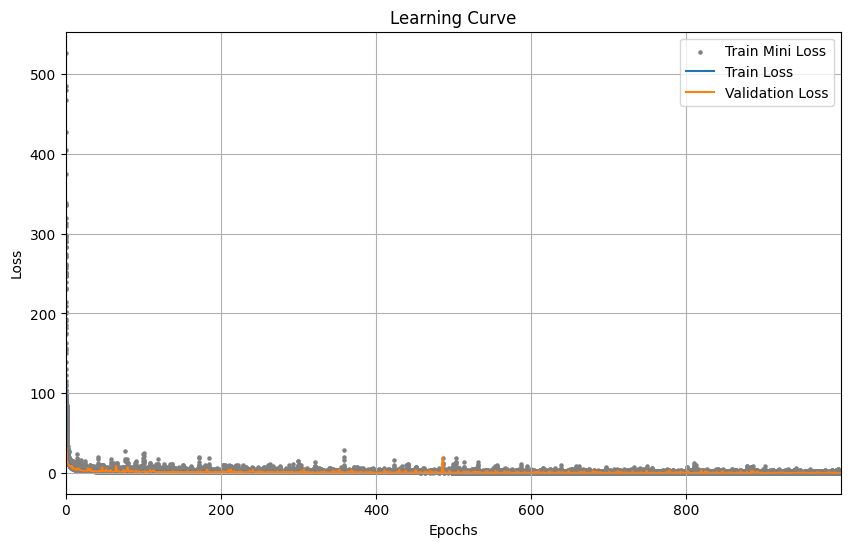

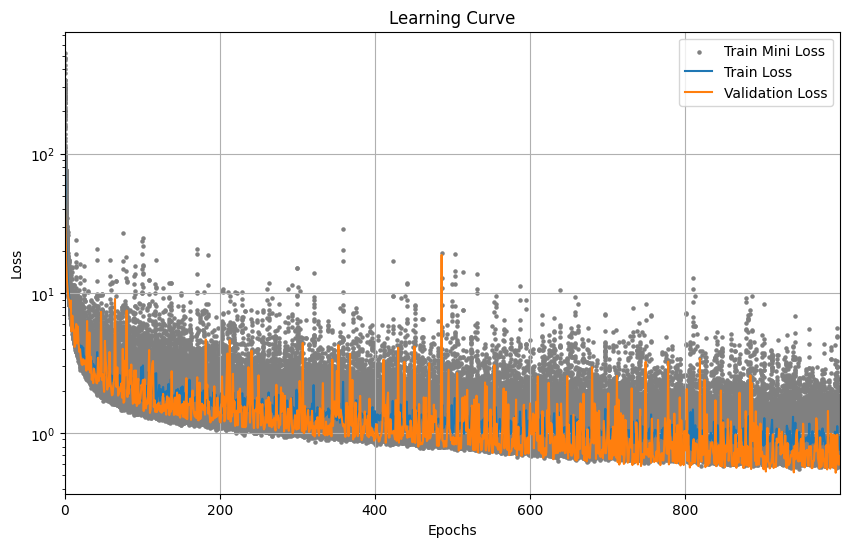

In [64]:
model = StepOneValueNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 1000)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

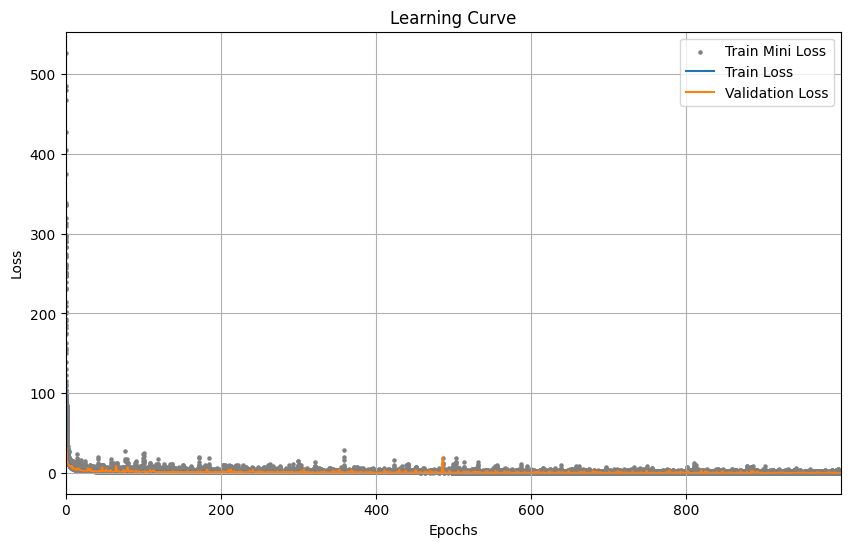

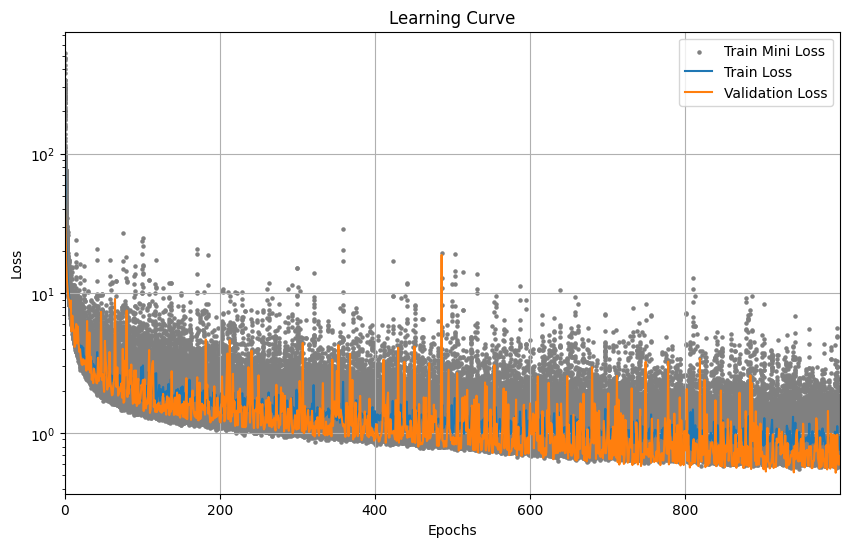

In [65]:
plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)